In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_around_onset_combined_1sec_dhpc'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'annotate_heatmap', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_outcome_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_prediction_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_predict_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_cross', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', 

In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals =      'dhpcg1','dhpcg20','dhpc24'
pre_animals =      'dhpcg1','dhpcg20','dhpc24'
d2_animals =       'dhpcg1','dhpcg20','dhpc24'
post_animals =     'dhpcg1','dhpcg20','dhpc24'
pre_rev_animals =  'dhpcg1','dhpcg20','dhpc24'
post_rev_animals = 'dhpcg1','dhpcg20','dhpc24'
catch_animals =    'dhpcg1','dhpcg20'

In [102]:
sessions = 'pre','d2','post','pre_rev','post_rev','catch'
dark_co = 'darkcyan','rebeccapurple','firebrick','limegreen','salmon','goldenrod'

In [10]:
for sess in sessions:
    for dur in 1,: #use 5 for 0.5sec, 1 for 1 sec and 2 for 2sec
        exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,dur,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,sess))
        if sess == 'catch':
            exec("labels_catch_nd = dict(zip(%s_animals, [ut.load_variable('labels_%s_nd',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess))

In [11]:
#delta_t0 = 0.5sec
#from referenced notebook, 14 time bins total beginning at 3s prior to odor onset and running through 11s post onset

#t_start0 = -3  # sec
#t_stop0 = 11  # sec

In [10]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None,n_trials=None):
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        if n_trials != None:
            which_train_a = which_train_a[:n_trials]
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        if n_trials != None:
            which_train_b = which_train_b[:n_trials]
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [13]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [14]:
for sess in sessions:
    for t in range(13):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dh

In [15]:
all_labels='rwVSsh','rwVScsm','shVScsm','rwndVSshnd','rwVSrwnd','rwndVScsm','shVSshnd','shndVScsm'
non_catch_labels = 'rwVSsh','rwVScsm','shVScsm'
catch_labels = 'rwndVSshnd','rwVSrwnd','rwndVScsm','shVSshnd','shndVScsm'

In [16]:
relabel_rwVSsh =     {0:-3, 1:1,  2:0,  -1:-1, -2:-2}
relabel_rwVScsm =    {0:0,  1:1,  2:-3, -1:-1, -2:-2}
relabel_shVScsm =    {0:0,  1:-3, 2:1,  -1:-1, -2:-2}
relabel_rwndVSshnd = {0:-3, 1:-3, 2:-3, -1:1,  -2:0}  # 'nd' means not delivered (as in, US was not delivered)
relabel_rwVSrwnd =   {0:-3, 1:0,  2:-3, -1:1, -2:-2}
relabel_shVSshnd =   {0:-3, 1:-3, 2:0,  -1:-1, -2:1}
relabel_shndVScsm =  {0:0,  1:-3, 2:-3, -1:-1, -2:1} 
relabel_rwndVScsm =  {0:0,  1:-3, 2:-3, -1:1,  -2:-2}

for sess in sessions:
    for labels in all_labels:
        exec("labels_%s_%s = {}"%(labels,sess))
        for ani in eval("%s_animals"%sess):
            exec("labels_%s_%s[ani] = np.r_[[relabel_%s[l] for l in labels_%s[ani]]]"%(labels,sess,labels,sess))

In [17]:
%%time
for t in range(13): # number of time bins
    n_loops = 15
    for label in non_catch_labels:
        exec('scores_tb_%s_%s = {}'%(t,label))
        for sess in sessions:  #all but catch session
            print sess,label,t,
            eval("scores_tb_%s_%s"%(t,label))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(label,sess))) for i in range(n_loops)]]

pre rwVSsh 0 d2 rwVSsh 0 post rwVSsh 0 pre_rev rwVSsh 0 post_rev rwVSsh 0 catch rwVSsh 0 pre rwVScsm 0 d2 rwVScsm 0 post rwVScsm 0 pre_rev rwVScsm 0 post_rev rwVScsm 0 catch rwVScsm 0 pre shVScsm 0 d2 shVScsm 0 post shVScsm 0 pre_rev shVScsm 0 post_rev shVScsm 0 catch shVScsm 0 pre rwVSsh 1 d2 rwVSsh 1 post rwVSsh 1 pre_rev rwVSsh 1 post_rev rwVSsh 1 catch rwVSsh 1 pre rwVScsm 1 d2 rwVScsm 1 post rwVScsm 1 pre_rev rwVScsm 1 post_rev rwVScsm 1 catch rwVScsm 1 pre shVScsm 1 d2 shVScsm 1 post shVScsm 1 pre_rev shVScsm 1 post_rev shVScsm 1 catch shVScsm 1 pre rwVSsh 2 d2 rwVSsh 2 post rwVSsh 2 pre_rev rwVSsh 2 post_rev rwVSsh 2 catch rwVSsh 2 pre rwVScsm 2 d2 rwVScsm 2 post rwVScsm 2 pre_rev rwVScsm 2 post_rev rwVScsm 2 catch rwVScsm 2 pre shVScsm 2 d2 shVScsm 2 post shVScsm 2 pre_rev shVScsm 2 post_rev shVScsm 2 catch shVScsm 2 pre rwVSsh 3 d2 rwVSsh 3 post rwVSsh 3 pre_rev rwVSsh 3 post_rev rwVSsh 3 catch rwVSsh 3 pre rwVScsm 3 d2 rwVScsm 3 post rwVScsm 3 pre_rev rwVScsm 3 post_rev rwVSc

In [18]:
%%time
for t in range(13): # number of time bins
    n_loops = 15
    for label in catch_labels:
        exec('scores_tb_%s_%s = {}'%(t,label))
        for sess in 'catch',:  #only catch session
            print sess,label,t,
            eval("scores_tb_%s_%s"%(t,label))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(label,sess))) for i in range(n_loops)]]

catch rwndVSshnd 0 catch rwVSrwnd 0 catch rwndVScsm 0 catch shVSshnd 0 catch shndVScsm 0 catch rwndVSshnd 1 catch rwVSrwnd 1 catch rwndVScsm 1 catch shVSshnd 1 catch shndVScsm 1 catch rwndVSshnd 2 catch rwVSrwnd 2 catch rwndVScsm 2 catch shVSshnd 2 catch shndVScsm 2 catch rwndVSshnd 3 catch rwVSrwnd 3 catch rwndVScsm 3 catch shVSshnd 3 catch shndVScsm 3 catch rwndVSshnd 4 catch rwVSrwnd 4 catch rwndVScsm 4 catch shVSshnd 4 catch shndVScsm 4 catch rwndVSshnd 5 catch rwVSrwnd 5 catch rwndVScsm 5 catch shVSshnd 5 catch shndVScsm 5 catch rwndVSshnd 6 catch rwVSrwnd 6 catch rwndVScsm 6 catch shVSshnd 6 catch shndVScsm 6 catch rwndVSshnd 7 catch rwVSrwnd 7 catch rwndVScsm 7 catch shVSshnd 7 catch shndVScsm 7 catch rwndVSshnd 8 catch rwVSrwnd 8 catch rwndVScsm 8 catch shVSshnd 8 catch shndVScsm 8 catch rwndVSshnd 9 catch rwVSrwnd 9 catch rwndVScsm 9 catch shVSshnd 9 catch shndVScsm 9 catch rwndVSshnd 10 catch rwVSrwnd 10 catch rwndVScsm 10 catch shVSshnd 10 catch shndVScsm 10 catch rwndVSshnd

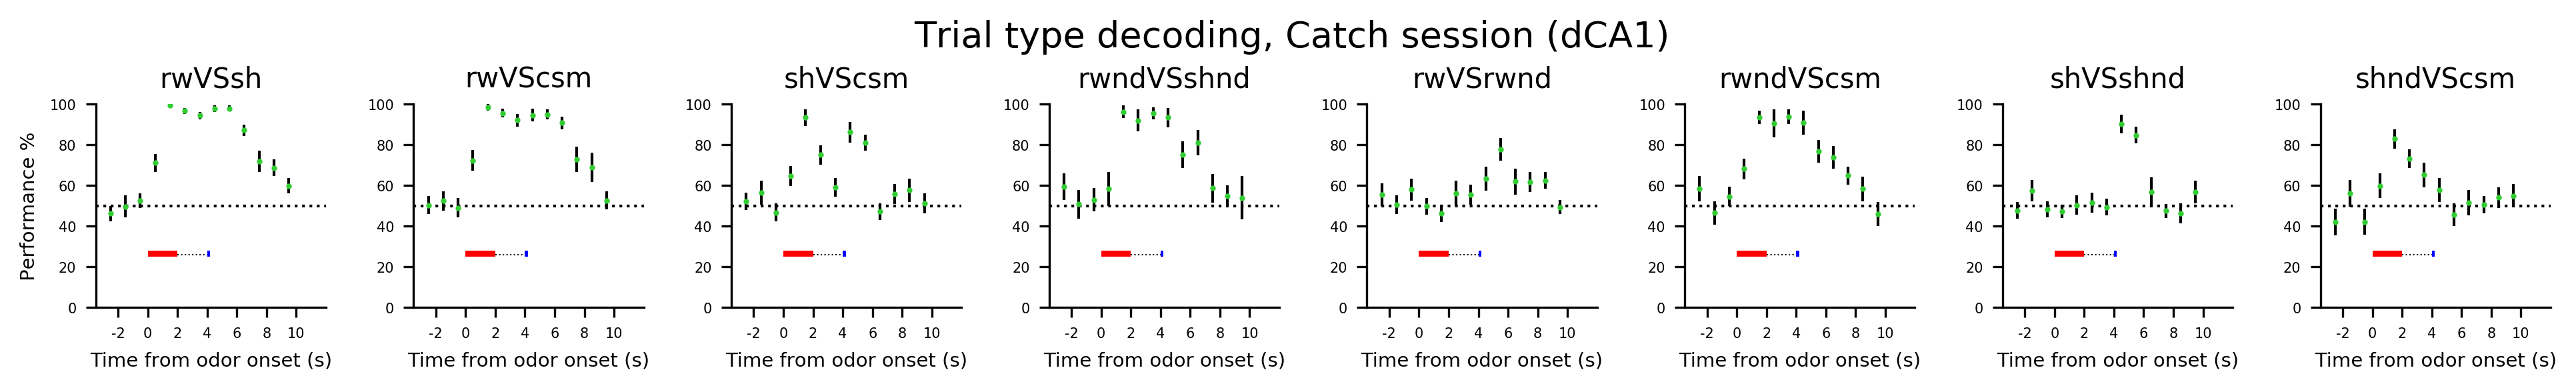

In [19]:
fig, ax = pl.subplots(1,len(all_labels), figsize=(13, 1.8))

for sess in 'catch',:
    for label,col in zip(all_labels,range(len(all_labels))):
        for t in range(13):
            ax[col].plot(t-2.5, np.mean(eval("scores_tb_%s_%s[sess]"%(t,label)))*100, 'o', color='limegreen', ls='-',lw=.5, zorder=19 ,ms=1)
            m = np.mean(eval("scores_tb_%s_%s[sess]"%(t,label)))*100
            s = np.std(eval("scores_tb_%s_%s[sess]"%(t,label)))*100 / np.sqrt(eval("scores_tb_%s_%s[sess]"%(t,label)).shape[-1])
            ax[col].errorbar(t-2.5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            ax[col].set_title(all_labels[col],fontsize=10)
for x in range (len(all_labels)):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-3.5, 12)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50,-3.5,12, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[0].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
pl.suptitle("Trial type decoding, Catch session (dCA1)", y=1.05,fontsize=13)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_horizontal.jpg'%NOTEBOOK_NAME)

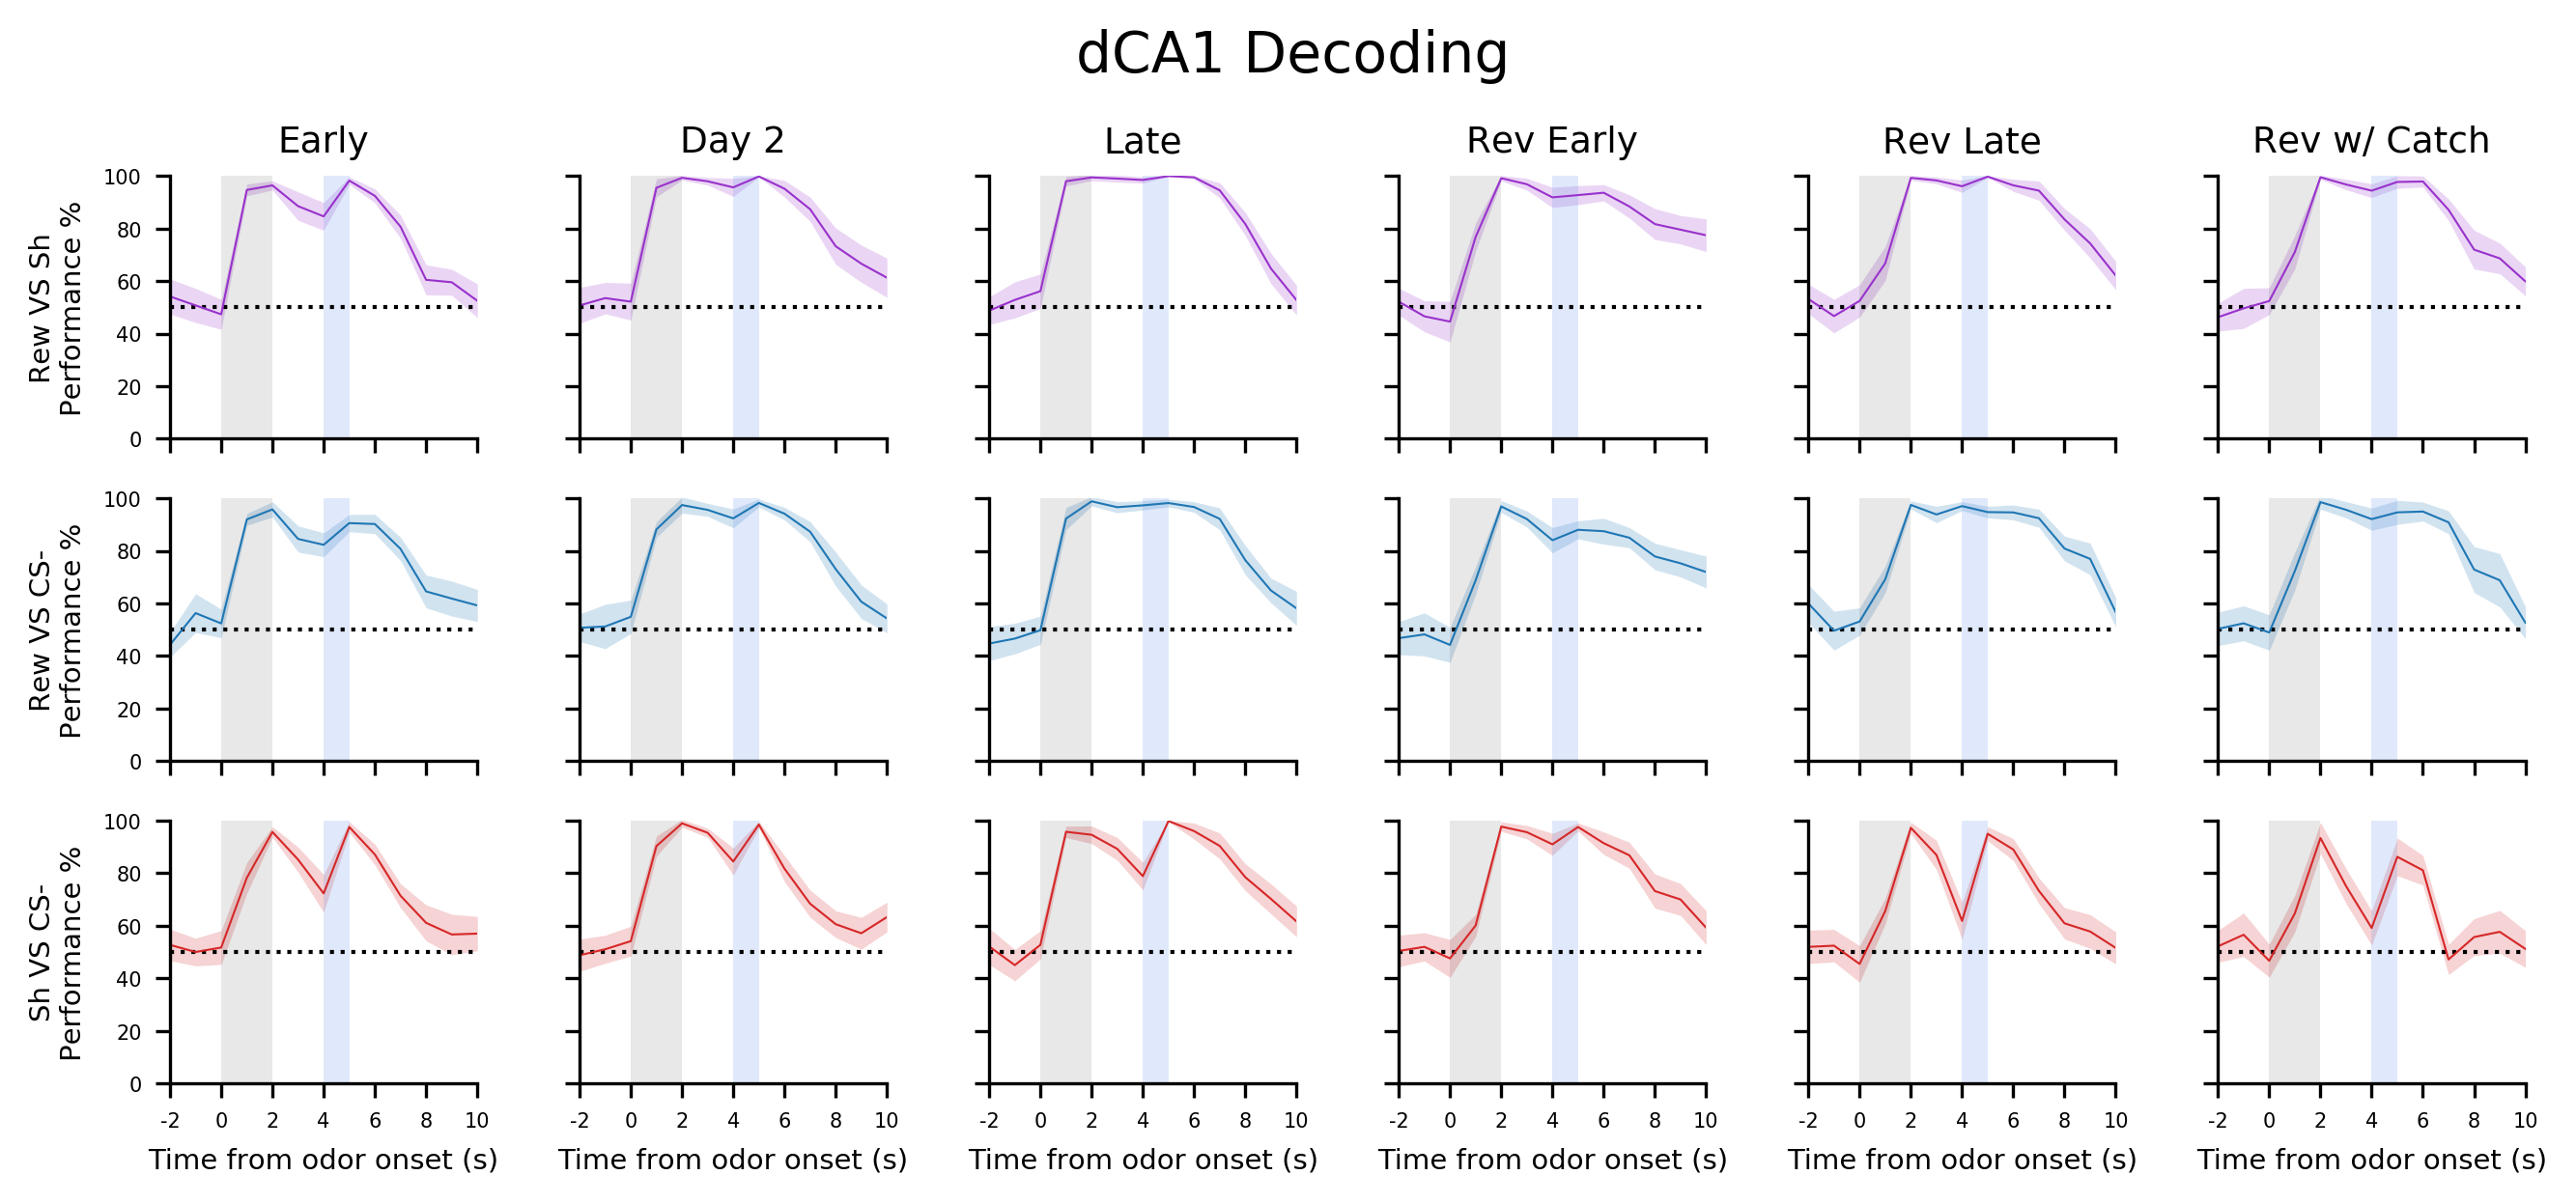

In [20]:
fig, ax = pl.subplots(3,6, figsize=(9, 3.9), sharex=True, sharey=True)

for r,sess in zip(range(6),sessions):
    for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s_%s[sess]"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s_%s[sess]"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s_%s[sess]"%(t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(6):       
    for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Day 2', fontsize=9, color='k')
ax[0][2].set_title('Late', fontsize=9, color = 'k')
ax[0][3].set_title('Rev Early', fontsize=9, color = 'k')
ax[0][4].set_title('Rev Late', fontsize=9, color = 'k')
ax[0][5].set_title('Rev w/ Catch', fontsize=9, color='k')

pl.suptitle('dCA1 Decoding',fontsize=14,y=1.05)
fig.tight_layout(pad=2)


fig.savefig('../img/%s_horizontal_all_comp.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using global min

In [21]:
#get number of cells used for decoding
cell_total = ['total_cells_pre', 'total_cells_post','total_cells_pre_rev','total_cells_post_rev']
for tot in cell_total:
    for region in ['dhpc','vhpc']:
        what = ut.load_variable('%s_%s'%(tot,region), '../notebooks/autorestore/n_cells/')
        exec('%s_%s = what'%(tot,region))
        print '%s_%s ='%(tot,region),
        print what
        
for tot in 'total_cells_catch',:
    for region in ['dhpc','vhpc']:
        what = ut.load_variable('%s_%s'%(tot,region), '../notebooks/autorestore/decoding_around_onset_combined_1sec_%s_catch/'%region)
        exec('%s_%s = what'%(tot,region))
        print '%s_%s ='%(tot,region),
        print what
#total_cells_catch_dhpc = 354
#total_cells_catch_vhpc = 

total_cells_pre_dhpc = 790
total_cells_pre_vhpc = 499
total_cells_post_dhpc = 909
total_cells_post_vhpc = 553
total_cells_pre_rev_dhpc = 919
total_cells_pre_rev_vhpc = 444
total_cells_post_rev_dhpc = 703
total_cells_post_rev_vhpc = 519
total_cells_catch_dhpc = 354
total_cells_catch_vhpc = 507


In [22]:
#ignore pre-rev
g_min = np.min((total_cells_pre_vhpc,total_cells_pre_dhpc, total_cells_post_vhpc,total_cells_post_dhpc,
                total_cells_post_rev_vhpc,total_cells_post_rev_dhpc))
print g_min

499


In [23]:
g_min_catch = np.min((total_cells_pre_vhpc,total_cells_pre_dhpc, total_cells_post_vhpc,total_cells_post_dhpc,
                total_cells_pre_rev_vhpc,total_cells_pre_rev_dhpc, total_cells_post_rev_vhpc,total_cells_post_rev_dhpc,
                total_cells_catch_vhpc,total_cells_catch_dhpc))
print g_min_catch

354


In [315]:
%%time
for t in range(13): # number of time bins
    n_loops = 15
    for label in non_catch_labels:
        exec('scores_gmin_tb_%s_%s = {}'%(t,label))
        for sess in sessions[:-1]:
            print sess,label,t,
            eval("scores_gmin_tb_%s_%s"%(t,label))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),
                                eval('labels_%s_%s'%(label,sess)), n_cells=g_min) for i in range(n_loops)]]

post rwVScsm 0 post rwVScsm 1 post rwVScsm 2 post rwVScsm 3 post rwVScsm 4 post rwVScsm 5 post rwVScsm 6 post rwVScsm 7 post rwVScsm 8 post rwVScsm 9 post rwVScsm 10 post rwVScsm 11 post rwVScsm 12CPU times: user 2min 44s, sys: 8.88 s, total: 2min 53s
Wall time: 7.29 s



In [316]:
print scores_gmin_tb_4_rwVScsm['post'][:10].mean()
print np.std(scores_gmin_tb_4_rwVScsm['post'][:10])

0.98125
0.0210282548016


In [249]:
%%time
for t in range(13): # number of time bins
    n_loops = 15
    for label in catch_labels:
        exec('scores_gmin_tb_%s_%s = {}'%(t,label))
        for sess in 'catch',:  #only catch session
            print sess,label,t,
            eval("scores_gmin_tb_%s_%s"%(t,label))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),
                                eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch) for i in range(n_loops)]]
            
    for label in non_catch_labels:
        for sess in 'catch',:  #only catch session
            print sess,label,t,
            eval("scores_gmin_tb_%s_%s"%(t,label))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),
                                eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch) for i in range(n_loops)]]

catch rwndVSshnd 0 catch rwVSrwnd 0 catch rwndVScsm 0 catch shVSshnd 0 catch shndVScsm 0 catch rwVSsh 0 catch rwVScsm 0 catch shVScsm 0 catch rwndVSshnd 1 catch rwVSrwnd 1 catch rwndVScsm 1 catch shVSshnd 1 catch shndVScsm 1 catch rwVSsh 1 catch rwVScsm 1 catch shVScsm 1 catch rwndVSshnd 2 catch rwVSrwnd 2 catch rwndVScsm 2 catch shVSshnd 2 catch shndVScsm 2 catch rwVSsh 2 catch rwVScsm 2 catch shVScsm 2 catch rwndVSshnd 3 catch rwVSrwnd 3 catch rwndVScsm 3 catch shVSshnd 3 catch shndVScsm 3 catch rwVSsh 3 catch rwVScsm 3 catch shVScsm 3 catch rwndVSshnd 4 catch rwVSrwnd 4 catch rwndVScsm 4 catch shVSshnd 4 catch shndVScsm 4 catch rwVSsh 4 catch rwVScsm 4 catch shVScsm 4 catch rwndVSshnd 5 catch rwVSrwnd 5 catch rwndVScsm 5 catch shVSshnd 5 catch shndVScsm 5 catch rwVSsh 5 catch rwVScsm 5 catch shVScsm 5 catch rwndVSshnd 6 catch rwVSrwnd 6 catch rwndVScsm 6 catch shVSshnd 6 catch shndVScsm 6 catch rwVSsh 6 catch rwVScsm 6 catch shVScsm 6 catch rwndVSshnd 7 catch rwVSrwnd 7 catch rwndVS

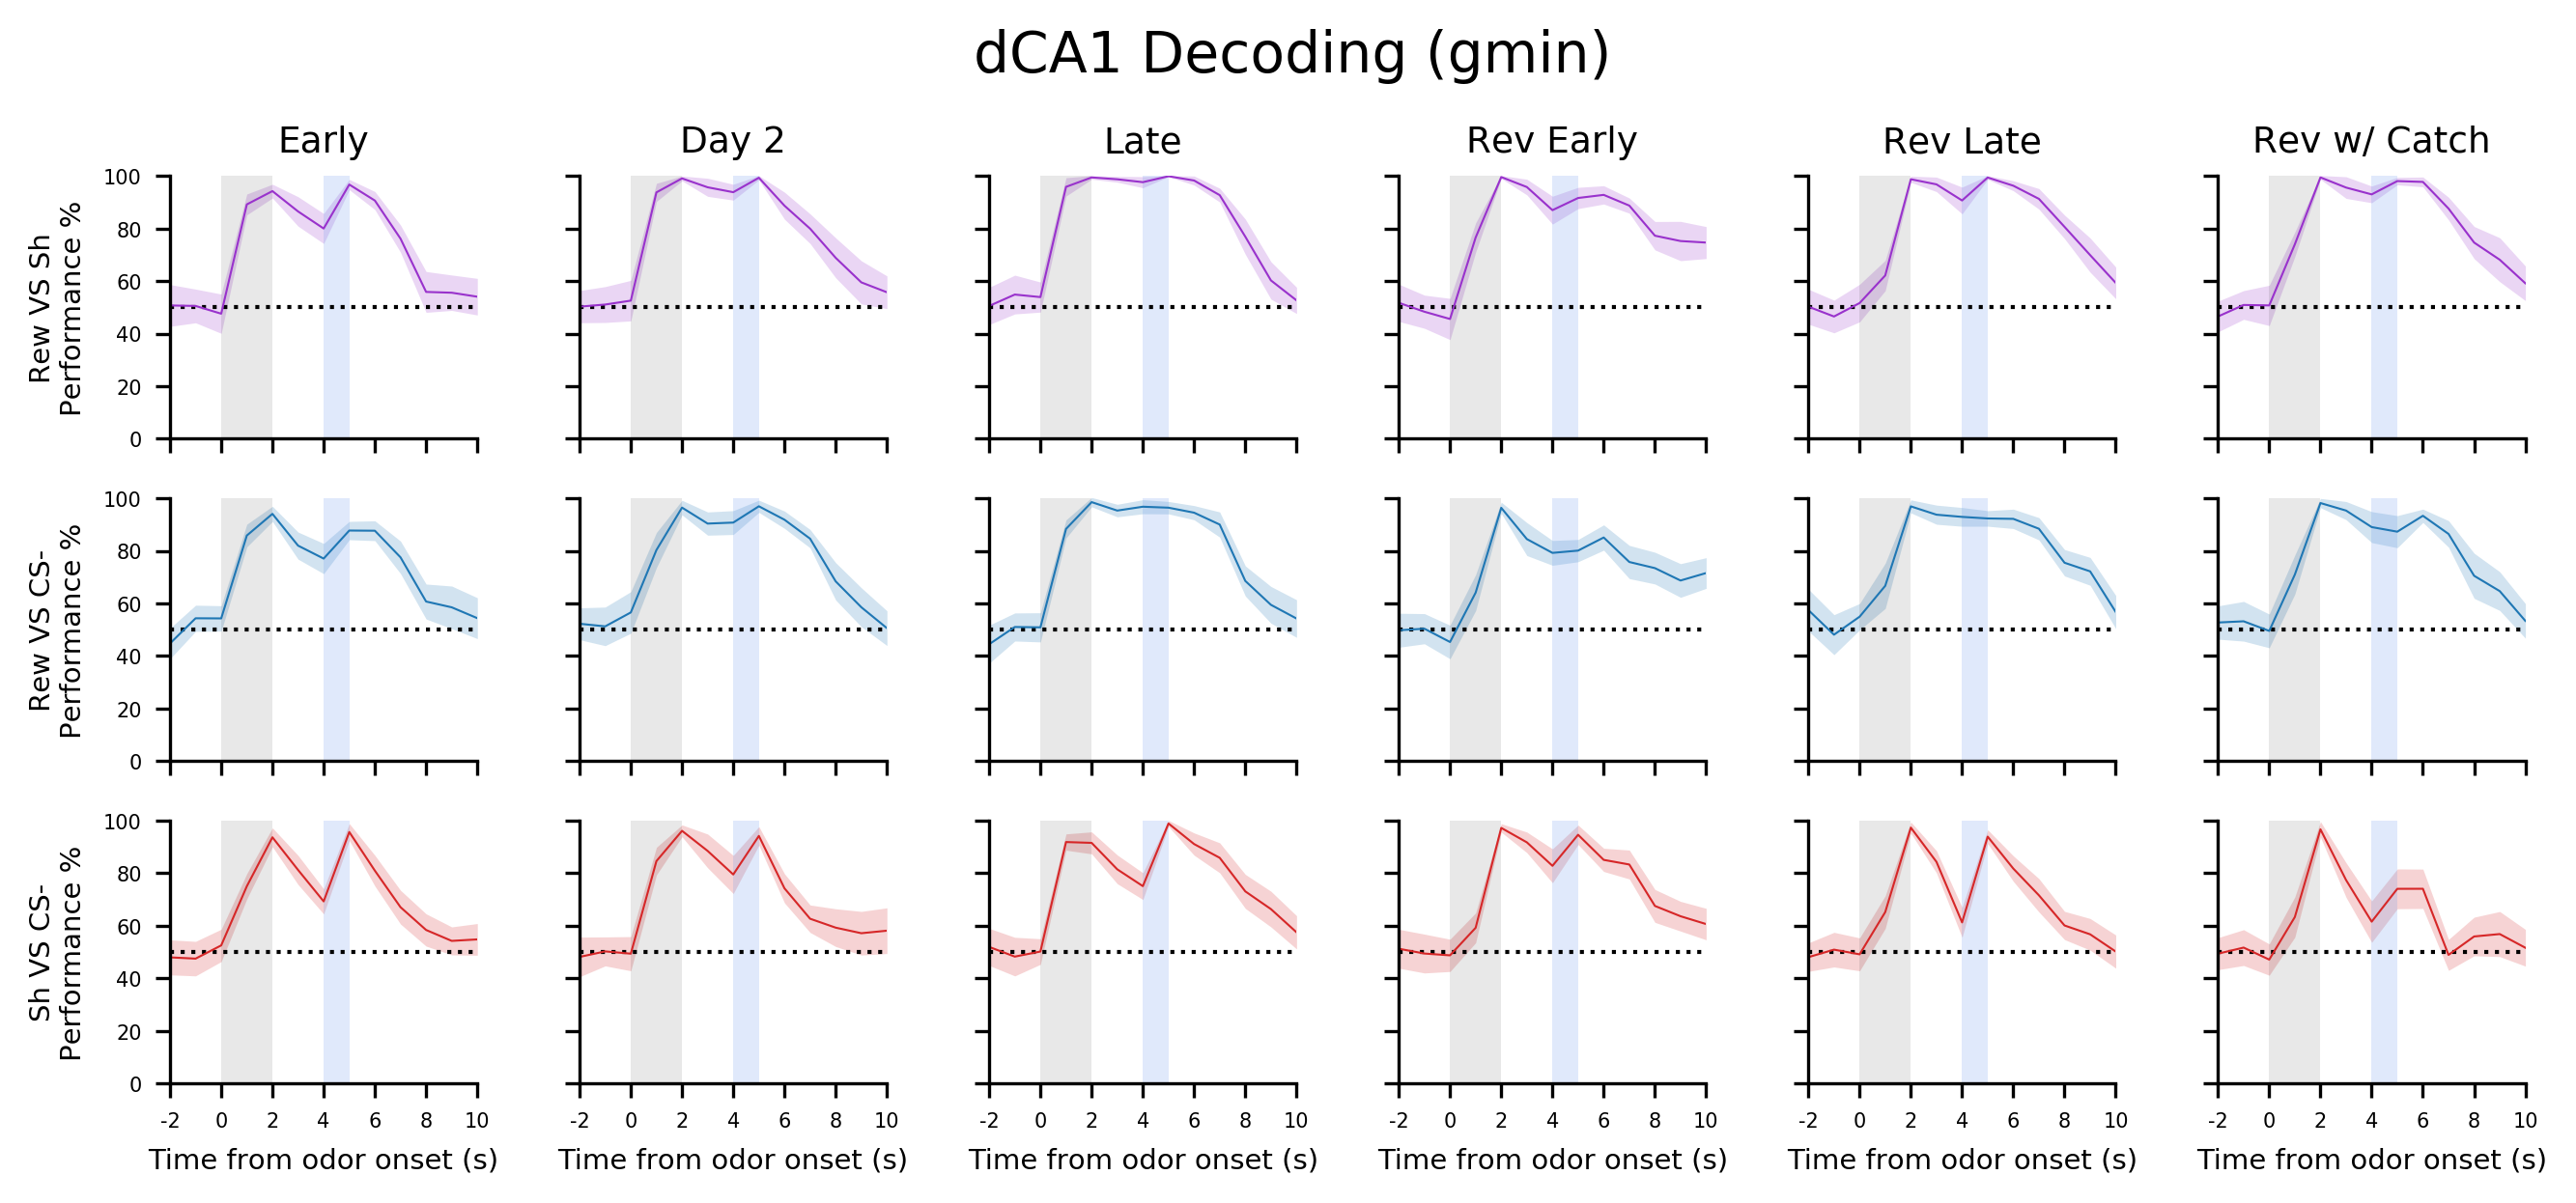

In [259]:
fig, ax = pl.subplots(3,6, figsize=(9, 3.9), sharex=True, sharey=True)

for r,sess in zip(range(6),sessions):
    for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_gmin_tb_%s_%s[sess]"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_gmin_tb_%s_%s[sess]"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_gmin_tb_%s_%s[sess]"%(t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(6):       
    for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Day 2', fontsize=9, color='k')
ax[0][2].set_title('Late', fontsize=9, color = 'k')
ax[0][3].set_title('Rev Early', fontsize=9, color = 'k')
ax[0][4].set_title('Rev Late', fontsize=9, color = 'k')
ax[0][5].set_title('Rev w/ Catch', fontsize=9, color='k')

pl.suptitle('dCA1 Decoding (gmin)',fontsize=14,y=1.05)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_gmin_horizontal.pdf'%NOTEBOOK_NAME)

# decode using subset of trials

In [11]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None,n_trials=None):
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        if n_trials != None:
            which_train_a = which_train_a[:n_trials]
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        if n_trials != None:
            which_train_b = which_train_b[:n_trials]
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [28]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for phase,trls in zip(['early','mid','late'],[(0,40),(40,80),(80,120)]):
        for label in non_catch_labels:
            exec('scores_gmin_tb_%s_%s_%s = {}'%(t,label,phase))
            for sess in sessions[:-1]:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]

pre rwVSsh 0 early d2 rwVSsh 0 early post rwVSsh 0 early pre_rev rwVSsh 0 early post_rev rwVSsh 0 early pre rwVScsm 0 early d2 rwVScsm 0 early post rwVScsm 0 early pre_rev rwVScsm 0 early post_rev rwVScsm 0 early pre shVScsm 0 early d2 shVScsm 0 early post shVScsm 0 early pre_rev shVScsm 0 early post_rev shVScsm 0 early pre rwVSsh 0 mid d2 rwVSsh 0 mid post rwVSsh 0 mid pre_rev rwVSsh 0 mid post_rev rwVSsh 0 mid pre rwVScsm 0 mid d2 rwVScsm 0 mid post rwVScsm 0 mid pre_rev rwVScsm 0 mid post_rev rwVScsm 0 mid pre shVScsm 0 mid d2 shVScsm 0 mid post shVScsm 0 mid pre_rev shVScsm 0 mid post_rev shVScsm 0 mid pre rwVSsh 0 late d2 rwVSsh 0 late post rwVSsh 0 late pre_rev rwVSsh 0 late post_rev rwVSsh 0 late pre rwVScsm 0 late d2 rwVScsm 0 late post rwVScsm 0 late pre_rev rwVScsm 0 late post_rev rwVScsm 0 late pre shVScsm 0 late d2 shVScsm 0 late post shVScsm 0 late pre_rev shVScsm 0 late post_rev shVScsm 0 late pre rwVSsh 1 early d2 rwVSsh 1 early post rwVSsh 1 early pre_rev rwVSsh 1 early

In [29]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for phase,trls in zip(['early','mid','late'],[(0,40),(40,80),(80,120)]):
        for label in catch_labels:
            exec('scores_gmin_tb_%s_%s_%s = {}'%(t,label,phase))
            for sess in 'catch',:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]
                
        for label in non_catch_labels:
            for sess in 'catch',:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]

catch rwndVSshnd 0 early catch rwVSrwnd 0 early catch rwndVScsm 0 early catch shVSshnd 0 early catch shndVScsm 0 early catch rwVSsh 0 early catch rwVScsm 0 early catch shVScsm 0 early catch rwndVSshnd 0 mid catch rwVSrwnd 0 mid catch rwndVScsm 0 mid catch shVSshnd 0 mid catch shndVScsm 0 mid catch rwVSsh 0 mid catch rwVScsm 0 mid catch shVScsm 0 mid catch rwndVSshnd 0 late catch rwVSrwnd 0 late catch rwndVScsm 0 late catch shVSshnd 0 late catch shndVScsm 0 late catch rwVSsh 0 late catch rwVScsm 0 late catch shVScsm 0 late catch rwndVSshnd 1 early catch rwVSrwnd 1 early catch rwndVScsm 1 early catch shVSshnd 1 early catch shndVScsm 1 early catch rwVSsh 1 early catch rwVScsm 1 early catch shVScsm 1 early catch rwndVSshnd 1 mid catch rwVSrwnd 1 mid catch rwndVScsm 1 mid catch shVSshnd 1 mid catch shndVScsm 1 mid catch rwVSsh 1 mid catch rwVScsm 1 mid catch shVScsm 1 mid catch rwndVSshnd 1 late catch rwVSrwnd 1 late catch rwndVScsm 1 late catch shVSshnd 1 late catch shndVScsm 1 late catch 

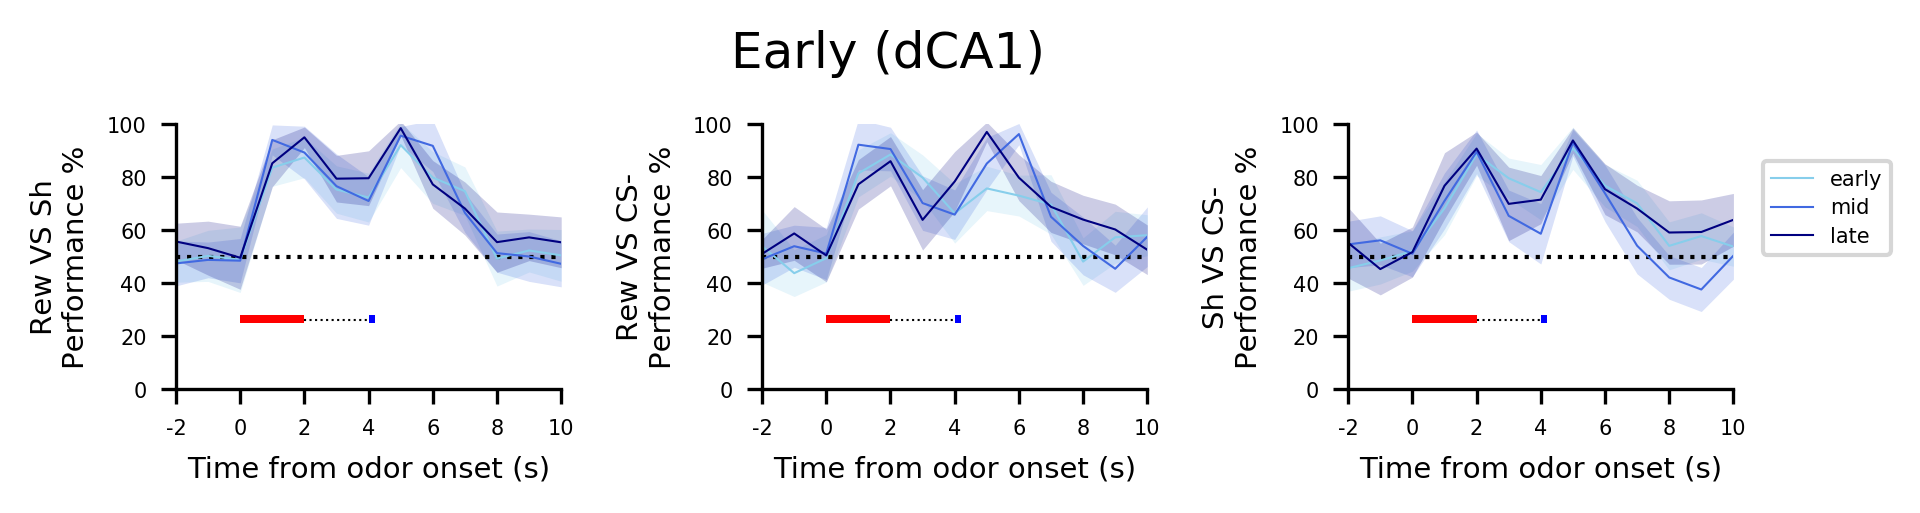

In [30]:
fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for lab, x in zip(non_catch_labels,range(len(non_catch_labels))):
    for phase,c in zip(['early','mid','late'],(('skyblue','royalblue','navy'))):
        ax[x].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_gmin_tb_%s_%s_%s['pre']"%(t,lab,phase)))*100) for t in range(13)], color=c,label=phase)
        m = np.array([(np.mean(eval("scores_gmin_tb_%s_%s_%s['pre']"%(t,lab,phase)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_gmin_tb_%s_%s_%s['pre']"%(t,lab,phase)))*100 for t in range(13)])
        ax[x].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for lab, x in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):    
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 10)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel(lab+'\nPerformance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
    ax[2].legend(bbox_to_anchor=(1.05,.9),labelspacing=0.4,fontsize=5)
fig.tight_layout(pad=2)
pl.suptitle('Early (dCA1)',fontsize=12,y=1.1)


#fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

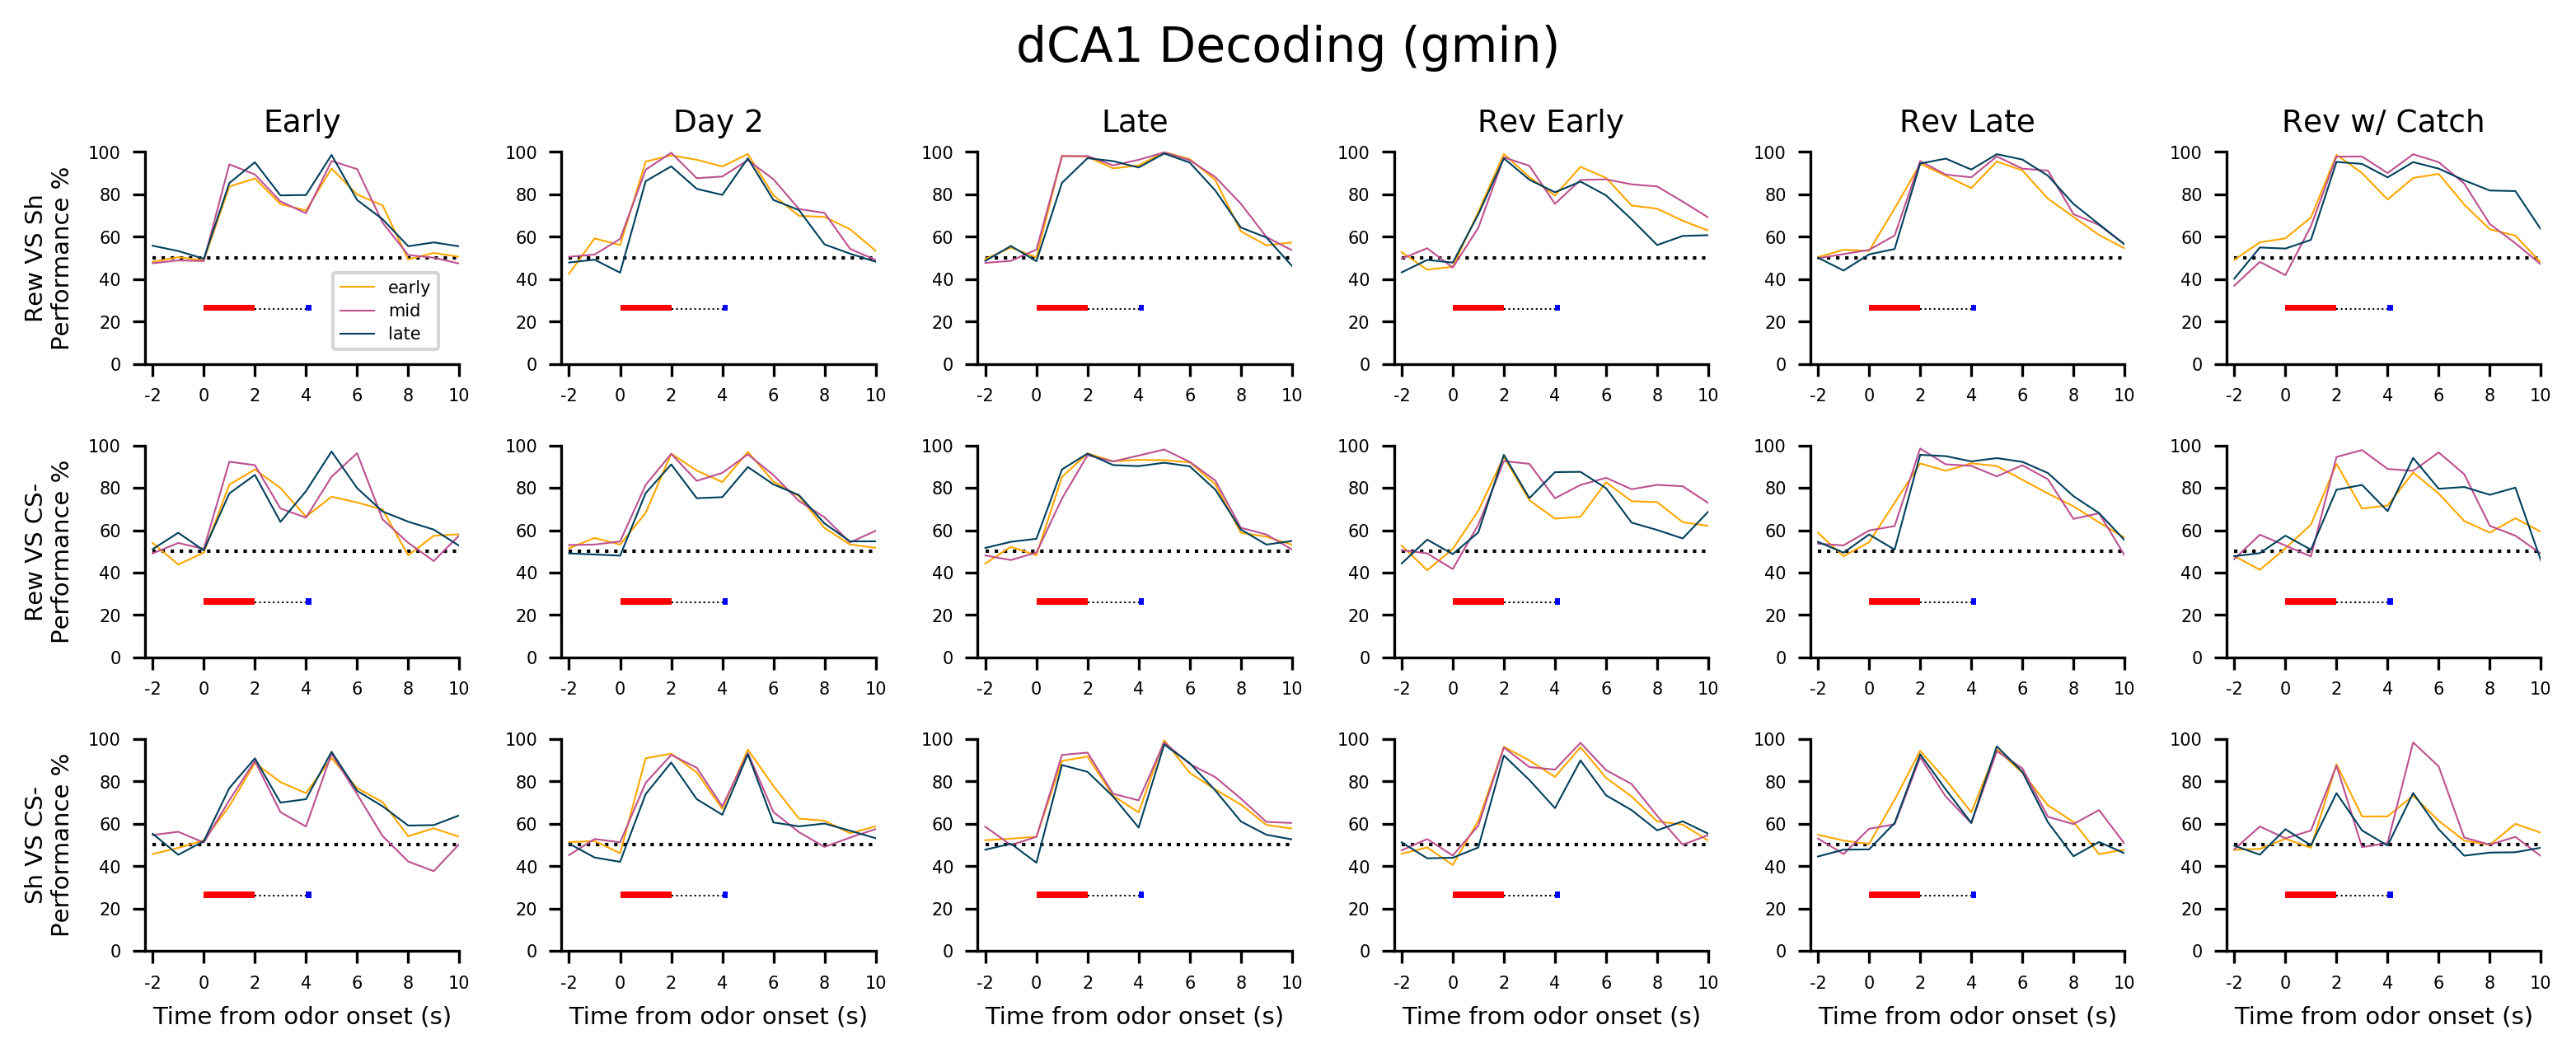

In [31]:
fig, ax = pl.subplots(3,6, figsize=(10.5, 4))

for sess,r in zip(sessions,range(len(sessions))):
    for lab, x in zip(non_catch_labels,range(len(non_catch_labels))):
        for phase,c in zip(['early','mid','late'],(('#ffa600','#bc5090','#003f5c'))):
            ax[x][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_gmin_tb_%s_%s_%s[sess]"%(t,lab,phase)))*100) for t in range(13)], color=c,label=phase)
            m = np.array([(np.mean(eval("scores_gmin_tb_%s_%s_%s[sess]"%(t,lab,phase)))*100) for t in range(13)])
            s = np.array([np.std(eval("scores_gmin_tb_%s_%s_%s[sess]"%(t,lab,phase)))*100 for t in range(13)])
            #ax[x][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

for lab, x in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
    for r in range(len(sessions)):
        ax[x][r].set_ylim(0, 100)
        ax[x][r].set_xlim(-2.3, 10)
        ax[x][r].set_xticks(np.arange(-2,11, 2))
        ax[x][r].set_xticklabels(np.arange(-2,11, 2))
        ax[x][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2][r].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[x][r], 25, start_end=(0, 2), color='r', delta_y=3)
        pt.plot_period_bar(ax[x][r], 25, start_end=(4, 4.2), color='b', delta_y=3)
        ax[x][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[0][0].legend(bbox_to_anchor=(.96,.47),labelspacing=0.4,fontsize=5)

ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Day 2', fontsize=9, color='k')
ax[0][2].set_title('Late', fontsize=9, color = 'k')
ax[0][3].set_title('Rev Early', fontsize=9, color = 'k')
ax[0][4].set_title('Rev Late', fontsize=9, color = 'k')
ax[0][5].set_title('Rev w/ Catch', fontsize=9, color='k')


fig.tight_layout(pad=2)
pl.suptitle('dCA1 Decoding (gmin)',fontsize=14,y=1.05)


#fig.savefig('../img/%s_gmin_combined.pdf'%NOTEBOOK_NAME)

In [32]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for phase,trls in zip(['firstHalf','lastHalf'],[(0,60),(60,120)]):
        for label in non_catch_labels:
            exec('scores_gmin_tb_%s_%s_%s = {}'%(t,label,phase))
            for sess in sessions[:-1]:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]

pre rwVSsh 0 firstHalf d2 rwVSsh 0 firstHalf post rwVSsh 0 firstHalf pre_rev rwVSsh 0 firstHalf post_rev rwVSsh 0 firstHalf pre rwVScsm 0 firstHalf d2 rwVScsm 0 firstHalf post rwVScsm 0 firstHalf pre_rev rwVScsm 0 firstHalf post_rev rwVScsm 0 firstHalf pre shVScsm 0 firstHalf d2 shVScsm 0 firstHalf post shVScsm 0 firstHalf pre_rev shVScsm 0 firstHalf post_rev shVScsm 0 firstHalf pre rwVSsh 0 lastHalf d2 rwVSsh 0 lastHalf post rwVSsh 0 lastHalf pre_rev rwVSsh 0 lastHalf post_rev rwVSsh 0 lastHalf pre rwVScsm 0 lastHalf d2 rwVScsm 0 lastHalf post rwVScsm 0 lastHalf pre_rev rwVScsm 0 lastHalf post_rev rwVScsm 0 lastHalf pre shVScsm 0 lastHalf d2 shVScsm 0 lastHalf post shVScsm 0 lastHalf pre_rev shVScsm 0 lastHalf post_rev shVScsm 0 lastHalf pre rwVSsh 1 firstHalf d2 rwVSsh 1 firstHalf post rwVSsh 1 firstHalf pre_rev rwVSsh 1 firstHalf post_rev rwVSsh 1 firstHalf pre rwVScsm 1 firstHalf d2 rwVScsm 1 firstHalf post rwVScsm 1 firstHalf pre_rev rwVScsm 1 firstHalf post_rev rwVScsm 1 firstHal

In [33]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for phase,trls in zip(['firstHalf','lastHalf'],[(0,60),(60,120)]):
        for label in catch_labels:
            exec('scores_gmin_tb_%s_%s_%s = {}'%(t,label,phase))
            for sess in 'catch',:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]
                
        for label in non_catch_labels:
            for sess in 'catch',:
                print sess,label,t,phase,
                eval("scores_gmin_tb_%s_%s_%s"%(t,label,phase))[sess] = np.r_[[do_test_within_subsets(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), n_cells=g_min_catch, start_trial=trls[0], end_trial=trls[1]) for i in range(n_loops)]]

catch rwndVSshnd 0 firstHalf catch rwVSrwnd 0 firstHalf catch rwndVScsm 0 firstHalf catch shVSshnd 0 firstHalf catch shndVScsm 0 firstHalf catch rwVSsh 0 firstHalf catch rwVScsm 0 firstHalf catch shVScsm 0 firstHalf catch rwndVSshnd 0 lastHalf catch rwVSrwnd 0 lastHalf catch rwndVScsm 0 lastHalf catch shVSshnd 0 lastHalf catch shndVScsm 0 lastHalf catch rwVSsh 0 lastHalf catch rwVScsm 0 lastHalf catch shVScsm 0 lastHalf catch rwndVSshnd 1 firstHalf catch rwVSrwnd 1 firstHalf catch rwndVScsm 1 firstHalf catch shVSshnd 1 firstHalf catch shndVScsm 1 firstHalf catch rwVSsh 1 firstHalf catch rwVScsm 1 firstHalf catch shVScsm 1 firstHalf catch rwndVSshnd 1 lastHalf catch rwVSrwnd 1 lastHalf catch rwndVScsm 1 lastHalf catch shVSshnd 1 lastHalf catch shndVScsm 1 lastHalf catch rwVSsh 1 lastHalf catch rwVScsm 1 lastHalf catch shVScsm 1 lastHalf catch rwndVSshnd 2 firstHalf catch rwVSrwnd 2 firstHalf catch rwndVScsm 2 firstHalf catch shVSshnd 2 firstHalf catch shndVScsm 2 firstHalf catch rwVSsh 

# confustion matrix

In [32]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
import numpy as np
cv = LeaveOneOut()

decoder = LinearSVC()

In [196]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=.5)
    ax.tick_params(axis='both', which='both', bottom=False, left=False,pad=-1)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [43]:
def combine_train_test_patterns_b(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])

In [49]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=ncells, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns_b(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [53]:
%%time
loops=10
for sess in sessions:
    print sess,
    for tb in range(13):
        print tb,
        for i in range(loops+1):
            print i,
            exec("predictions_tb%s_%s_%s, test_labels_%s_%s = do_predict_within(patterns_tb_%s_%s, labels_%s,n_cells=g_min,\
            classes=range(3))"%(tb,sess,i,sess,i,tb,sess,sess))
            #exec("predictions_tb%s_%s_%s, test_labels_%s_%s, ncells, predictions_ncells_tb%s_%s_%s = \
            #do_prediction_combined_within(%s_animals,patterns_tb_%s_%s, labels_%s,n_cells=g_min,\
            #classes=range(3))"%(tb,sess,i,sess,i,tb,sess,i,sess,tb,sess,sess))

 pre 0 0 1 2 3 4 5 6 7 8 9 10 1 0 1 2 3 4 5 6 7 8 9 10 2 0 1 2 3 4 5 6 7 8 9 10 3 0 1 2 3 4 5 6 7 8 9 10 4 0 1 2 3 4 5 6 7 8 9 10 5 0 1 2 3 4 5 6 7 8 9 10 6 0 1 2 3 4 5 6 7 8 9 10 7 0 1 2 3 4 5 6 7 8 9 10 8 0 1 2 3 4 5 6 7 8 9 10 9 0 1 2 3 4 5 6 7 8 9 10 10 0 1 2 3 4 5 6 7 8 9 10 11 0 1 2 3 4 5 6 7 8 9 10 12 0 1 2 3 4 5 6 7 8 9 10 d2 0 0 1 2 3 4 5 6 7 8 9 10 1 0 1 2 3 4 5 6 7 8 9 10 2 0 1 2 3 4 5 6 7 8 9 10 3 0 1 2 3 4 5 6 7 8 9 10 4 0 1 2 3 4 5 6 7 8 9 10 5 0 1 2 3 4 5 6 7 8 9 10 6 0 1 2 3 4 5 6 7 8 9 10 7 0 1 2 3 4 5 6 7 8 9 10 8 0 1 2 3 4 5 6 7 8 9 10 9 0 1 2 3 4 5 6 7 8 9 10 10 0 1 2 3 4 5 6 7 8 9 10 11 0 1 2 3 4 5 6 7 8 9 10 12 0 1 2 3 4 5 6 7 8 9 10 post 0 0 1 2 3 4 5 6 7 8 9 10 1 0 1 2 3 4 5 6 7 8 9 10 2 0 1 2 3 4 5 6 7 8 9 10 3 0 1 2 3 4 5 6 7 8 9 10 4 0 1 2 3 4 5 6 7 8 9 10 5 0 1 2 3 4 5 6 7 8 9 10 6 0 1 2 3 4 5 6 7 8 9 10 7 0 1 2 3 4 5 6 7 8 9 10 8 0 1 2 3 4 5 6 7 8 9 10 9 0 1 2 3 4 5 6 7 8 9 10 10 0 1 2 3 4 5 6 7 8 9 10 11 0 1 2 3 4 5 6 7 8 9 10 12 0 1 2 3 4 5 6 7 8 9 10 pre

In [18]:
for od in [0,1,2]:
    for sess in sessions:
        exec("odor%s_correct_%s=[]"%(od,sess))
        for n in range(1,11):
            correct=0
            for i in range(len(predictions_tb4_post_0)):
                    if eval("predictions_tb4_%s_%s[i]==%s"%(sess,n,od)) and eval("test_labels_%s_0[i]==%s"%(sess,od)):
                        correct=correct+1
            exec("odor%s_correct_%s.append(correct)"%(od,sess))
        print sess,od,eval("odor%s_correct_%s"%(od,sess)), eval("np.mean(odor%s_correct_%s)"%(od,sess))

pre 0 [92, 91, 88, 94, 92, 91, 79, 94, 79, 97] 89.7
d2 0 [83, 94, 98, 97, 97, 78, 90, 92, 85, 93] 90.7
post 0 [86, 95, 92, 96, 98, 87, 91, 95, 82, 89] 91.1
pre_rev 0 [99, 85, 95, 93, 82, 93, 97, 89, 68, 92] 89.3
post_rev 0 [100, 82, 93, 96, 98, 100, 97, 97, 100, 99] 96.2
catch 0 [78, 100, 97, 100, 99, 100, 93, 99, 85, 82] 93.3
pre 1 [89, 97, 95, 95, 99, 91, 91, 81, 83, 98] 91.9
d2 1 [100, 94, 95, 98, 100, 96, 99, 88, 97, 100] 96.7
post 1 [100, 100, 100, 98, 96, 98, 98, 100, 96, 94] 98.0
pre_rev 1 [99, 95, 98, 94, 95, 96, 91, 99, 100, 100] 96.7
post_rev 1 [98, 98, 98, 97, 98, 94, 92, 100, 100, 100] 97.5
catch 1 [99, 99, 99, 100, 100, 100, 100, 100, 100, 98] 99.5
pre 2 [89, 89, 97, 93, 83, 94, 86, 97, 95, 89] 91.2
d2 2 [98, 99, 95, 99, 98, 98, 98, 96, 86, 94] 96.1
post 2 [95, 86, 99, 92, 97, 99, 93, 95, 97, 88] 94.1
pre_rev 2 [92, 99, 100, 98, 98, 98, 98, 96, 100, 100] 97.9
post_rev 2 [92, 99, 99, 100, 92, 98, 95, 100, 98, 99] 97.2
catch 2 [99, 97, 96, 90, 91, 96, 97, 99, 96, 91] 95.2


In [7]:
for od in [0,1,2]:
    for sess in sessions:
        exec("trace%s_correct_%s=[]"%(od,sess))
        for n in range(1,11):
            correct=0
            for i in range(len(predictions_tb5_post_0)):
                    if eval("predictions_tb6_%s_%s[i]==%s"%(sess,n,od)) and eval("test_labels_%s_0[i]==%s"%(sess,od)):
                        correct=correct+1
            exec("trace%s_correct_%s.append(correct)"%(od,sess))
        print sess,od,eval("trace%s_correct_%s"%(od,sess)), eval("np.mean(trace%s_correct_%s)"%(od,sess))

pre 0 [61, 60, 64, 37, 56, 63, 51, 40, 55, 71] 55.8
d2 0 [71, 71, 52, 48, 55, 57, 87, 64, 74, 74] 65.3
post 0 [68, 76, 76, 67, 68, 61, 62, 81, 73, 72] 70.4
pre_rev 0 [82, 49, 71, 77, 69, 66, 59, 80, 55, 69] 67.7
post_rev 0 [61, 66, 68, 57, 67, 72, 61, 61, 66, 65] 64.4
catch 0 [29, 60, 54, 17, 45, 41, 47, 13, 42, 46] 39.4
pre 1 [73, 71, 80, 66, 63, 65, 82, 49, 74, 71] 69.4
d2 1 [88, 92, 87, 95, 98, 92, 95, 75, 97, 95] 91.4
post 1 [95, 93, 83, 87, 92, 98, 94, 98, 94, 94] 92.8
pre_rev 1 [61, 86, 75, 67, 73, 88, 88, 74, 68, 80] 76.0
post_rev 1 [94, 91, 82, 88, 75, 90, 96, 100, 87, 84] 88.7
catch 1 [97, 100, 92, 86, 96, 84, 84, 95, 72, 91] 89.7
pre 2 [76, 85, 53, 65, 63, 48, 64, 72, 72, 79] 67.7
d2 2 [93, 70, 70, 60, 99, 91, 80, 61, 82, 80] 78.6
post 2 [87, 67, 78, 75, 68, 89, 79, 87, 91, 90] 81.1
pre_rev 2 [81, 77, 84, 78, 65, 68, 76, 69, 82, 89] 76.9
post_rev 2 [66, 64, 56, 47, 53, 65, 76, 55, 47, 57] 58.6
catch 2 [74, 68, 74, 81, 99, 71, 76, 75, 82, 90] 79.0


In [54]:
for tb in range(13):
    for sess in sessions:
        exec('predictions_tb%s_%s_appended = np.append(predictions_tb%s_%s_1,predictions_tb%s_%s_2)'%(tb,sess,tb,sess,tb,sess))
        exec('test_labels_%s_appended = np.append(test_labels_%s_1,test_labels_%s_2)'%(sess,sess,sess))
        for i in range (3,loops+1):
            exec("predictions_tb%s_%s_appended = np.append(predictions_tb%s_%s_appended,predictions_tb%s_%s_%s)"%(tb,sess,tb,sess,tb,sess,i))
            exec("test_labels_%s_appended = np.append(test_labels_%s_appended,test_labels_%s_%s)"%(sess,sess,sess,i))

In [55]:
for tb in range(13):
    for sess in sessions:
        exec('conf_matr_tb%s_%s_appended = confusion_matrix(test_labels_%s_appended,predictions_tb%s_%s_appended)'%(tb,sess,sess,tb,sess))

In [16]:
conf_matr_tb6_post_appended

array([[704,  14, 282],
       [ 27, 928,  45],
       [187,   2, 811]])

In [58]:
for sess in sessions:
    exec("heatmaps_%s = []"%(sess))
    for tb in range(13):
        exec("heatmaps_%s.append(conf_matr_tb%s_%s_appended)"%(sess,tb,sess))

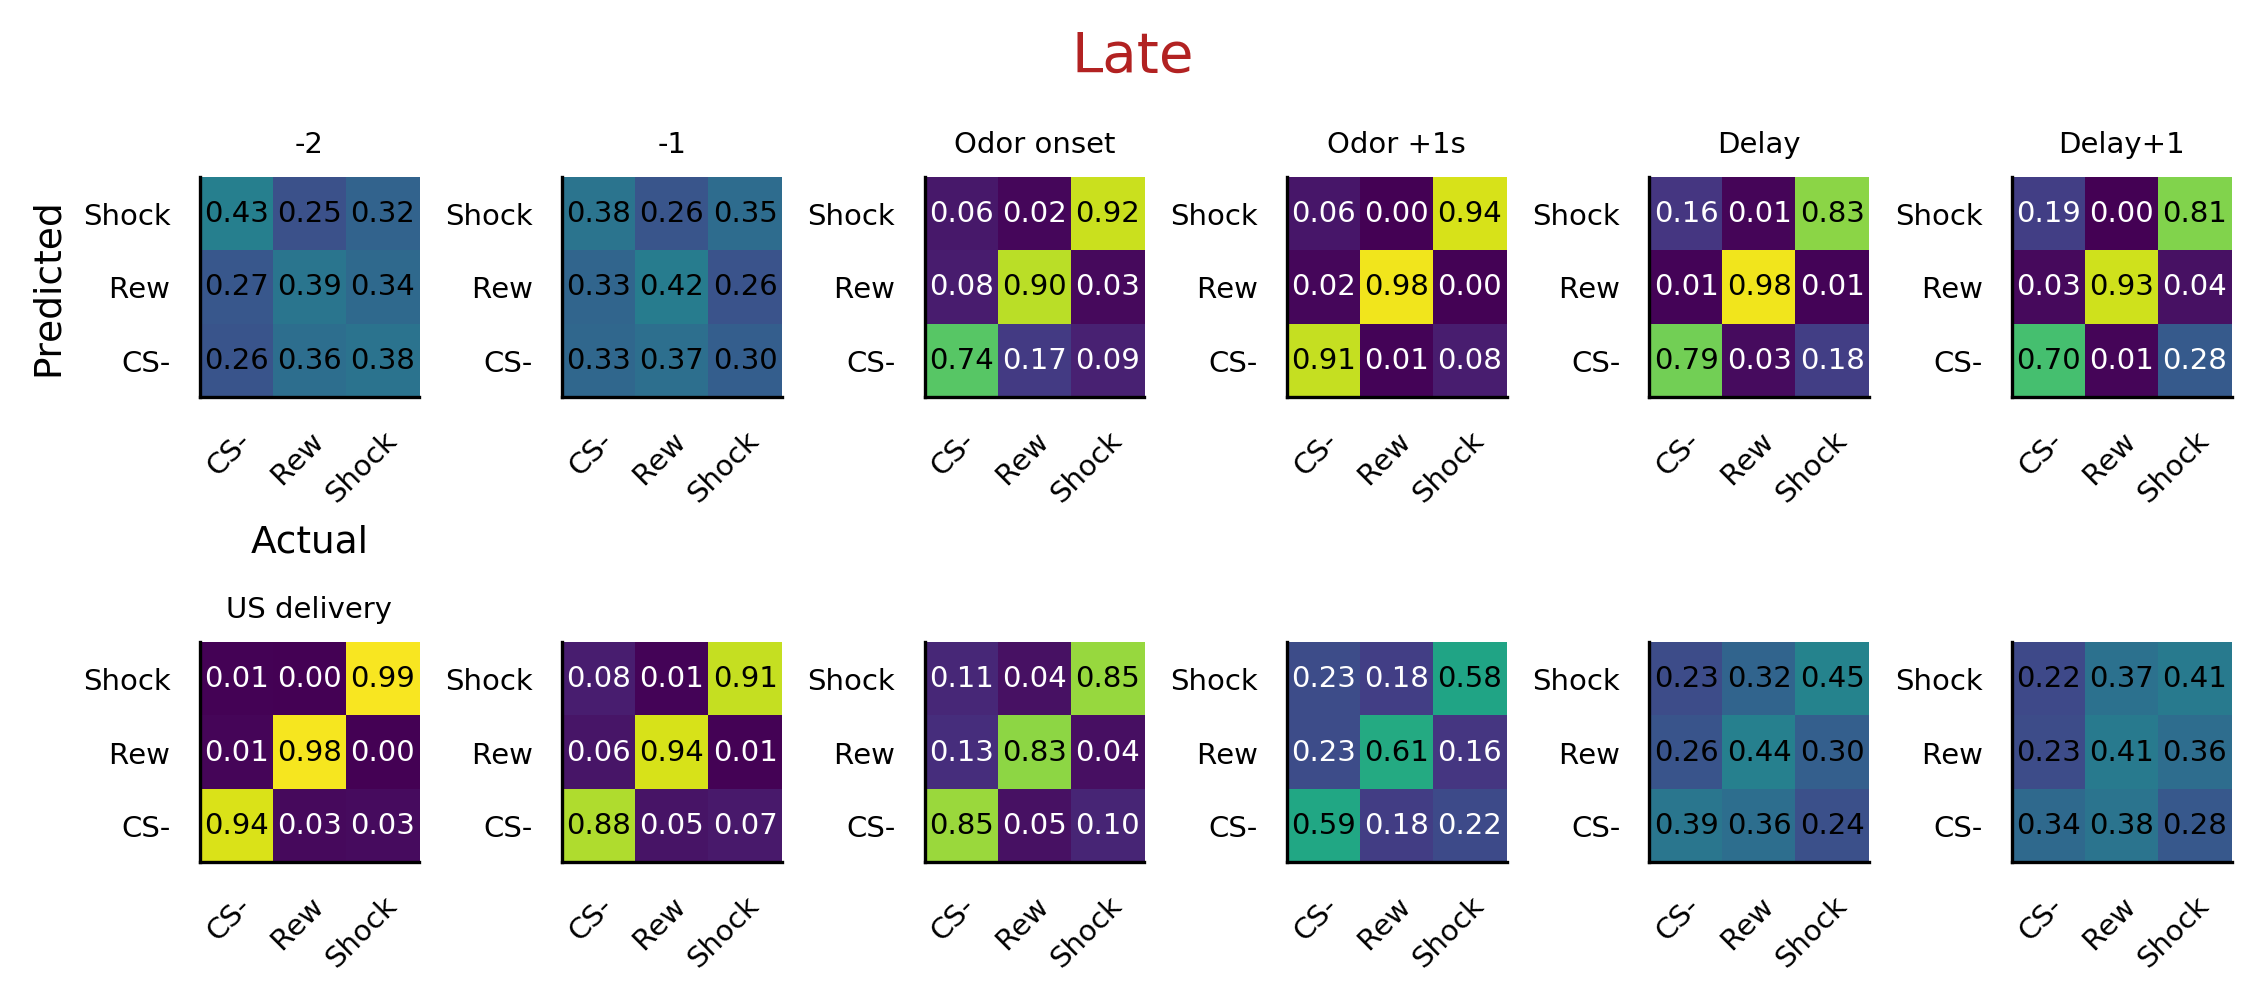

In [83]:
# plot 'em all

fig, ((ax1, ax2, ax3, ax4, ax5,ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(7.5, 3))

for i,la in zip(range(1,13),['-2','-1','Odor onset','Odor +1s','Delay','Delay+1','US delivery','','','','','']):
    im = heatmap(3.*heatmaps_post[i]/np.sum(heatmaps_post[i]),(['CS-','Rew', 'Shock']),
                 (['CS-','Rew', 'Shock']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(la)
ax1.set_xlabel('Actual',fontsize=9)
ax1.set_ylabel('Predicted',fontsize=9)
pl.suptitle("Late",fontsize=13.5,color='firebrick',y=1.08)
pl.tight_layout()
pl.show()
#fig.savefig('../img/%s_vhpc_pre_1s.jpg'%NOTEBOOK_NAME)

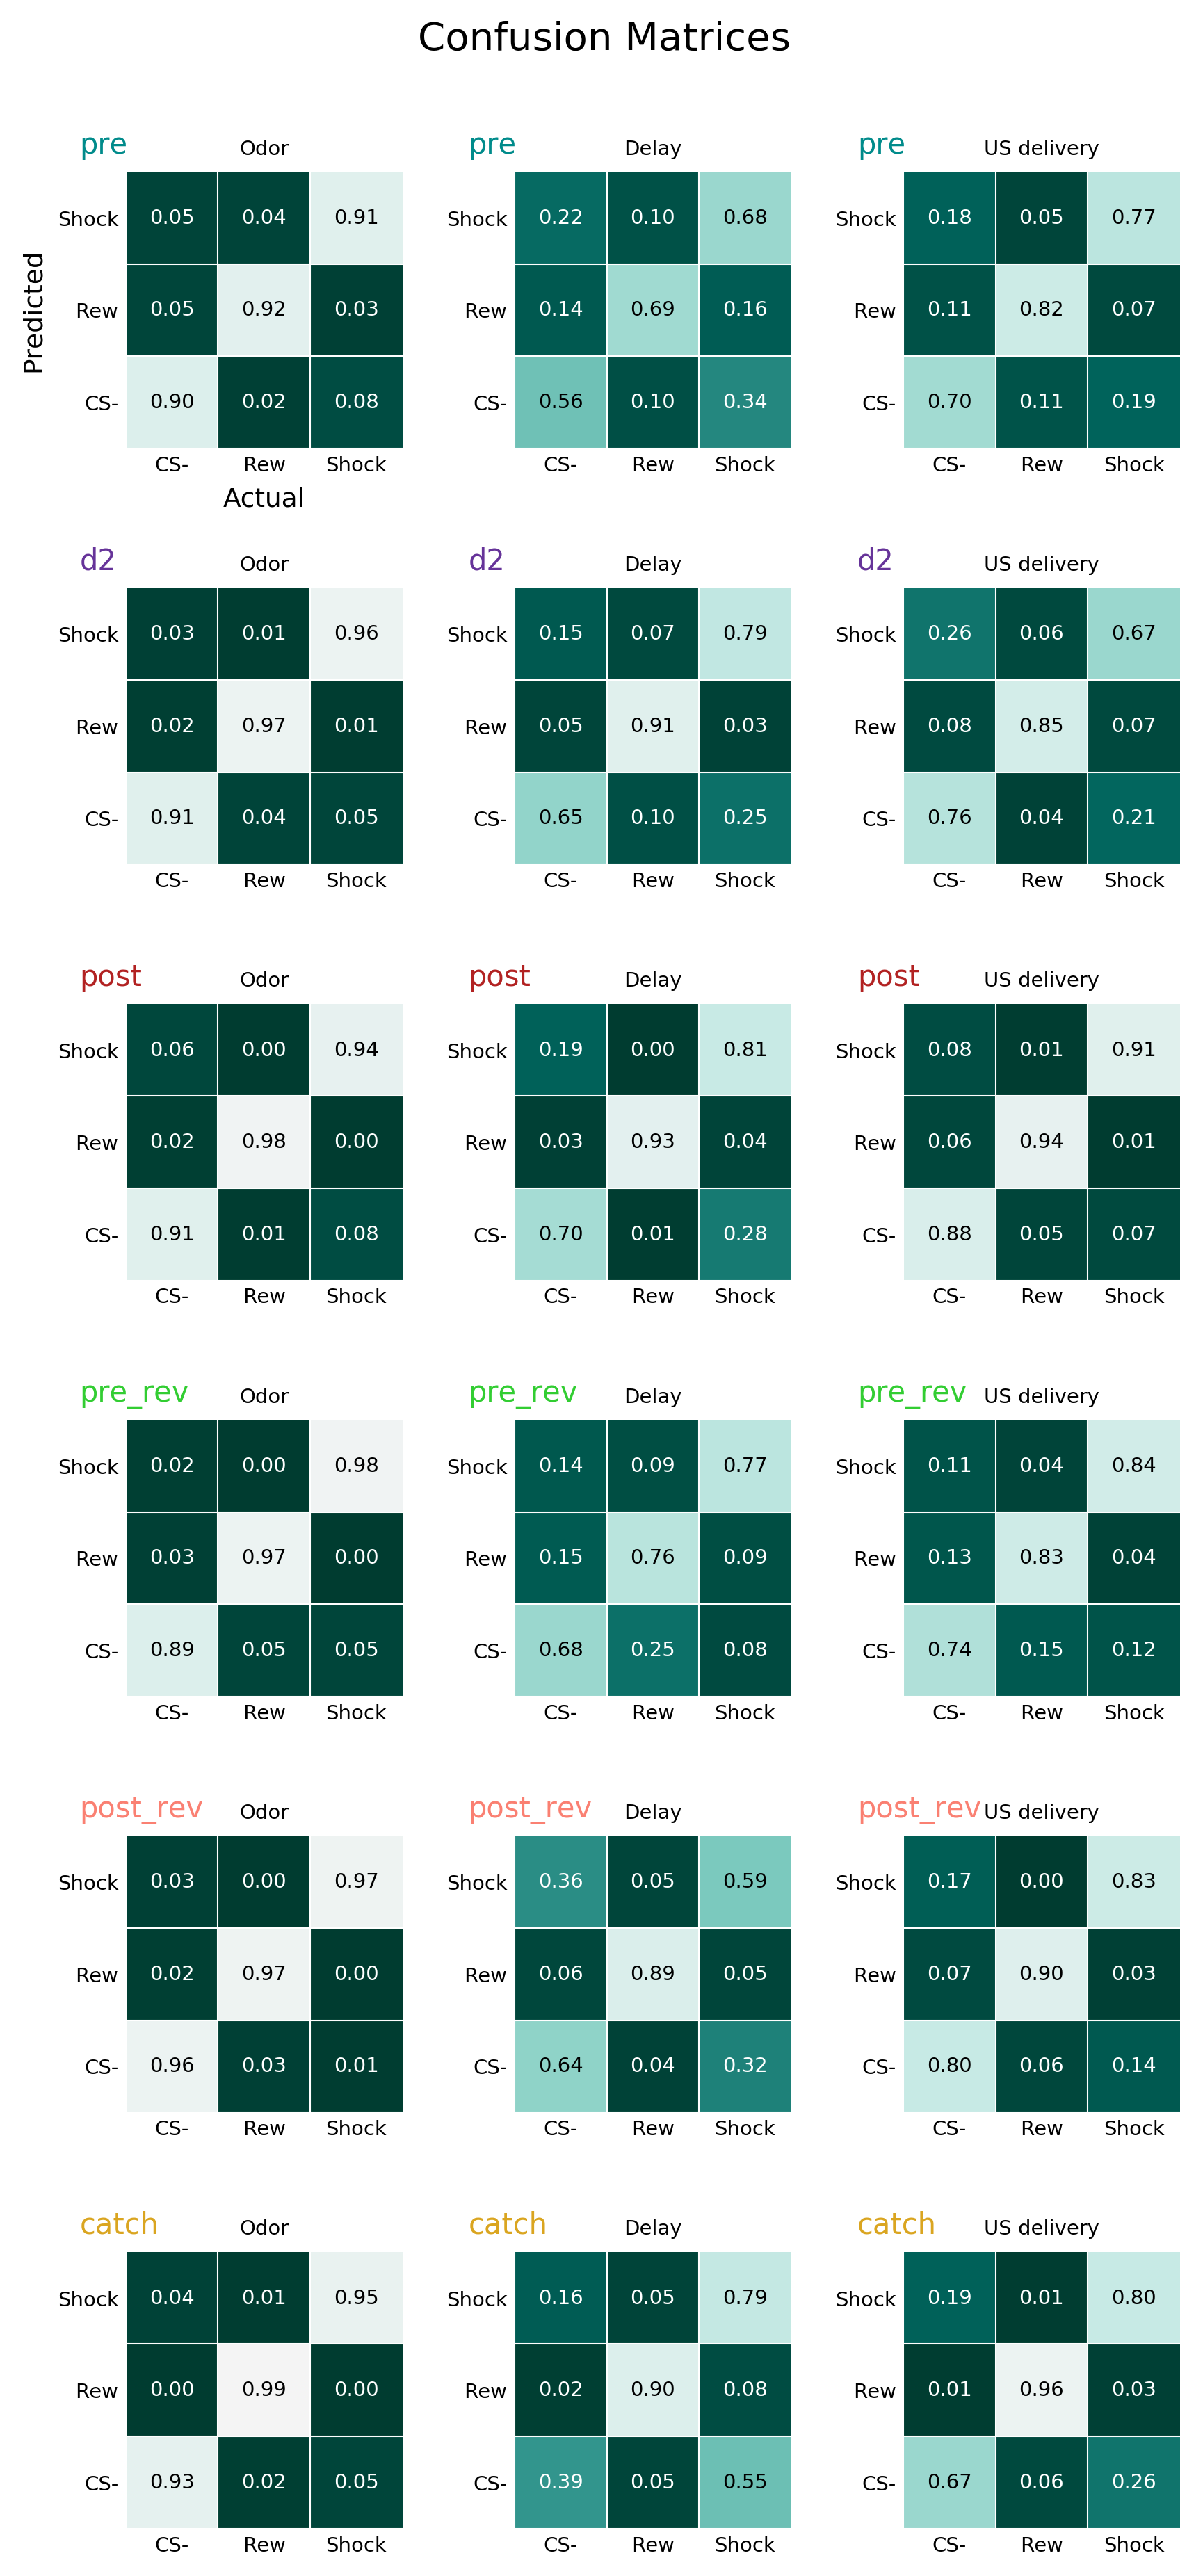

In [207]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap=cm.get_cmap('BrBG')
newcolors=cmap(np.linspace(1, .5, 128))
new_cmap = ListedColormap(newcolors)

fig, ((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11),(ax12,ax13,ax14),(ax15,ax16,ax17)) = pl.subplots(6, 3, figsize=(6, 12))

for sess,x in zip(sessions,range(len(sessions))):
    for i,tb,la in zip(range(3),[4,6,8],['Odor','Delay','US delivery']):
        y = 3*x+i
        im = heatmap(3.*eval("heatmaps_%s[tb]"%sess)/np.sum(eval("heatmaps_%s[tb]"%sess)),(['CS-','Rew', 'Shock']),
                     (['CS-','Rew', 'Shock']), ax=eval('ax%s'%y),vmin=0,vmax=1,cmap=new_cmap)
        annotate_heatmap(im, valfmt="{x:.2f}", size=7)
        eval('ax%s'%y).set_title(la)
        eval("ax%s.text"%y)(-1,2.7,sess,ha='left',fontsize=10,color=dark_co[x])
        eval("ax%s.set_xlabel"%0)('Actual',fontsize=9)
        eval("ax%s.set_ylabel"%0)('Predicted',fontsize=9)
pl.suptitle('Confusion Matrices',fontsize=13.5,y=1.03)
pl.tight_layout(pad=3)
pl.show()
#fig.savefig('../img/%s_vhpc_pre_1s.jpg'%NOTEBOOK_NAME)

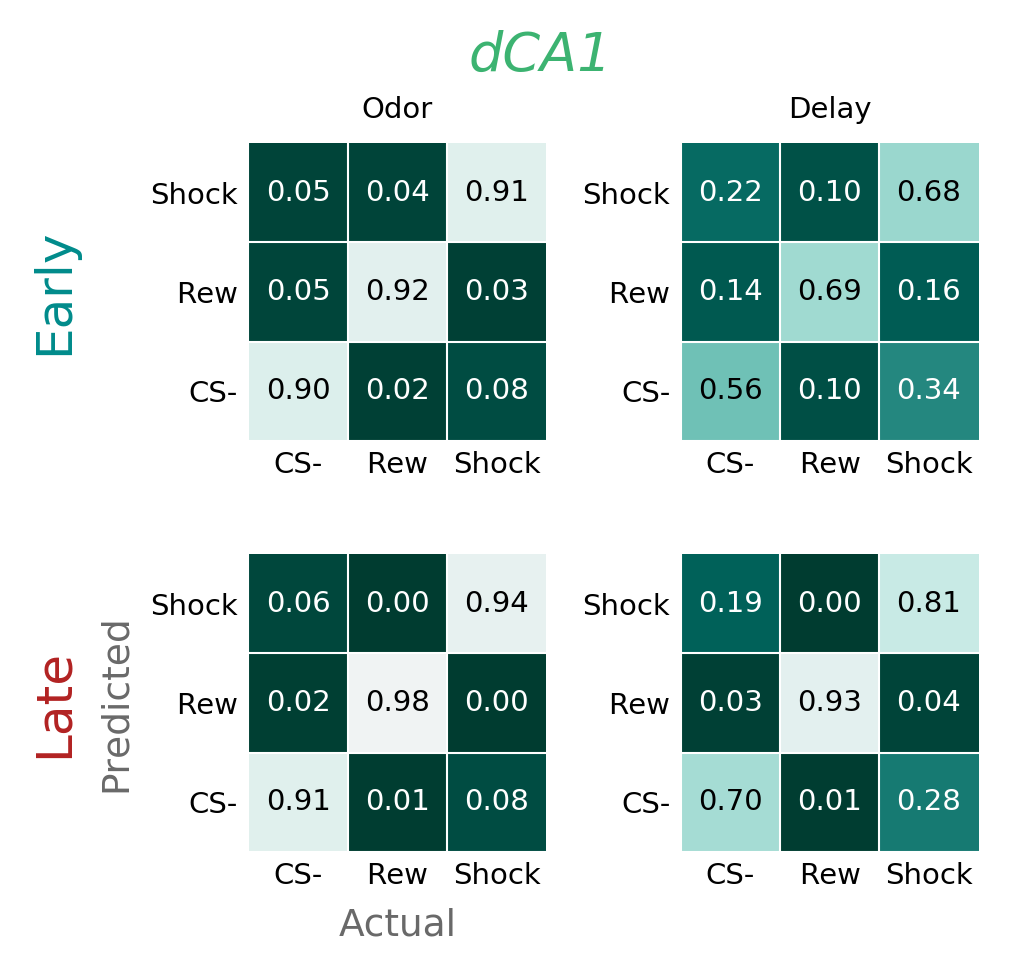

In [212]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap=cm.get_cmap('BrBG')
newcolors=cmap(np.linspace(1, .5, 128))
new_cmap = ListedColormap(newcolors)

fig, ((ax0,ax1),(ax2,ax3)) = pl.subplots(2, 2, figsize=(3.2, 3.2))

for sess,x,c in zip(['pre','post'],range(2),[0,2]):
    for i,tb,la in zip(range(2),[4,6],['Odor','Delay']):
        y = 2*x+i
        im = heatmap(3.*eval("heatmaps_%s[tb]"%sess)/np.sum(eval("heatmaps_%s[tb]"%sess)),(['CS-','Rew', 'Shock']),
                     (['CS-','Rew', 'Shock']), ax=eval('ax%s'%y),vmin=0,vmax=1,cmap=new_cmap)
        annotate_heatmap(im, valfmt="{x:.2f}", size=7)
        eval('ax%s'%i).set_title(la)
        eval("ax%s.set_xlabel"%2)('Actual',fontsize=9,color='dimgrey')
        eval("ax%s.set_ylabel"%2)('Predicted',fontsize=9,color='dimgrey')
ax0.text(-2.7,1,'Early',ha='left',va='center',fontsize=12,color=dark_co[0],rotation=90)
ax2.text(-2.7,1,'Late',ha='left',va='center',fontsize=12,color=dark_co[2],rotation=90)
pl.suptitle('dCA1',fontsize=13,y=1.01,color='mediumseagreen', fontstyle='italic')
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_confusion PrPo.pdf'%NOTEBOOK_NAME)

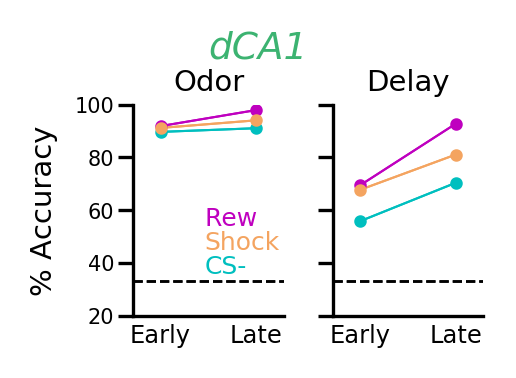

In [324]:
fig,ax = pl.subplots(1,2,figsize=(1.8,1.2),sharey=True)
v={}
d={}
loops=10
expectations = 'pre','post'

# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Trace'),(range(2))):
        ax[x].plot([p for p in (.4,1.1)],[(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100 for ex in expectations],color='c')
        ax[x].plot([p for p in (.4,1.1)],[3.*eval("heatmaps_%s[tb][1][1]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex))*100 for ex in expectations],color='m')
        ax[x].plot([p for p in (.4,1.1)],[3.*eval("heatmaps_%s[tb][2][2]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex))*100 for ex in expectations],color='sandybrown')            
            
for ex,z in zip(['pre','post'],(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='c',markersize=2,label='CS-')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='c')  
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='m',markersize=2,label='Rew')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='m')
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='sandybrown',markersize=2,label='Shock')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='sandybrown')  

            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('% Accuracy')
            ax[x].set_ylim(20,100)
            ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=.95)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Early','Late'],fontsize=5.8)
            
#ax[0].legend()

pl.suptitle('dCA1',fontsize=9,color='mediumseagreen',fontstyle='italic',y=1)
ax[0].text(.72,54,'Rew',color='m',fontsize=6.)
ax[0].text(.72,45,'Shock',color='sandybrown',fontsize=6.)
ax[0].text(.72,36,'CS-',color='c',fontsize=6.)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_confusion_lines.pdf'%NOTEBOOK_NAME)

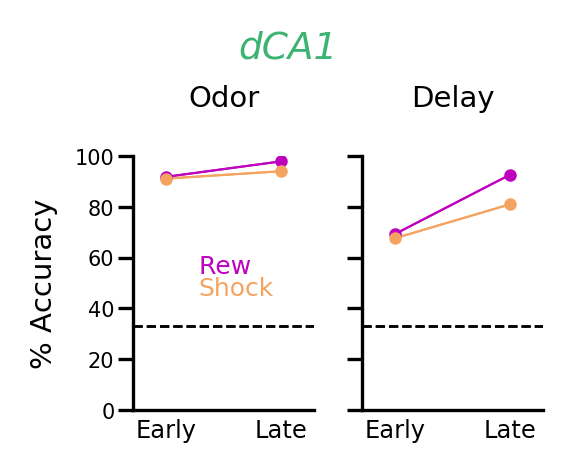

In [213]:
fig,ax = pl.subplots(1,2,figsize=(2,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'pre','post'

# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
        #ax[x].plot([p for p in (.4,1.1)],[(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100 for ex in expectations],color='c')
        ax[x].plot([p for p in (.4,1.1)],[3.*eval("heatmaps_%s[tb][1][1]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex))*100 for ex in expectations],color='m')
        ax[x].plot([p for p in (.4,1.1)],[3.*eval("heatmaps_%s[tb][2][2]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex))*100 for ex in expectations],color='sandybrown')            
            
for ex,z in zip(['pre','post'],(.4,1.1)):
    for tb,tb_la,x in zip((4,6),('Odor','Delay'),(range(2))):
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            #ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='c',markersize=2,label='CS-')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][0][0]"%ex)/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='c')  
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='m',markersize=2,label='Rew')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][1][1]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='m')
            #v[ex] = np.array(np.std(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100/(np.sqrt(loops-1)))
            ax[x].plot(z, np.mean(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100, 'o', color='sandybrown',markersize=2,label='Shock')
            #ax[x].errorbar(z, (np.mean(3.*eval("heatmaps_%s[tb][2][2]"%(ex))/np.sum(eval("heatmaps_%s[tb]"%ex)))*100),yerr=v[ex],color='sandybrown')  

            ax[x].tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
            ax[x].tick_params(axis='y',pad=1) # labels along the bottom edge are off
            ax[0].set_ylabel('% Accuracy')
            ax[x].set_ylim(0,100)
            ax[x].hlines(33, 0.2,1.3, color='k', lw=.6, linestyles='dashed')
            ax[x].set_title(tb_la,y=1.1)
            ax[x].set_xlim(0.2,1.3)
            ax[x].set_xticks((.4,1.1))
            ax[x].set_xticklabels(['Early','Late'],fontsize=5.8)
            
#ax[0].legend()

pl.suptitle('dCA1',fontsize=9,color='mediumseagreen',fontstyle='italic',y=1.01)
ax[0].text(.6,54,'Rew',color='m',fontsize=6.)
ax[0].text(.6,45,'Shock',color='sandybrown',fontsize=6.)
#ax[0].text(.6,36,'CS-',color='c',fontsize=6.)
fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_confusion_lines.pdf'%NOTEBOOK_NAME)

# Across time bin decoding

In [12]:
#trying to use different trials for different time bins
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross_distinct(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_train_a = np.random.permutation(np.where(labels_t[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels_t[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]      
        
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_dt, labels_dt)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_dT, labels_dT)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [36]:
%%time
n_loops=15
for t in range (13):
    for c in range (13):
        for label in non_catch_labels:
            exec('scores_gmin_tb_distinct_%s_VS_%s_%s = {}'%(t,c,label))
            for sess in sessions[:-1]:
                print sess,t,c,label,
                print' ',
                eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s_%s'%(label,sess)),
                      n_cells=g_min) for i in range(n_loops)]]

pre 0 0 rwVSsh   d2 0 0 rwVSsh   post 0 0 rwVSsh   pre_rev 0 0 rwVSsh   post_rev 0 0 rwVSsh   pre 0 0 rwVScsm   d2 0 0 rwVScsm   post 0 0 rwVScsm   pre_rev 0 0 rwVScsm   post_rev 0 0 rwVScsm   pre 0 0 shVScsm   d2 0 0 shVScsm   post 0 0 shVScsm   pre_rev 0 0 shVScsm   post_rev 0 0 shVScsm   pre 0 1 rwVSsh   d2 0 1 rwVSsh   post 0 1 rwVSsh   pre_rev 0 1 rwVSsh   post_rev 0 1 rwVSsh   pre 0 1 rwVScsm   d2 0 1 rwVScsm   post 0 1 rwVScsm   pre_rev 0 1 rwVScsm   post_rev 0 1 rwVScsm   pre 0 1 shVScsm   d2 0 1 shVScsm   post 0 1 shVScsm   pre_rev 0 1 shVScsm   post_rev 0 1 shVScsm   pre 0 2 rwVSsh   d2 0 2 rwVSsh   post 0 2 rwVSsh   pre_rev 0 2 rwVSsh   post_rev 0 2 rwVSsh   pre 0 2 rwVScsm   d2 0 2 rwVScsm   post 0 2 rwVScsm   pre_rev 0 2 rwVScsm   post_rev 0 2 rwVScsm   pre 0 2 shVScsm   d2 0 2 shVScsm   post 0 2 shVScsm   pre_rev 0 2 shVScsm   post_rev 0 2 shVScsm   pre 0 3 rwVSsh   d2 0 3 rwVSsh   post 0 3 rwVSsh   pre_rev 0 3 rwVSsh   post_rev 0 3 rwVSsh   pre 0 3 rwVScsm   d2 0 3 rwVSc

In [37]:
%%time
n_loops=15
for t in range (13):
    for c in range (13):
        for label in catch_labels:
            exec('scores_gmin_tb_distinct_%s_VS_%s_%s = {}'%(t,c,label))
            for sess in 'catch',:
                print sess,t,c,label,
                print' ',
                eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s_%s'%(label,sess)),
                      n_cells=g_min_catch) for i in range(n_loops)]]
        for label in non_catch_labels:
            for sess in 'catch',:
                print sess,t,c,label,
                print' ',
                eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess] = np.r_[[do_test_cross_distinct(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('labels_%s_%s'%(label,sess)), eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s_%s'%(label,sess)),
                      n_cells=g_min_catch) for i in range(n_loops)]]

catch 0 0 rwndVSshnd   catch 0 0 rwVSrwnd   catch 0 0 rwndVScsm   catch 0 0 shVSshnd   catch 0 0 shndVScsm   catch 0 0 rwVSsh   catch 0 0 rwVScsm   catch 0 0 shVScsm   catch 0 1 rwndVSshnd   catch 0 1 rwVSrwnd   catch 0 1 rwndVScsm   catch 0 1 shVSshnd   catch 0 1 shndVScsm   catch 0 1 rwVSsh   catch 0 1 rwVScsm   catch 0 1 shVScsm   catch 0 2 rwndVSshnd   catch 0 2 rwVSrwnd   catch 0 2 rwndVScsm   catch 0 2 shVSshnd   catch 0 2 shndVScsm   catch 0 2 rwVSsh   catch 0 2 rwVScsm   catch 0 2 shVScsm   catch 0 3 rwndVSshnd   catch 0 3 rwVSrwnd   catch 0 3 rwndVScsm   catch 0 3 shVSshnd   catch 0 3 shndVScsm   catch 0 3 rwVSsh   catch 0 3 rwVScsm   catch 0 3 shVScsm   catch 0 4 rwndVSshnd   catch 0 4 rwVSrwnd   catch 0 4 rwndVScsm   catch 0 4 shVSshnd   catch 0 4 shndVScsm   catch 0 4 rwVSsh   catch 0 4 rwVScsm   catch 0 4 shVScsm   catch 0 5 rwndVSshnd   catch 0 5 rwVSrwnd   catch 0 5 rwndVScsm   catch 0 5 shVSshnd   catch 0 5 shndVScsm   catch 0 5 rwVSsh   catch 0 5 rwVScsm   catch 0 5 sh

In [38]:
for t in range (13):
    for label in non_catch_labels:
        exec('distinct%s_%s = {}'%(t,label))
        for sess in sessions:
            exec("distinct%s_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('distinct%s_%s'%(t,label))[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess]).mean(0)[0])
             
#for catch trials    
for t in range (13):
    for label in catch_labels:
        exec('distinct%s_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("distinct%s_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('distinct%s_%s'%(t,label))[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess]).mean(0)[0])

In [39]:
for t in range (13):
    for label in non_catch_labels:
        exec('distinct%s_wilcox_%s = {}'%(t,label))
        for sess in sessions:
            exec("distinct%s_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s_%s[sess][:,0]]"%(t,c,label))
                eval('distinct%s_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_wilcox_%s'%(t,label))[sess],range(len(eval('distinct%s_wilcox_%s'%(t,label))[sess]))):
                exec("distinct%s_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values
                
for t in range (13):
    for label in catch_labels:
        exec('distinct%s_wilcox_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("distinct%s_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s_%s[sess][:,0]]"%(t,c,label))
                eval('distinct%s_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_wilcox_%s'%(t,label))[sess],range(len(eval('distinct%s_wilcox_%s'%(t,label))[sess]))):
                exec("distinct%s_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


In [40]:
for label in non_catch_labels:
    exec("distinct_%s={}"%(label))
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess],\
        distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess], distinct8_%s[sess],\
        distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_%s[sess]"%label)])
             
for label in catch_labels:
    exec("distinct_%s={}"%(label))
    for sess in 'catch',:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess],\
        distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess], distinct8_%s[sess],\
        distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_%s[sess]"%label)])

In [41]:
for label in non_catch_labels:
    exec("distinct_wilcox_%s={}"%(label))
    for sess in sessions:
        exec("distinct_wilcox_%s[sess]=(distinct0_wilcox_%s[sess], distinct1_wilcox_%s[sess], distinct2_wilcox_%s[sess], distinct3_wilcox_%s[sess],\
        distinct4_wilcox_%s[sess], distinct5_wilcox_%s[sess], distinct6_wilcox_%s[sess], distinct7_wilcox_%s[sess], distinct8_wilcox_%s[sess],\
        distinct9_wilcox_%s[sess], distinct10_wilcox_%s[sess], distinct11_wilcox_%s[sess], distinct12_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_wilcox_%s[sess]"%label)])
             
for label in catch_labels:
    exec("distinct_wilcox_%s={}"%(label))
    for sess in 'catch',:
        exec("distinct_wilcox_%s[sess]=(distinct0_wilcox_%s[sess], distinct1_wilcox_%s[sess], distinct2_wilcox_%s[sess], distinct3_wilcox_%s[sess],\
        distinct4_wilcox_%s[sess], distinct5_wilcox_%s[sess], distinct6_wilcox_%s[sess], distinct7_wilcox_%s[sess], distinct8_wilcox_%s[sess],\
        distinct9_wilcox_%s[sess], distinct10_wilcox_%s[sess], distinct11_wilcox_%s[sess], distinct12_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_wilcox_%s[sess]"%label)])

In [42]:
#now just get the overall mean for forward and reverse train/test directions

for t in range (13):
    for label in non_catch_labels:
        exec('distinct%s_mean_%s = {}'%(t,label))
        for sess in sessions:
            exec("distinct%s_mean_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('distinct%s_mean_%s'%(t,label))[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess]).mean())
             
#for catch trials    
for t in range (13):
    for label in catch_labels:
        exec('distinct%s_mean_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("distinct%s_mean_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('distinct%s_mean_%s'%(t,label))[sess].insert(c,(eval('scores_gmin_tb_distinct_%s_VS_%s_%s'%(t,c,label))[sess]).mean())

In [43]:
for label in non_catch_labels:
    exec("distinct_mean_%s={}"%(label))
    for sess in sessions:
        exec("distinct_mean_%s[sess]=(distinct0_mean_%s[sess], distinct1_mean_%s[sess], distinct2_mean_%s[sess], distinct3_mean_%s[sess],\
        distinct4_mean_%s[sess], distinct5_mean_%s[sess], distinct6_mean_%s[sess], distinct7_mean_%s[sess], distinct8_mean_%s[sess],\
        distinct9_mean_%s[sess], distinct10_mean_%s[sess], distinct11_mean_%s[sess], distinct12_mean_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_mean_%s[sess]"%label)])
             
for label in catch_labels:
    exec("distinct_mean_%s={}"%(label))
    for sess in 'catch',:
        exec("distinct_mean_%s[sess]=(distinct0_mean_%s[sess], distinct1_mean_%s[sess], distinct2_mean_%s[sess], distinct3_mean_%s[sess],\
        distinct4_mean_%s[sess], distinct5_mean_%s[sess], distinct6_mean_%s[sess], distinct7_mean_%s[sess], distinct8_mean_%s[sess],\
        distinct9_mean_%s[sess], distinct10_mean_%s[sess], distinct11_mean_%s[sess], distinct12_mean_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_mean_%s[sess]"%label)])

In [44]:
for t in range (13):
    for label in non_catch_labels:
        exec('distinct%s_mean_wilcox_%s = {}'%(t,label))
        for sess in sessions:
            exec("distinct%s_mean_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s_%s[sess].mean(1)]"%(t,c,label))
                eval('distinct%s_mean_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_mean_wilcox_%s'%(t,label))[sess],range(len(eval('distinct%s_mean_wilcox_%s'%(t,label))[sess]))):
                exec("distinct%s_mean_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values
                
for t in range (13):
    for label in catch_labels:
        exec('distinct%s_mean_wilcox_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("distinct%s_mean_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in scores_gmin_tb_distinct_%s_VS_%s_%s[sess].mean(1)]"%(t,c,label))
                eval('distinct%s_mean_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_mean_wilcox_%s'%(t,label))[sess],range(len(eval('distinct%s_mean_wilcox_%s'%(t,label))[sess]))):
                exec("distinct%s_mean_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values

In [45]:
for label in non_catch_labels:
    exec("distinct_mean_wilcox_%s={}"%(label))
    for sess in sessions:
        exec("distinct_mean_wilcox_%s[sess]=(distinct0_mean_wilcox_%s[sess], distinct1_mean_wilcox_%s[sess], distinct2_mean_wilcox_%s[sess], distinct3_mean_wilcox_%s[sess],\
        distinct4_mean_wilcox_%s[sess], distinct5_mean_wilcox_%s[sess], distinct6_mean_wilcox_%s[sess], distinct7_mean_wilcox_%s[sess], distinct8_mean_wilcox_%s[sess],\
        distinct9_mean_wilcox_%s[sess], distinct10_mean_wilcox_%s[sess], distinct11_mean_wilcox_%s[sess], distinct12_mean_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_mean_wilcox_%s[sess]"%label)])
             
for label in catch_labels:
    exec("distinct_mean_wilcox_%s={}"%(label))
    for sess in 'catch',:
        exec("distinct_mean_wilcox_%s[sess]=(distinct0_mean_wilcox_%s[sess], distinct1_mean_wilcox_%s[sess], distinct2_mean_wilcox_%s[sess], distinct3_mean_wilcox_%s[sess],\
        distinct4_mean_wilcox_%s[sess], distinct5_mean_wilcox_%s[sess], distinct6_mean_wilcox_%s[sess], distinct7_mean_wilcox_%s[sess], distinct8_mean_wilcox_%s[sess],\
        distinct9_mean_wilcox_%s[sess], distinct10_mean_wilcox_%s[sess], distinct11_mean_wilcox_%s[sess], distinct12_mean_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("distinct_mean_wilcox_%s[sess]"%label)])

In [46]:
session_labels = 'Early','Day2','Late','Rev Early','Rev Late','Rev Catch'
session_colors = 'maroon','maroon','maroon','midnightblue','midnightblue','midnightblue'

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


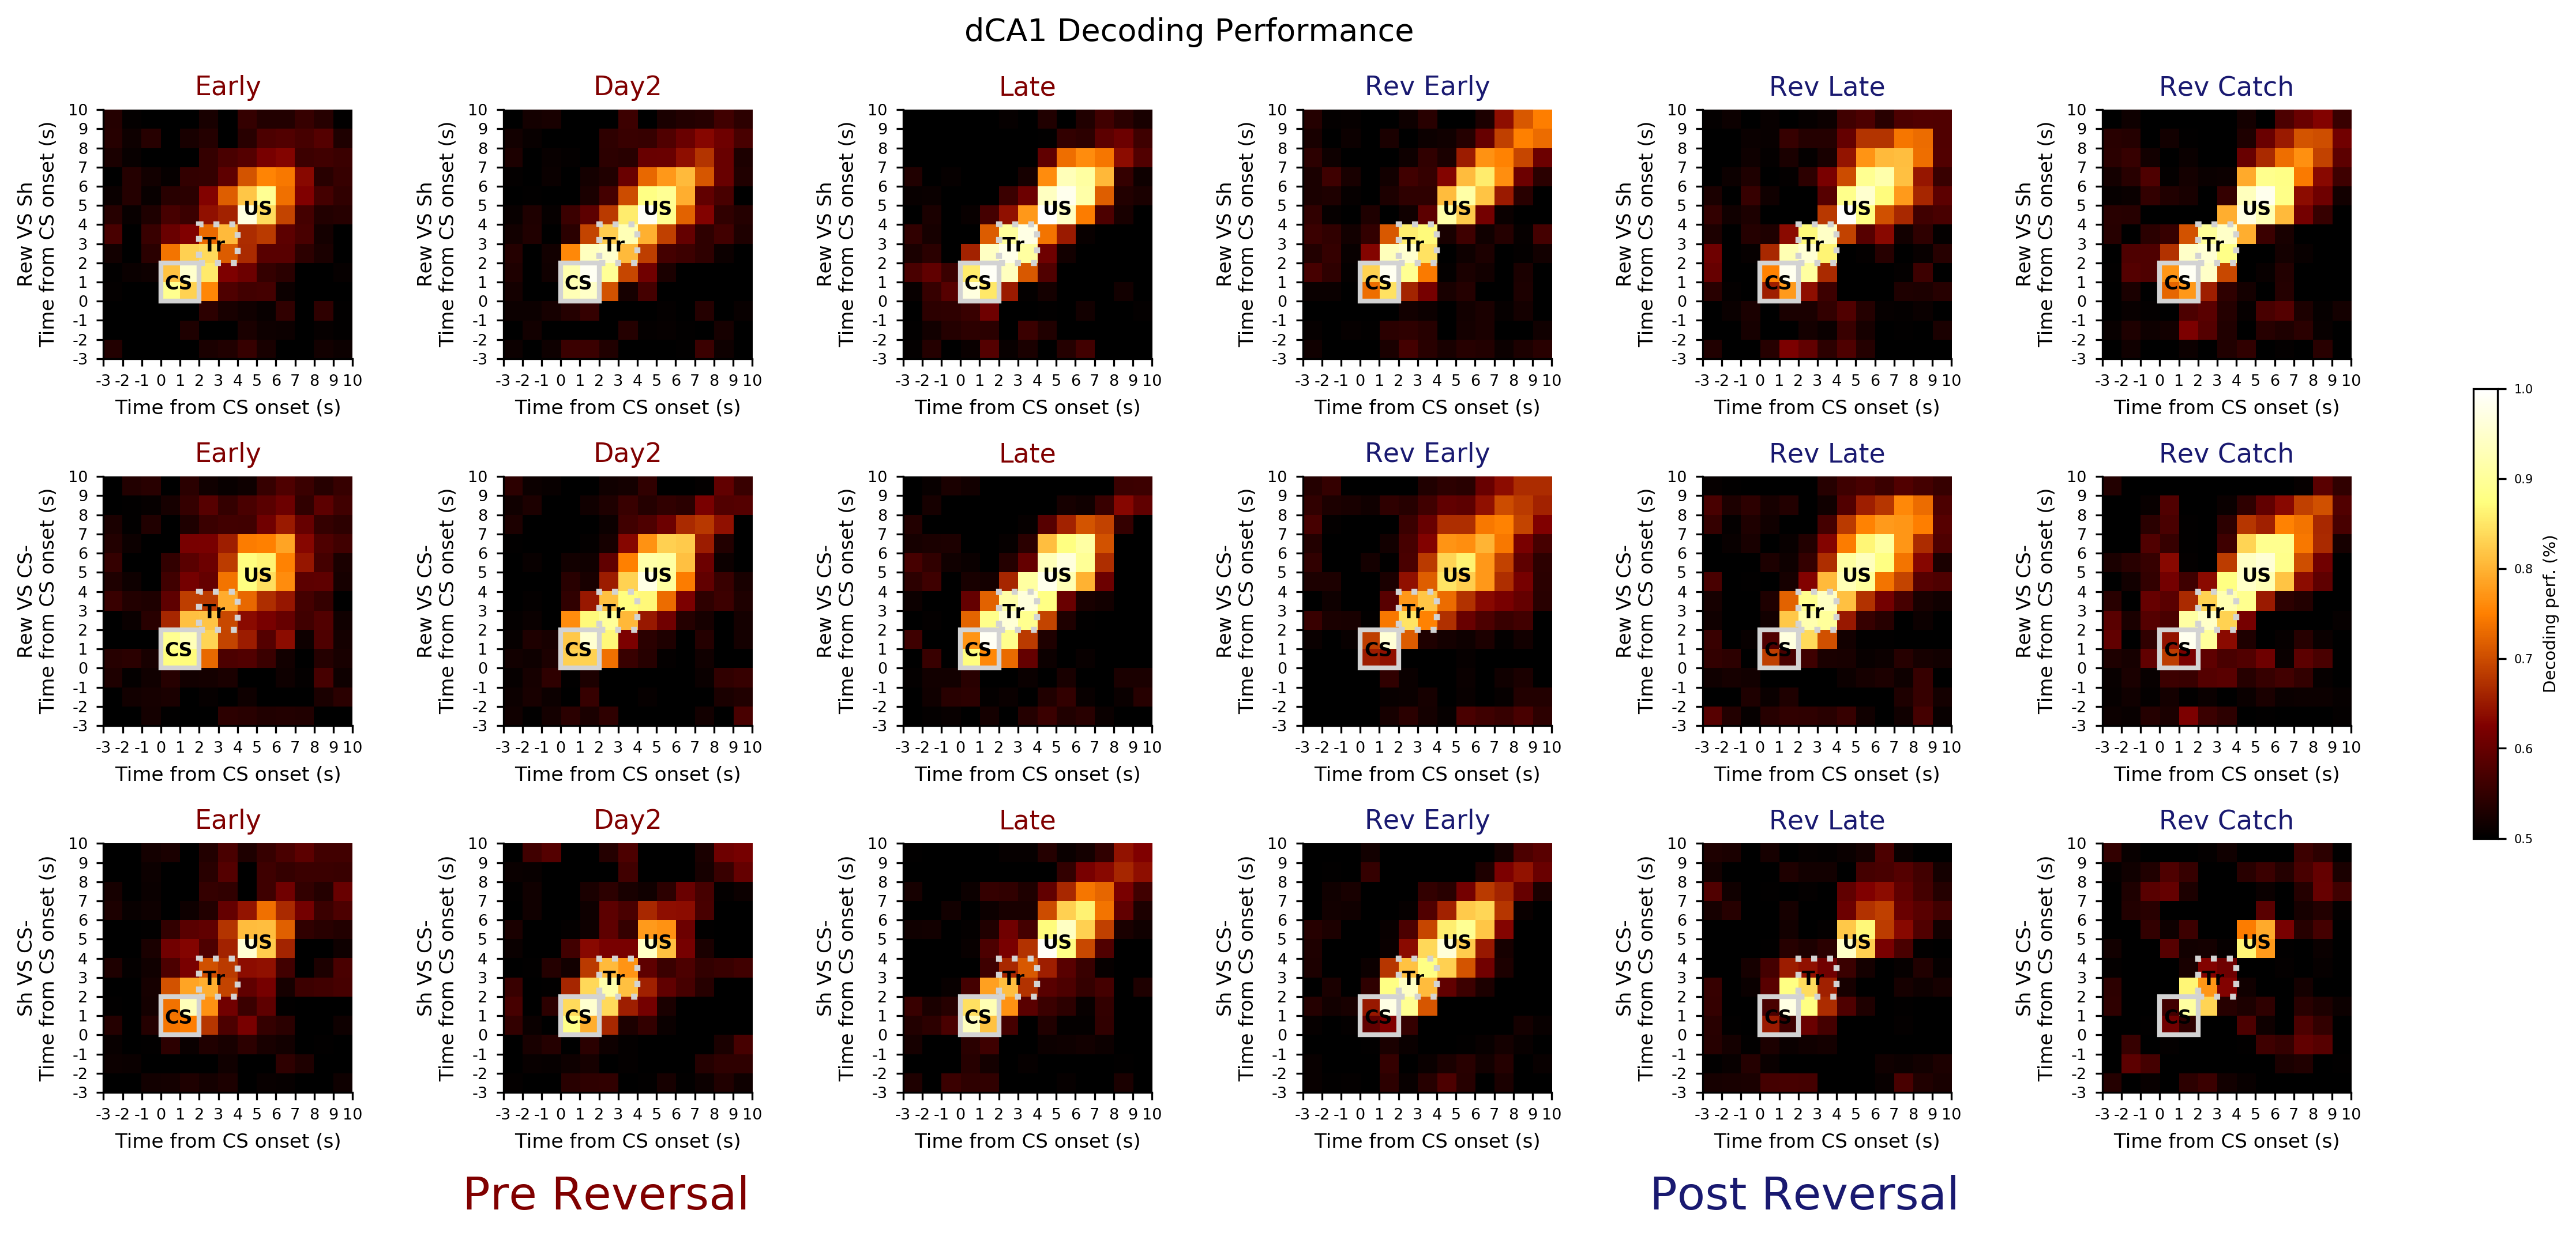

In [47]:
import matplotlib.patches as patches

fig, ax = pl.subplots(3, 6, figsize=(14, 6.5))#, sharex=True, sharey=True)

for label,c,mm,cmap,lab in zip(non_catch_labels,range(3),([.5,1],[.5,1],[.5,1]),['afmhot','afmhot','afmhot'],['Rew VS Sh','Rew VS CS-','Sh VS CS-']):
    for sess,x in zip(sessions,range(len(sessions))):
        im = ax[c][x].imshow(eval("distinct_mean_%s[sess]"%label),origin='lower',interpolation='nearest',vmin=mm[0],vmax=mm[1],cmap=cmap)
        ax[c][x].set_xticks(np.arange(-.5,13,1))
        ax[c][x].set_yticks(np.arange(-.5,13,1))
        #ax[c][x].set_ylim(-.5, 12.5)
        #ax[c][x].set_xlim(-.5, 12.5)
        ax[c][x].set_xticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_yticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_ylabel(lab+'\nTime from CS onset (s)', fontsize=8.2)
        ax[c][x].set_xlabel('Time from CS onset (s)', fontsize=8.2)
        ax[c][x].set_title(session_labels[x],fontsize=11,color=session_colors[x])
        ax[c][x].tick_params(length=3)
# Add the patch to the Axes
for x in range(6):
    for c in range(3):
        CS = patches.Rectangle((2.5,2.5),2,2,linewidth=2,edgecolor='lightgrey',facecolor='none')
        Tr = patches.Rectangle((4.5,4.5),2,2,linewidth=2.5,edgecolor='lightgrey',facecolor='none',linestyle=':')
        ax[c][x].add_patch(CS)
        ax[c][x].add_patch(Tr)
        ax[c][x].text(2.7,3.1,"CS",fontsize=8, weight='bold', color='k')
        ax[c][x].text(4.7,5.1,"Tr",fontsize=8, weight='bold', color='k')
        ax[c][x].text(6.8,7,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance',y=1.03,fontsize=13)

fig.text(x=.2,y=-0.03,s='Pre Reversal',fontsize=19, color='maroon')
fig.text(x=.69,y=-0.03,s='Post Reversal',fontsize=19, color='midnightblue')

cax = fig.add_axes([1.03,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.jpg'%NOTEBOOK_NAME)

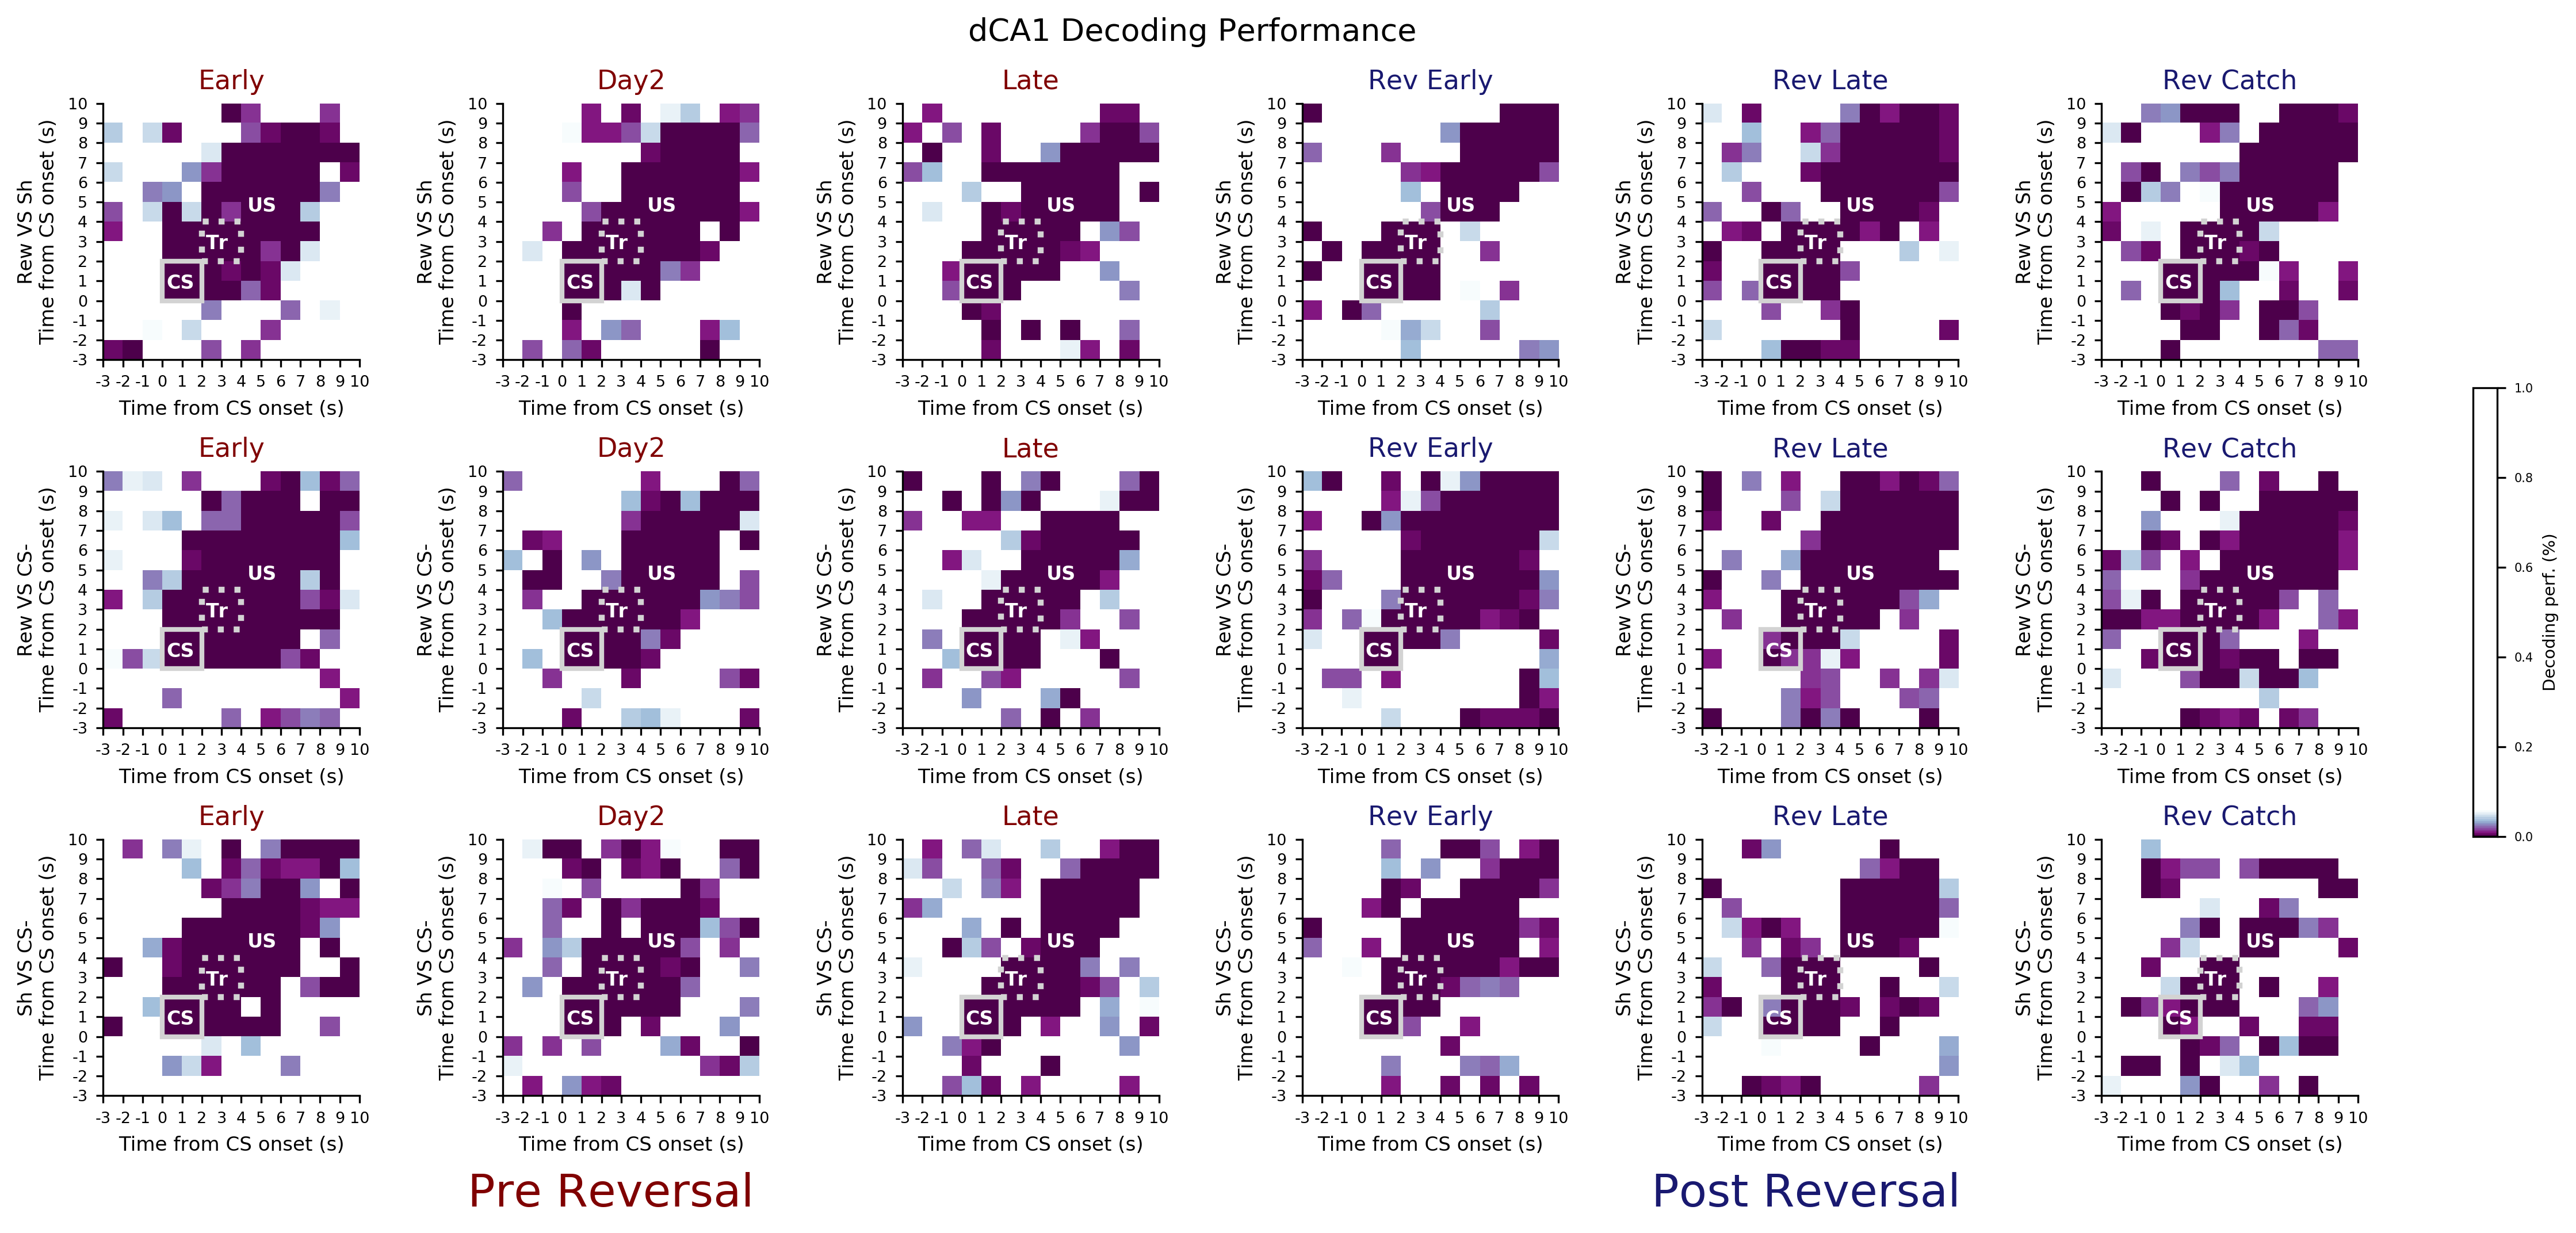

In [48]:
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
black = np.array([0, 0, 0, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(3, 6, figsize=(14, 6.5))#, sharex=True, sharey=True)

for label,c,mm,lab in zip(non_catch_labels,range(3),([0,1],[0,1],[0,1]),['Rew VS Sh','Rew VS CS-','Sh VS CS-']):
    for sess,x in zip(sessions,range(len(sessions))):
        im = ax[c][x].imshow(eval("distinct_wilcox_%s[sess]"%label),origin='lower',interpolation='nearest',vmin=mm[0],vmax=mm[1],cmap=newcmap)
        ax[c][x].set_xticks(np.arange(-.5,13,1))
        ax[c][x].set_yticks(np.arange(-.5,13,1))
        #ax[c][x].set_ylim(-.5, 12.5)
        #ax[c][x].set_xlim(-.5, 12.5)
        ax[c][x].set_xticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_yticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_ylabel(lab+'\nTime from CS onset (s)', fontsize=8.2)
        ax[c][x].set_xlabel('Time from CS onset (s)', fontsize=8.2)
        ax[c][x].set_title(session_labels[x],fontsize=11,color=session_colors[x])
        ax[c][x].tick_params(length=3)
# Add the patch to the Axes
for x in range(6):
    for c in range(3):
        CS = patches.Rectangle((2.5,2.5),2,2,linewidth=2,edgecolor='lightgrey',facecolor='none')
        Tr = patches.Rectangle((4.5,4.5),2,2,linewidth=2.5,edgecolor='lightgrey',facecolor='none',linestyle=':')
        ax[c][x].add_patch(CS)
        ax[c][x].add_patch(Tr)
        ax[c][x].text(2.7,3.1,"CS",fontsize=8, weight='bold', color='w')
        ax[c][x].text(4.7,5.1,"Tr",fontsize=8, weight='bold', color='w')
        ax[c][x].text(6.8,7,"US",fontsize=8, weight='bold', color='w')

pl.suptitle('dCA1 Decoding Performance',y=1.03,fontsize=13)

fig.text(x=.2,y=-0.03,s='Pre Reversal',fontsize=19, color='maroon')
fig.text(x=.69,y=-0.03,s='Post Reversal',fontsize=19, color='midnightblue')

cax = fig.add_axes([1.03,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

# now decode trial type within a session, but using training/testing on early/late trial subsets

In [15]:
start_trials = [0,80]    # which trial do you want to start with?
end_trials = [40,120]     # which u wanna end with?
for sess in sessions: 
    for tb in range(13):  # for each time bin
        for label in all_labels:
            for start_trial,end_trial in zip(start_trials, end_trials):
                exec("S%s_E%s_%s_tb_%s = {}"%(start_trial,end_trial,sess,tb))  # initialize the patterns variable
                exec("S%s_E%s_labels_%s_%s = {}"%(start_trial,end_trial,label,sess))  # initialize the labels variable
                for ani in eval("%s_animals"%sess): 
                    exec("S%s_E%s_%s_tb_%s[ani] = patterns_tb_%s_%s[ani][start_trial:end_trial]"%(start_trial,end_trial,sess,tb,tb,sess))
                    exec("S%s_E%s_labels_%s_%s[ani] = labels_%s_%s[ani][start_trial:end_trial]"%(start_trial,end_trial,label,sess,label,sess))

In [16]:
%%time
#test across (and within) time bins within a session
#need to overwrite within tb comparisons later, because here it uses same data to train & test
n_loops=20
for t in range (13):
    for c in range (13):
        for label in non_catch_labels:
            exec('subsets_within_scores_%s_VS_%s_%s = {}'%(t,c,label))
            for sess in sessions[:-1]:
                print sess,t,c,label,
                print' ',
                exec("subsets_within_scores_%s_VS_%s_%s[sess] = np.r_[[do_test_cross(S0_E40_%s_tb_%s,S0_E40_labels_%s_%s,\
               S80_E120_%s_tb_%s,S80_E120_labels_%s_%s,n_cells=g_min)\
                for r in range(n_loops)]]"%(t,c,label,sess,t,label,sess,sess,c,label,sess))

pre 0 0 rwVSsh   d2 0 0 rwVSsh   post 0 0 rwVSsh   pre_rev 0 0 rwVSsh   post_rev 0 0 rwVSsh   pre 0 0 rwVScsm   d2 0 0 rwVScsm   post 0 0 rwVScsm   pre_rev 0 0 rwVScsm   post_rev 0 0 rwVScsm   pre 0 0 shVScsm   d2 0 0 shVScsm   post 0 0 shVScsm   pre_rev 0 0 shVScsm   post_rev 0 0 shVScsm   pre 0 1 rwVSsh   d2 0 1 rwVSsh   post 0 1 rwVSsh   pre_rev 0 1 rwVSsh   post_rev 0 1 rwVSsh   pre 0 1 rwVScsm   d2 0 1 rwVScsm   post 0 1 rwVScsm   pre_rev 0 1 rwVScsm   post_rev 0 1 rwVScsm   pre 0 1 shVScsm   d2 0 1 shVScsm   post 0 1 shVScsm   pre_rev 0 1 shVScsm   post_rev 0 1 shVScsm   pre 0 2 rwVSsh   d2 0 2 rwVSsh   post 0 2 rwVSsh   pre_rev 0 2 rwVSsh   post_rev 0 2 rwVSsh   pre 0 2 rwVScsm   d2 0 2 rwVScsm   post 0 2 rwVScsm   pre_rev 0 2 rwVScsm   post_rev 0 2 rwVScsm   pre 0 2 shVScsm   d2 0 2 shVScsm   post 0 2 shVScsm   pre_rev 0 2 shVScsm   post_rev 0 2 shVScsm   pre 0 3 rwVSsh   d2 0 3 rwVSsh   post 0 3 rwVSsh   pre_rev 0 3 rwVSsh   post_rev 0 3 rwVSsh   pre 0 3 rwVScsm   d2 0 3 rwVSc

In [17]:
%%time
n_loops=20
for t in range (13):
    for c in range (13):
        for label in catch_labels:
            exec('subsets_within_scores_%s_VS_%s_%s = {}'%(t,c,label))
            for sess in 'catch',:
                print sess,t,c,label,
                print' ',
                exec("subsets_within_scores_%s_VS_%s_%s[sess] = np.r_[[do_test_cross(S0_E40_%s_tb_%s,S0_E40_labels_%s_%s,\
                       S80_E120_%s_tb_%s,S80_E120_labels_%s_%s,n_cells=g_min)\
                       for r in range(n_loops)]]"%(t,c,label,sess,t,label,sess,sess,c,label,sess))
        for label in non_catch_labels:
            for sess in 'catch',:
                print sess,t,c,label,
                print' ',
                exec("subsets_within_scores_%s_VS_%s_%s[sess] = np.r_[[do_test_cross(S0_E40_%s_tb_%s,S0_E40_labels_%s_%s,\
                       S80_E120_%s_tb_%s,S80_E120_labels_%s_%s,n_cells=g_min)\
                       for r in range(n_loops)]]"%(t,c,label,sess,t,label,sess,sess,c,label,sess))


catch 0 0 rwndVSshnd   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 rwVSrwnd   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 rwndVScsm   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 shVSshnd   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 shndVScsm   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 rwVSsh   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 rwVScsm   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 0 shVScsm   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 1 rwndVSshnd   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 catch 0 1 rwVSrwnd   354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 354 

In [18]:
for t in range (13):
    for label in non_catch_labels:
        exec('subset%s_%s = {}'%(t,label))
        for sess in sessions:
            exec("subset%s_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('subset%s_%s'%(t,label))[sess].insert(c,(eval('subsets_within_scores_%s_VS_%s_%s'%(t,c,label))[sess]).mean(0)[0])
             
#for catch trials    
for t in range (13):
    for label in catch_labels:
        exec('subset%s_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("subset%s_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('subset%s_%s'%(t,label))[sess].insert(c,(eval('subsets_within_scores_%s_VS_%s_%s'%(t,c,label))[sess]).mean(0)[0])

In [19]:
for t in range (13):
    for label in non_catch_labels:
        exec('subset%s_wilcox_%s = {}'%(t,label))
        for sess in sessions:
            exec("subset%s_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in subsets_within_scores_%s_VS_%s_%s[sess][:,0]]"%(t,c,label))
                eval('subset%s_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('subset%s_wilcox_%s'%(t,label))[sess],range(len(eval('subset%s_wilcox_%s'%(t,label))[sess]))):
                exec("subset%s_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values
                
for t in range (13):
    for label in catch_labels:
        exec('subset%s_wilcox_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("subset%s_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in subsets_within_scores_%s_VS_%s_%s[sess][:,0]]"%(t,c,label))
                eval('subset%s_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('subset%s_wilcox_%s'%(t,label))[sess],range(len(eval('subset%s_wilcox_%s'%(t,label))[sess]))):
                exec("subset%s_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


In [20]:
for label in non_catch_labels:
    exec("subset_%s={}"%(label))
    for sess in sessions:
        exec("subset_%s[sess]=(subset0_%s[sess], subset1_%s[sess], subset2_%s[sess], subset3_%s[sess],\
        subset4_%s[sess], subset5_%s[sess], subset6_%s[sess], subset7_%s[sess], subset8_%s[sess],\
        subset9_%s[sess], subset10_%s[sess], subset11_%s[sess], subset12_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_%s[sess]"%label)])
             
for label in catch_labels:
    exec("subset_%s={}"%(label))
    for sess in 'catch',:
        exec("subset_%s[sess]=(subset0_%s[sess], subset1_%s[sess], subset2_%s[sess], subset3_%s[sess],\
        subset4_%s[sess], subset5_%s[sess], subset6_%s[sess], subset7_%s[sess], subset8_%s[sess],\
        subset9_%s[sess], subset10_%s[sess], subset11_%s[sess], subset12_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_%s[sess]"%label)])

In [21]:
for label in non_catch_labels:
    exec("subset_wilcox_%s={}"%(label))
    for sess in sessions:
        exec("subset_wilcox_%s[sess]=(subset0_wilcox_%s[sess], subset1_wilcox_%s[sess], subset2_wilcox_%s[sess], subset3_wilcox_%s[sess],\
        subset4_wilcox_%s[sess], subset5_wilcox_%s[sess], subset6_wilcox_%s[sess], subset7_wilcox_%s[sess], subset8_wilcox_%s[sess],\
        subset9_wilcox_%s[sess], subset10_wilcox_%s[sess], subset11_wilcox_%s[sess], subset12_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_wilcox_%s[sess]"%label)])
             
for label in catch_labels:
    exec("subset_wilcox_%s={}"%(label))
    for sess in 'catch',:
        exec("subset_wilcox_%s[sess]=(subset0_wilcox_%s[sess], subset1_wilcox_%s[sess], subset2_wilcox_%s[sess], subset3_wilcox_%s[sess],\
        subset4_wilcox_%s[sess], subset5_wilcox_%s[sess], subset6_wilcox_%s[sess], subset7_wilcox_%s[sess], subset8_wilcox_%s[sess],\
        subset9_wilcox_%s[sess], subset10_wilcox_%s[sess], subset11_wilcox_%s[sess], subset12_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_wilcox_%s[sess]"%label)])

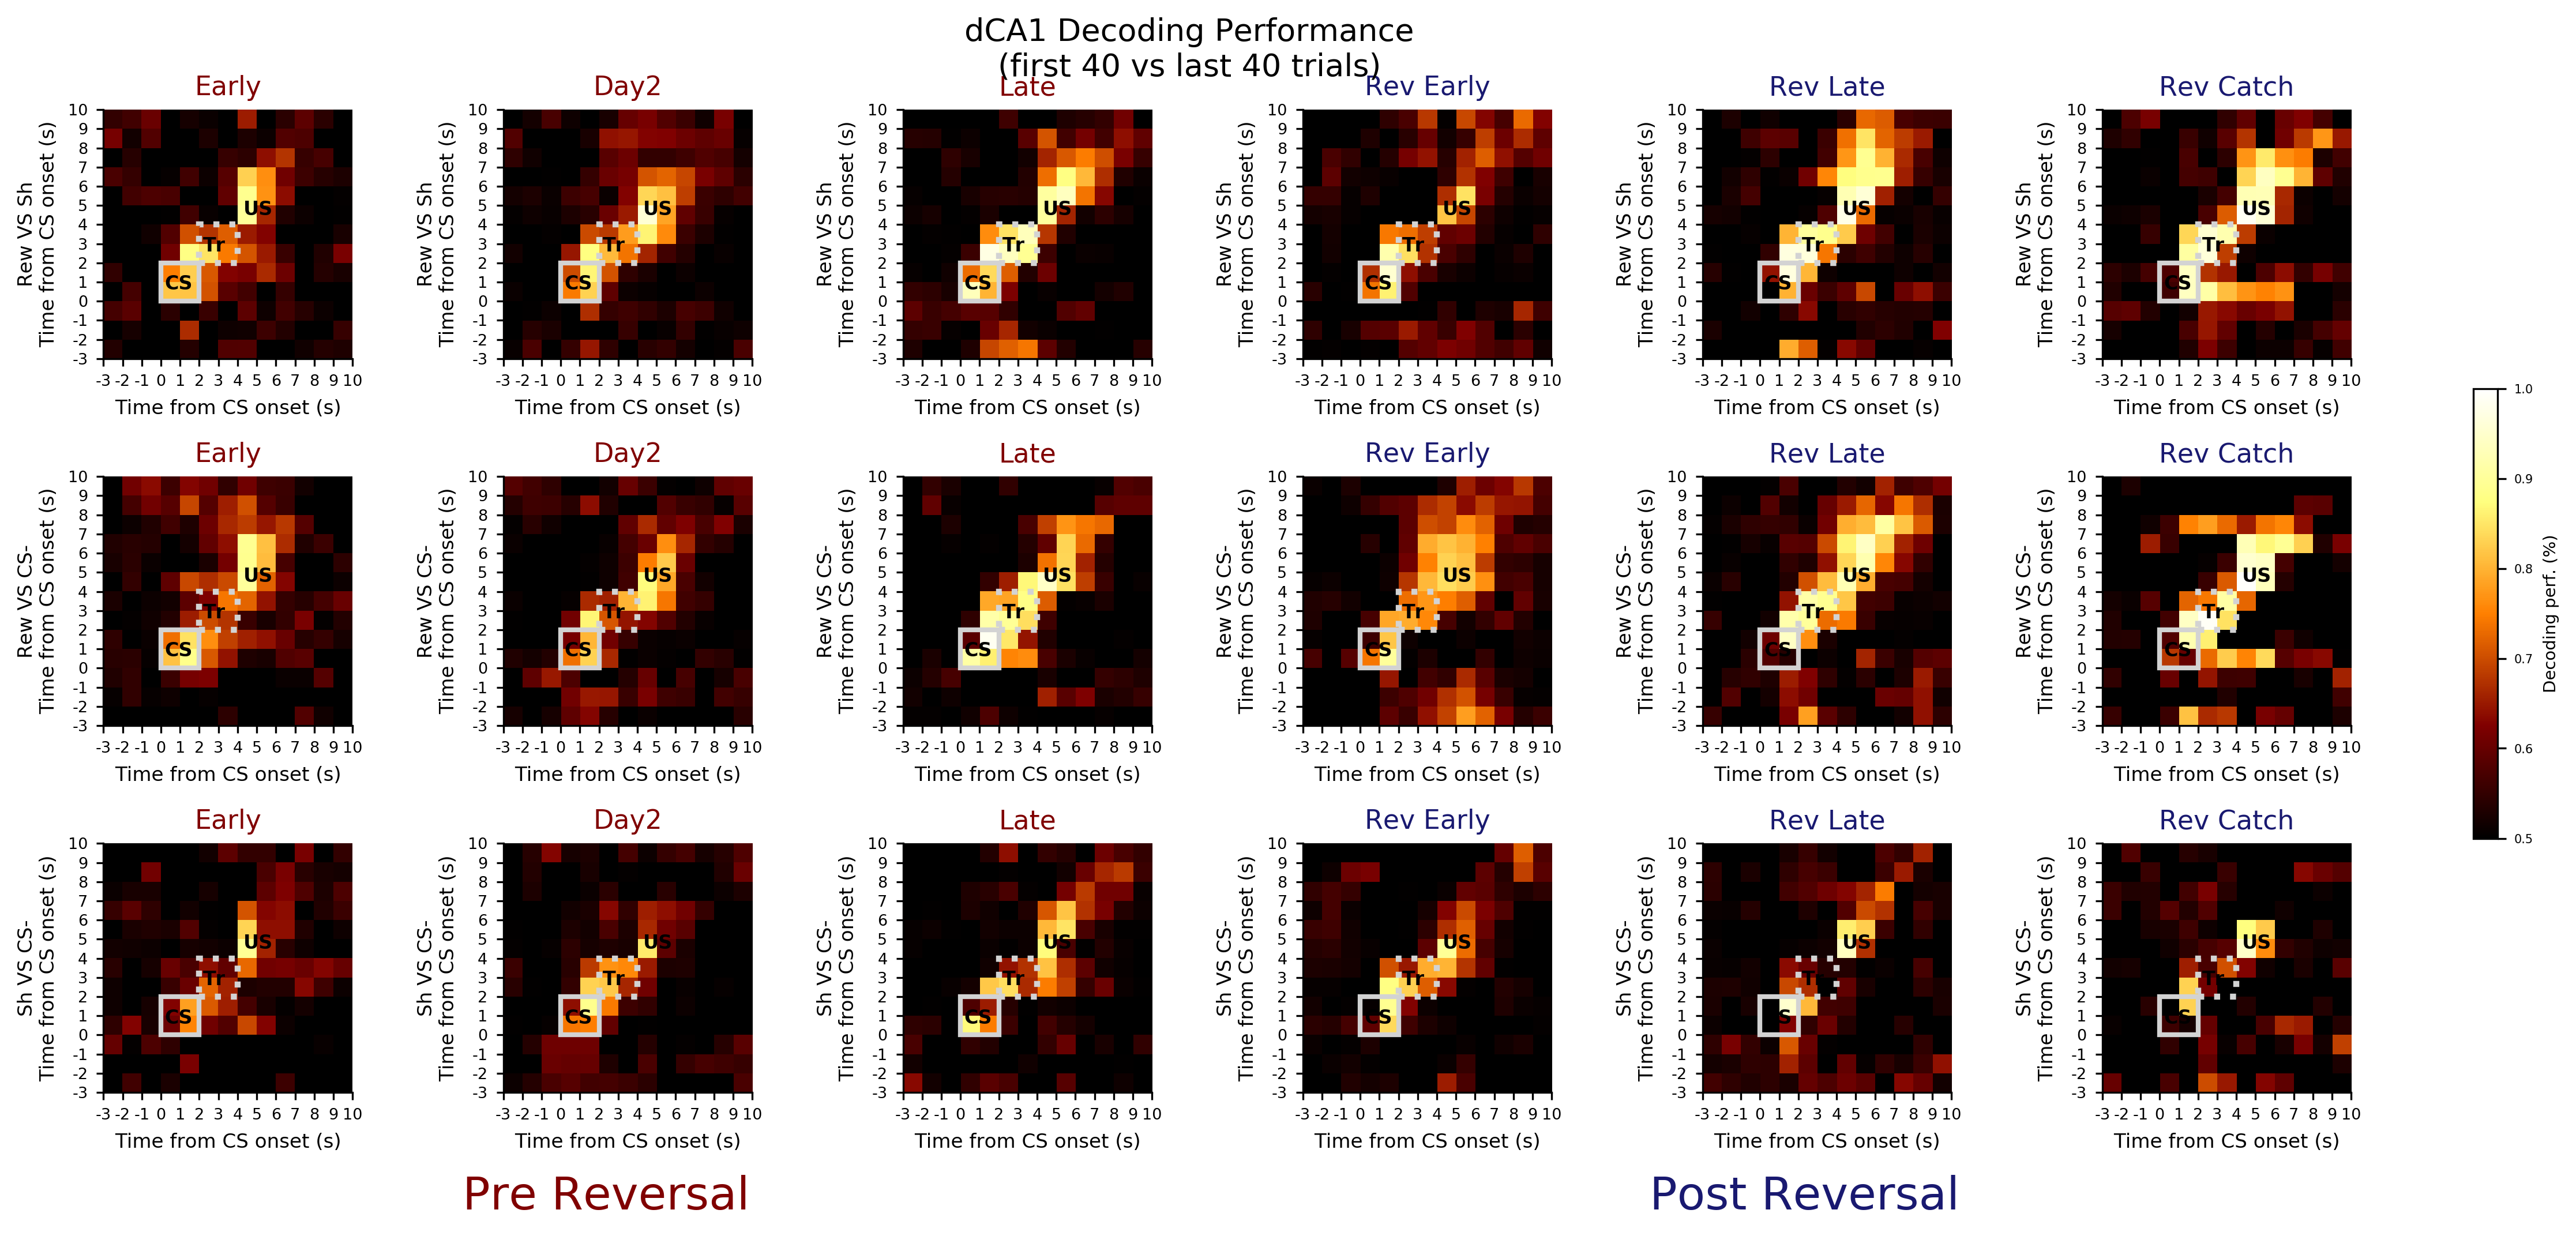

In [30]:
import matplotlib.patches as patches

fig, ax = pl.subplots(3, 6, figsize=(14, 6.5))#, sharex=True, sharey=True)

for label,c,mm,cmap,lab in zip(non_catch_labels,range(3),([.5,1],[.5,1],[.5,1]),['afmhot','afmhot','afmhot'],['Rew VS Sh','Rew VS CS-','Sh VS CS-']):
    for sess,x in zip(sessions,range(len(sessions))):
        im = ax[c][x].imshow(eval("subset_%s[sess]"%label),origin='lower',interpolation='nearest',vmin=mm[0],vmax=mm[1],cmap=cmap)
        ax[c][x].set_xticks(np.arange(-.5,13,1))
        ax[c][x].set_yticks(np.arange(-.5,13,1))
        #ax[c][x].set_ylim(-.5, 12.5)
        #ax[c][x].set_xlim(-.5, 12.5)
        ax[c][x].set_xticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_yticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_ylabel(lab+'\nTime from CS onset (s)', fontsize=8.2)
        ax[c][x].set_xlabel('Time from CS onset (s)', fontsize=8.2)
        ax[c][x].set_title(session_labels[x],fontsize=11,color=session_colors[x])
        ax[c][x].tick_params(length=3)
# Add the patch to the Axes
for x in range(6):
    for c in range(3):
        CS = patches.Rectangle((2.5,2.5),2,2,linewidth=2,edgecolor='lightgrey',facecolor='none')
        Tr = patches.Rectangle((4.5,4.5),2,2,linewidth=2.5,edgecolor='lightgrey',facecolor='none',linestyle=':')
        ax[c][x].add_patch(CS)
        ax[c][x].add_patch(Tr)
        ax[c][x].text(2.7,3.1,"CS",fontsize=8, weight='bold', color='k')
        ax[c][x].text(4.7,5.1,"Tr",fontsize=8, weight='bold', color='k')
        ax[c][x].text(6.8,7,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance\n(first 40 vs last 40 trials)',y=1.03,fontsize=13)

fig.text(x=.2,y=-0.03,s='Pre Reversal',fontsize=19, color='maroon')
fig.text(x=.69,y=-0.03,s='Post Reversal',fontsize=19, color='midnightblue')

cax = fig.add_axes([1.03,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
fig.savefig('../img/%s_gmin_across_bins_subset_horizontal.jpg'%NOTEBOOK_NAME)

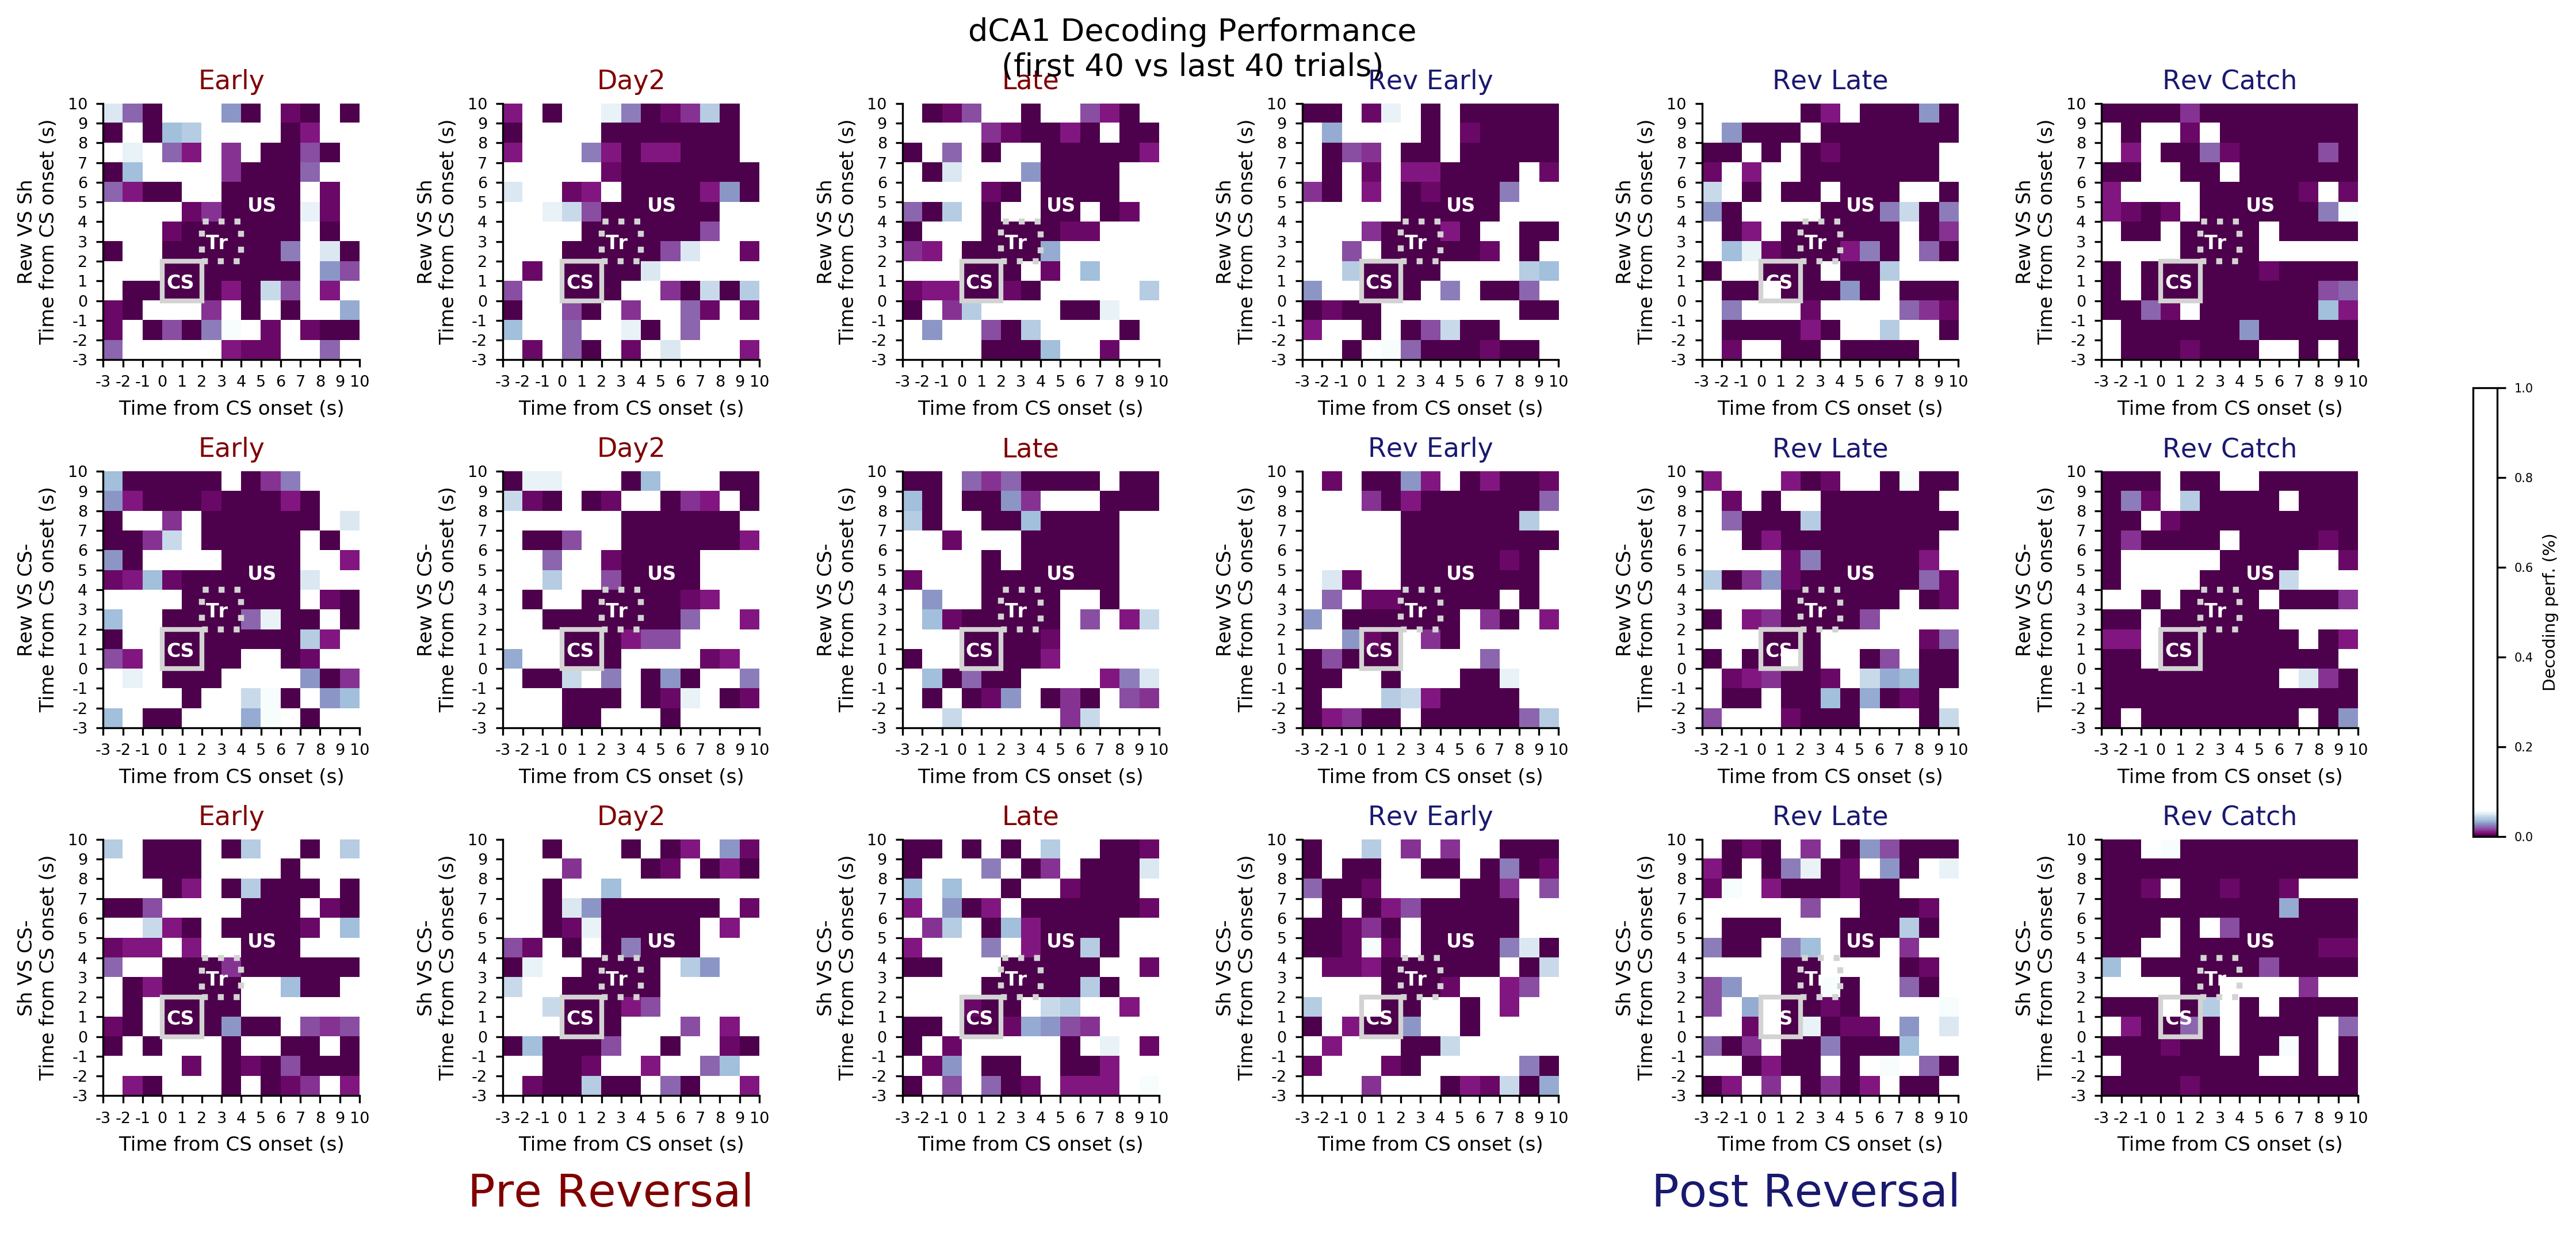

In [29]:
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
black = np.array([0, 0, 0, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(3, 6, figsize=(14, 6.5))#, sharex=True, sharey=True)

for label,c,mm,lab in zip(non_catch_labels,range(3),([0,1],[0,1],[0,1]),['Rew VS Sh','Rew VS CS-','Sh VS CS-']):
    for sess,x in zip(sessions,range(len(sessions))):
        im = ax[c][x].imshow(eval("subset_wilcox_%s[sess]"%label),origin='lower',interpolation='nearest',vmin=mm[0],vmax=mm[1],cmap=newcmap)
        ax[c][x].set_xticks(np.arange(-.5,13,1))
        ax[c][x].set_yticks(np.arange(-.5,13,1))
        #ax[c][x].set_ylim(-.5, 12.5)
        #ax[c][x].set_xlim(-.5, 12.5)
        ax[c][x].set_xticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_yticklabels(['-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6.5)
        ax[c][x].set_ylabel(lab+'\nTime from CS onset (s)', fontsize=8.2)
        ax[c][x].set_xlabel('Time from CS onset (s)', fontsize=8.2)
        ax[c][x].set_title(session_labels[x],fontsize=11,color=session_colors[x])
        ax[c][x].tick_params(length=3)
# Add the patch to the Axes
for x in range(6):
    for c in range(3):
        CS = patches.Rectangle((2.5,2.5),2,2,linewidth=2,edgecolor='lightgrey',facecolor='none')
        Tr = patches.Rectangle((4.5,4.5),2,2,linewidth=2.5,edgecolor='lightgrey',facecolor='none',linestyle=':')
        ax[c][x].add_patch(CS)
        ax[c][x].add_patch(Tr)
        ax[c][x].text(2.7,3.1,"CS",fontsize=8, weight='bold', color='w')
        ax[c][x].text(4.7,5.1,"Tr",fontsize=8, weight='bold', color='w')
        ax[c][x].text(6.8,7,"US",fontsize=8, weight='bold', color='w')

pl.suptitle('dCA1 Decoding Performance\n(first 40 vs last 40 trials)',y=1.03,fontsize=13)

fig.text(x=.2,y=-0.03,s='Pre Reversal',fontsize=19, color='maroon')
fig.text(x=.69,y=-0.03,s='Post Reversal',fontsize=19, color='midnightblue')

cax = fig.add_axes([1.03,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_subset_horizontal.pdf'%NOTEBOOK_NAME)

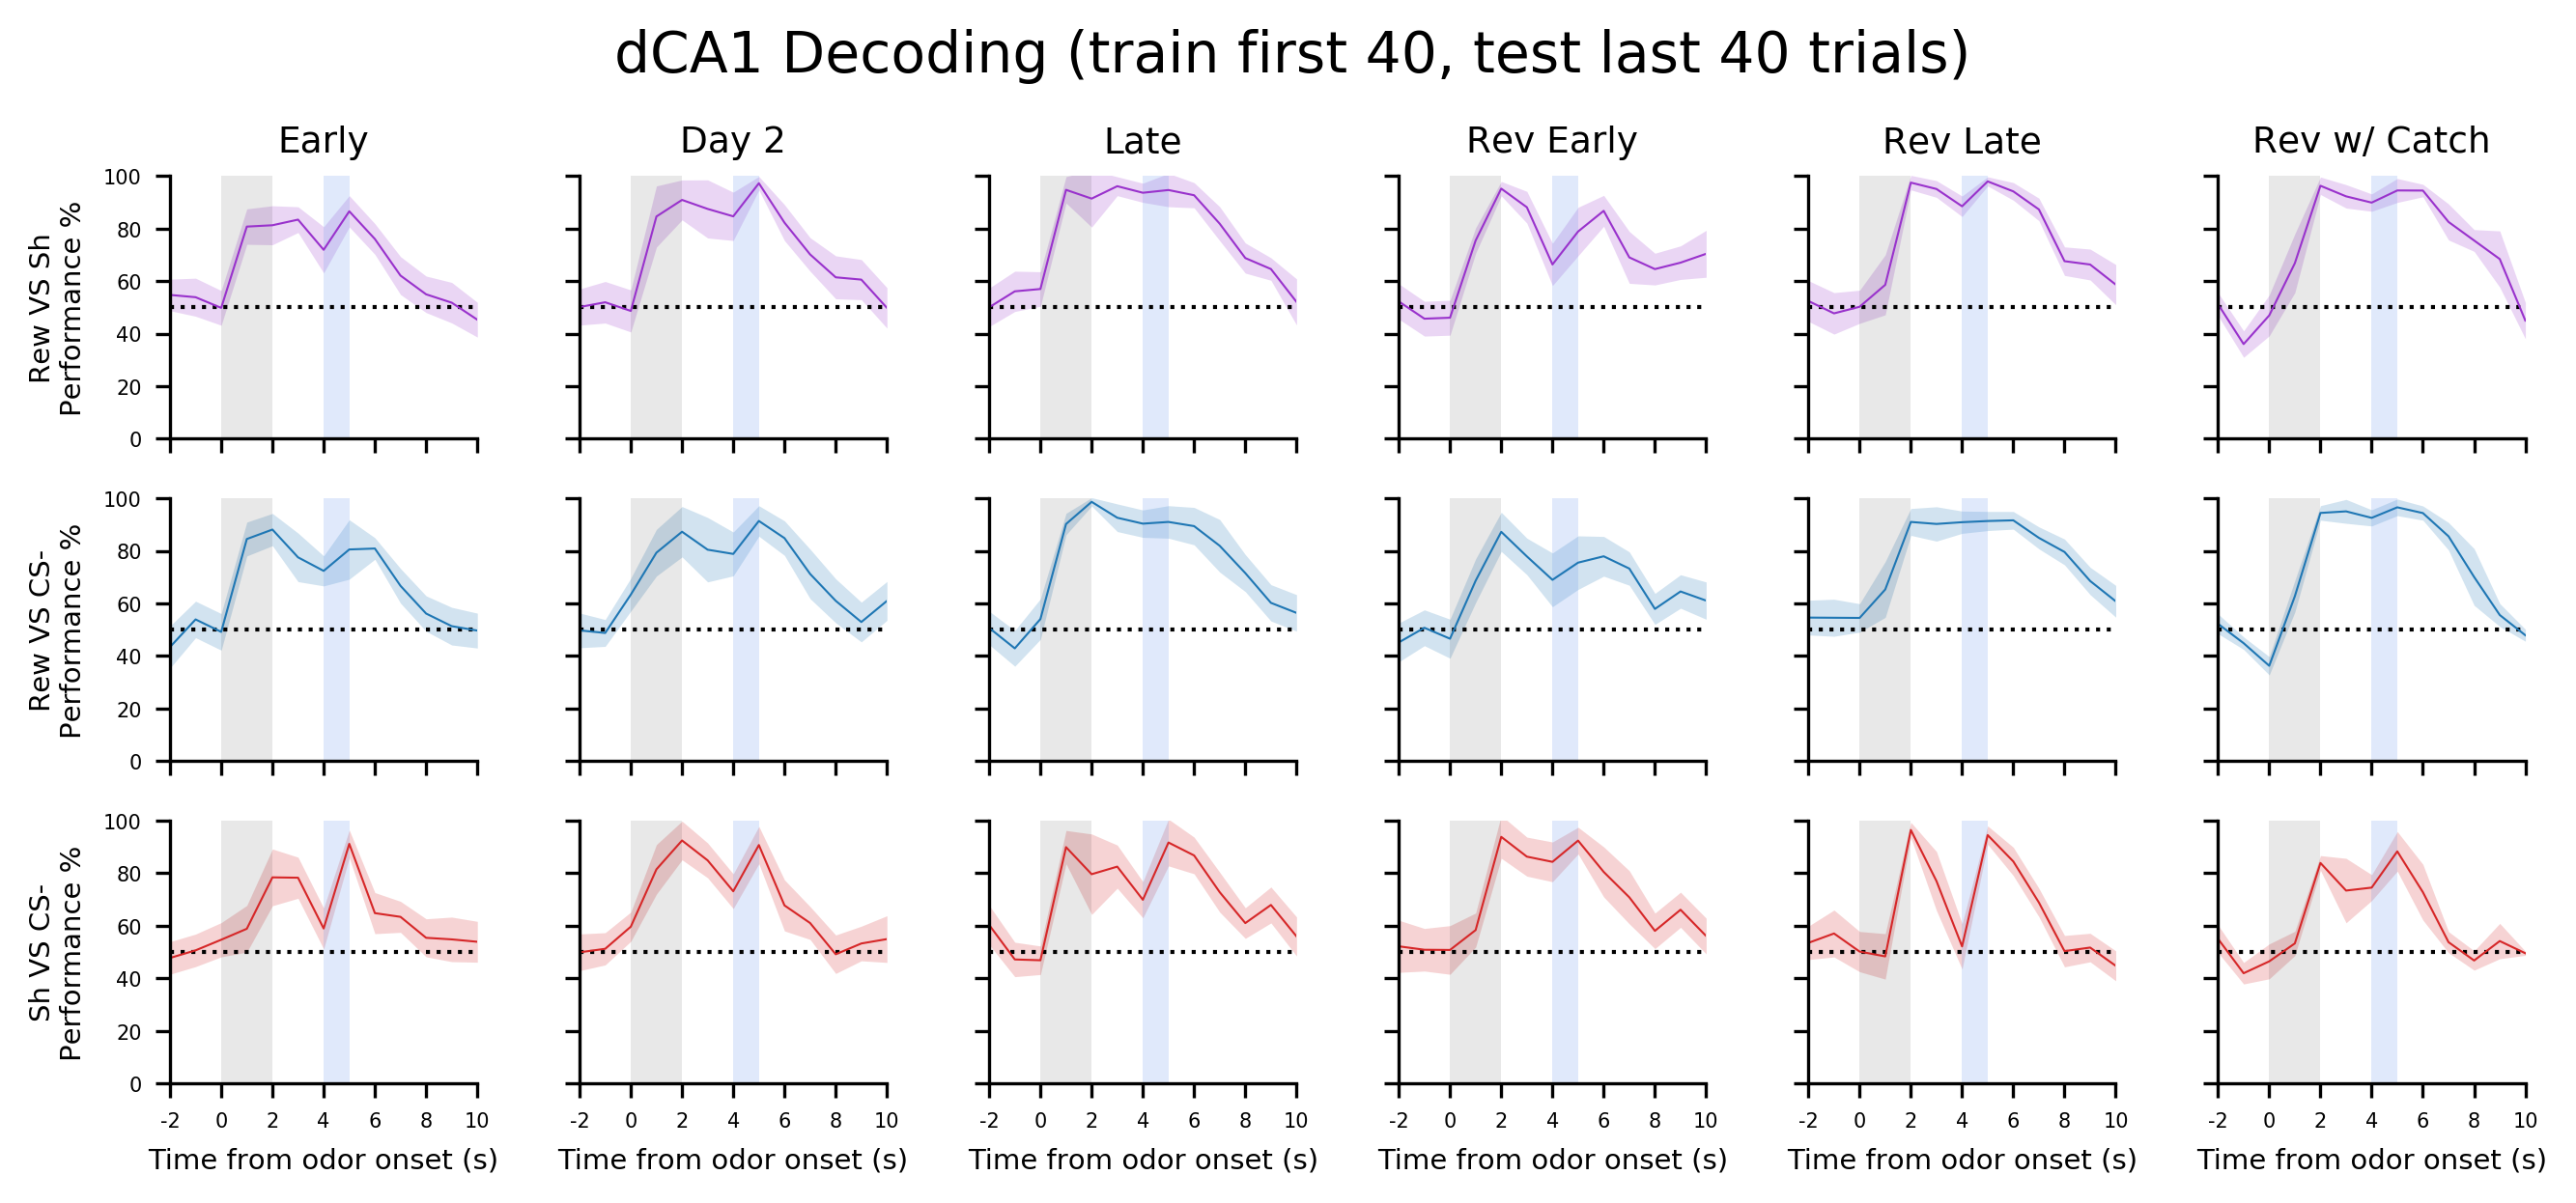

In [31]:
fig, ax = pl.subplots(3,6, figsize=(9, 3.9), sharex=True, sharey=True)

for r,sess in zip(range(6),sessions):
    for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("subsets_within_scores_%s_VS_%s_%s[sess]"%(t,t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("subsets_within_scores_%s_VS_%s_%s[sess]"%(t,t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("subsets_within_scores_%s_VS_%s_%s[sess]"%(t,t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(6):       
    for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Day 2', fontsize=9, color='k')
ax[0][2].set_title('Late', fontsize=9, color = 'k')
ax[0][3].set_title('Rev Early', fontsize=9, color = 'k')
ax[0][4].set_title('Rev Late', fontsize=9, color = 'k')
ax[0][5].set_title('Rev w/ Catch', fontsize=9, color='k')

pl.suptitle('dCA1 Decoding (train first 40, test last 40 trials)',fontsize=14,y=1.05)
fig.tight_layout(pad=2)


fig.savefig('../img/%s_subset_horizontal_all_comp.jpg'%NOTEBOOK_NAME)

In [24]:
#now just get the overall mean for forward and reverse train/test directions

for t in range (13):
    for label in non_catch_labels:
        exec('subset%s_mean_%s = {}'%(t,label))
        for sess in sessions:
            exec("subset%s_mean_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('subset%s_mean_%s'%(t,label))[sess].insert(c,(eval('subsets_within_scores_%s_VS_%s_%s'%(t,c,label))[sess]).mean())
             
#for catch trials    
for t in range (13):
    for label in catch_labels:
        exec('subset%s_mean_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("subset%s_mean_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                eval('subset%s_mean_%s'%(t,label))[sess].insert(c,(eval('subsets_within_scores_%s_VS_%s_%s'%(t,c,label))[sess]).mean())

In [25]:
for label in non_catch_labels:
    exec("subset_mean_%s={}"%(label))
    for sess in sessions:
        exec("subset_mean_%s[sess]=(subset0_mean_%s[sess], subset1_mean_%s[sess], subset2_mean_%s[sess], subset3_mean_%s[sess],\
        subset4_mean_%s[sess], subset5_mean_%s[sess], subset6_mean_%s[sess], subset7_mean_%s[sess], subset8_mean_%s[sess],\
        subset9_mean_%s[sess], subset10_mean_%s[sess], subset11_mean_%s[sess], subset12_mean_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_mean_%s[sess]"%label)])
             
for label in catch_labels:
    exec("subset_mean_%s={}"%(label))
    for sess in 'catch',:
        exec("subset_mean_%s[sess]=(subset0_mean_%s[sess], subset1_mean_%s[sess], subset2_mean_%s[sess], subset3_mean_%s[sess],\
        subset4_mean_%s[sess], subset5_mean_%s[sess], subset6_mean_%s[sess], subset7_mean_%s[sess], subset8_mean_%s[sess],\
        subset9_mean_%s[sess], subset10_mean_%s[sess], subset11_mean_%s[sess], subset12_mean_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_mean_%s[sess]"%label)])

In [26]:
for t in range (13):
    for label in non_catch_labels:
        exec('subset%s_mean_wilcox_%s = {}'%(t,label))
        for sess in sessions:
            exec("subset%s_mean_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in subsets_within_scores_%s_VS_%s_%s[sess].mean(1)]"%(t,c,label))
                eval('subset%s_mean_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('subset%s_mean_wilcox_%s'%(t,label))[sess],range(len(eval('subset%s_mean_wilcox_%s'%(t,label))[sess]))):
                exec("subset%s_mean_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values
                
for t in range (13):
    for label in catch_labels:
        exec('subset%s_mean_wilcox_%s = {}'%(t,label))
        for sess in 'catch',:
            exec("subset%s_mean_wilcox_%s['%s'] = []"%(t,label,sess))
            for c in range (13):
                exec("subtracted = [x-0.5 for x in subsets_within_scores_%s_VS_%s_%s[sess].mean(1)]"%(t,c,label))
                eval('subset%s_mean_wilcox_%s'%(t,label))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('subset%s_mean_wilcox_%s'%(t,label))[sess],range(len(eval('subset%s_mean_wilcox_%s'%(t,label))[sess]))):
                exec("subset%s_mean_wilcox_%s[sess][i] = x[-1]"%(t,label)) #only take p-values

In [27]:
for label in non_catch_labels:
    exec("subset_mean_wilcox_%s={}"%(label))
    for sess in sessions:
        exec("subset_mean_wilcox_%s[sess]=(subset0_mean_wilcox_%s[sess], subset1_mean_wilcox_%s[sess], subset2_mean_wilcox_%s[sess], subset3_mean_wilcox_%s[sess],\
        subset4_mean_wilcox_%s[sess], subset5_mean_wilcox_%s[sess], subset6_mean_wilcox_%s[sess], subset7_mean_wilcox_%s[sess], subset8_mean_wilcox_%s[sess],\
        subset9_mean_wilcox_%s[sess], subset10_mean_wilcox_%s[sess], subset11_mean_wilcox_%s[sess], subset12_mean_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_mean_wilcox_%s[sess]"%label)])
             
for label in catch_labels:
    exec("subset_mean_wilcox_%s={}"%(label))
    for sess in 'catch',:
        exec("subset_mean_wilcox_%s[sess]=(subset0_mean_wilcox_%s[sess], subset1_mean_wilcox_%s[sess], subset2_mean_wilcox_%s[sess], subset3_mean_wilcox_%s[sess],\
        subset4_mean_wilcox_%s[sess], subset5_mean_wilcox_%s[sess], subset6_mean_wilcox_%s[sess], subset7_mean_wilcox_%s[sess], subset8_mean_wilcox_%s[sess],\
        subset9_mean_wilcox_%s[sess], subset10_mean_wilcox_%s[sess], subset11_mean_wilcox_%s[sess], subset12_mean_wilcox_%s[sess])"%(label,label,label,label,label,
                                                                     label,label,label,label,label,label,label,label,label))
        np.array([eval("subset_mean_wilcox_%s[sess]"%label)])

## Now try decoding outcome
#### ie, train on rew vs CS- and test on shock vs CS- (or will using CS- for both muck things up?)

In [13]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_outcome_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_outcome_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_outcome_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT, yT)
    decoder.fit(xT, yT)
    return np.append(scores, decoder.score(x,y))
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [50]:
%%time
tt_relabels = [{0:0,1:1,2:-1}, {0:0,1:-1,2:1}]
tt_relabels_test = [{0:0,1:-1,2:1}, {0:0,1:1,2:-1}]
tt_pairs = ['trRwCSm_tsShCSm','trShCSm_tsRwCSm']
for t in range(13): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_outcome_%s = {}'%(t,it))
        n_loops = 50
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_outcome_%s"%(t,it))[sess] = np.r_[[do_outcome_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(3), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

pre 0 d2 0 post 0 pre_rev 0 post_rev 0 catch 0 pre 0 d2 0 post 0 pre_rev 0 post_rev 0 catch 0 pre 1 d2 1 post 1 pre_rev 1 post_rev 1 catch 1 pre 1 d2 1 post 1 pre_rev 1 post_rev 1 catch 1 pre 2 d2 2 post 2 pre_rev 2 post_rev 2 catch 2 pre 2 d2 2 post 2 pre_rev 2 post_rev 2 catch 2 pre 3 d2 3 post 3 pre_rev 3 post_rev 3 catch 3 pre 3 d2 3 post 3 pre_rev 3 post_rev 3 catch 3 pre 4 d2 4 post 4 pre_rev 4 post_rev 4 catch 4 pre 4 d2 4 post 4 pre_rev 4 post_rev 4 catch 4 pre 5 d2 5 post 5 pre_rev 5 post_rev 5 catch 5 pre 5 d2 5 post 5 pre_rev 5 post_rev 5 catch 5 pre 6 d2 6 post 6 pre_rev 6 post_rev 6 catch 6 pre 6 d2 6 post 6 pre_rev 6 post_rev 6 catch 6 pre 7 d2 7 post 7 pre_rev 7 post_rev 7 catch 7 pre 7 d2 7 post 7 pre_rev 7 post_rev 7 catch 7 pre 8 d2 8 post 8 pre_rev 8 post_rev 8 catch 8 pre 8 d2 8 post 8 pre_rev 8 post_rev 8 catch 8 pre 9 d2 9 post 9 pre_rev 9 post_rev 9 catch 9 pre 9 d2 9 post 9 pre_rev 9 post_rev 9 catch 9 pre 10 d2 10 post 10 pre_rev 10 post_rev 10 catch 10 pre 10 

In [51]:
%%time
tt_relabels = [{0:0,1:1,2:-1}, {0:0,1:-1,2:1}]
tt_relabels_test = [{0:0,1:-1,2:1}, {0:0,1:1,2:-1}]
tt_pairs = ['trRwCSm_tsShCSm','trShCSm_tsRwCSm']
for t in range(13): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_nd_outcome_%s = {}'%(t,it))
        n_loops = 50
        for sess in ['catch']:
            print sess,
            print t,
            eval("scores_tb_%s_nd_outcome_%s"%(t,it))[sess] = np.r_[[do_outcome_test_within(eval("patterns_tb_%s_%s"%(t,sess)),
                  labels_catch_nd,classes=range(3), n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

catch 0 catch 0 catch 1 catch 1 catch 2 catch 2 catch 3 catch 3 catch 4 catch 4 catch 5 catch 5 catch 6 catch 6 catch 7 catch 7 catch 8 catch 8 catch 9 catch 9 catch 10 catch 10 catch 11 catch 11 catch 12 catch 12CPU times: user 35 s, sys: 48 ms, total: 35.1 s
Wall time: 35 s



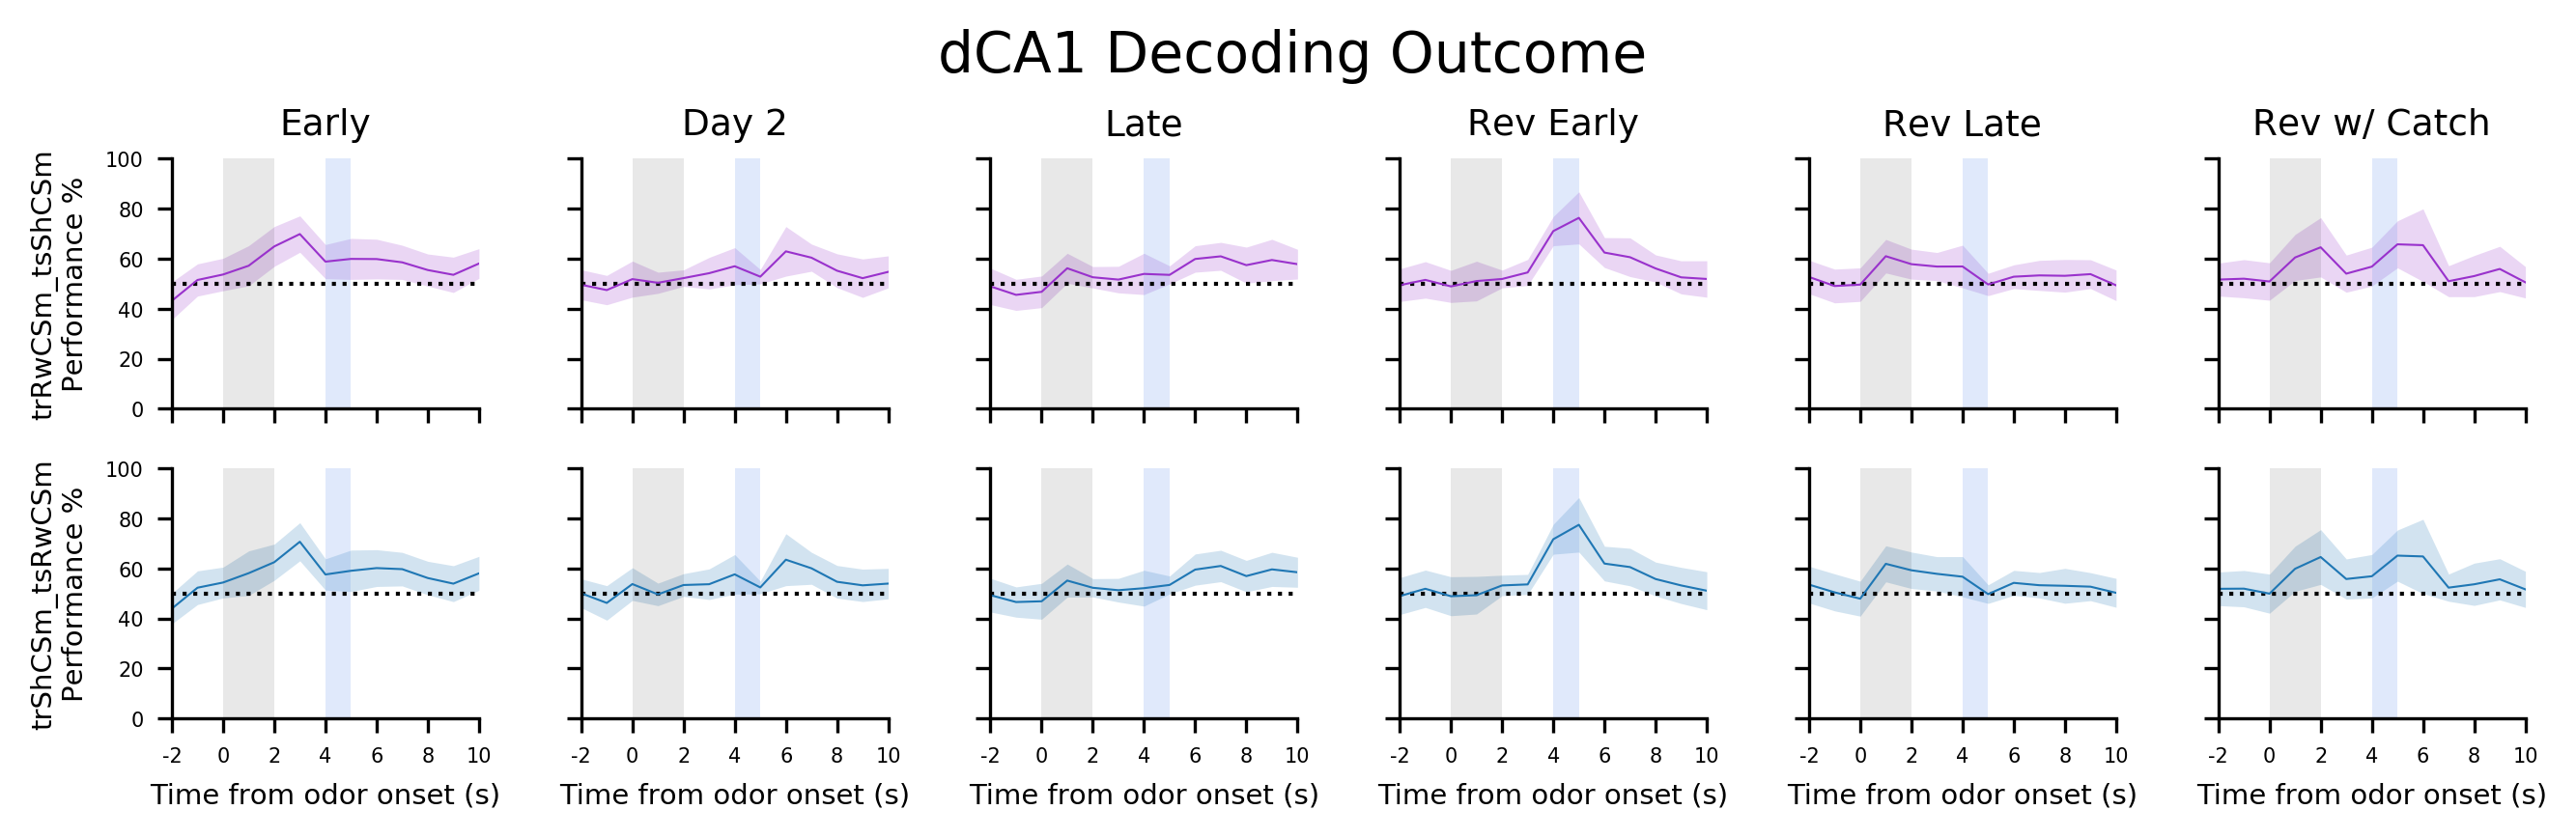

In [52]:
fig, ax = pl.subplots(2,6, figsize=(9, 2.7), sharex=True, sharey=True)

for r,sess in zip(range(6),sessions):
    for c,label,col in zip(range(2),['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(6):       
    for lab, c in zip(['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],range(2)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[1][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Day 2', fontsize=9, color='k')
ax[0][2].set_title('Late', fontsize=9, color = 'k')
ax[0][3].set_title('Rev Early', fontsize=9, color = 'k')
ax[0][4].set_title('Rev Late', fontsize=9, color = 'k')
ax[0][5].set_title('Rev w/ Catch', fontsize=9, color='k')

pl.suptitle('dCA1 Decoding Outcome',fontsize=14,y=1.05)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_gmin_horizontal.pdf'%NOTEBOOK_NAME)

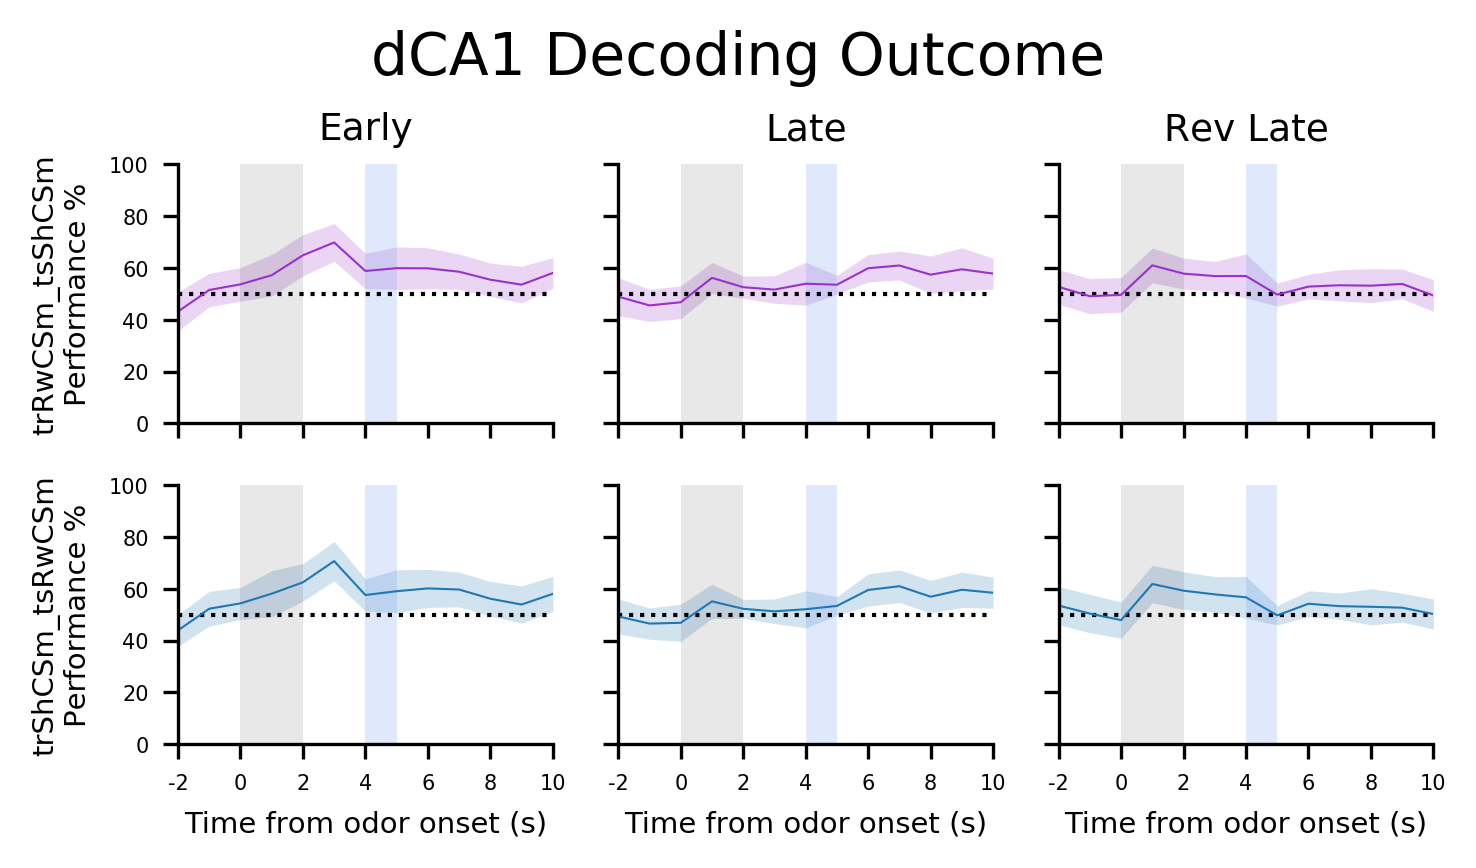

In [53]:
fig, ax = pl.subplots(2,3, figsize=(5, 2.7), sharex=True, sharey=True)

for r,sess in zip(range(3),['pre','post','post_rev']):
    for c,label,col in zip(range(2),['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s_outcome_%s[sess]"%(t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(3):       
    for lab, c in zip(['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],range(2)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[1][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Early', fontsize=9, color = 'k')
ax[0][1].set_title('Late', fontsize=9, color = 'k')
ax[0][2].set_title('Rev Late', fontsize=9, color = 'k')

pl.suptitle('dCA1 Decoding Outcome',fontsize=14,y=1.05)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_gmin_horizontal.pdf'%NOTEBOOK_NAME)

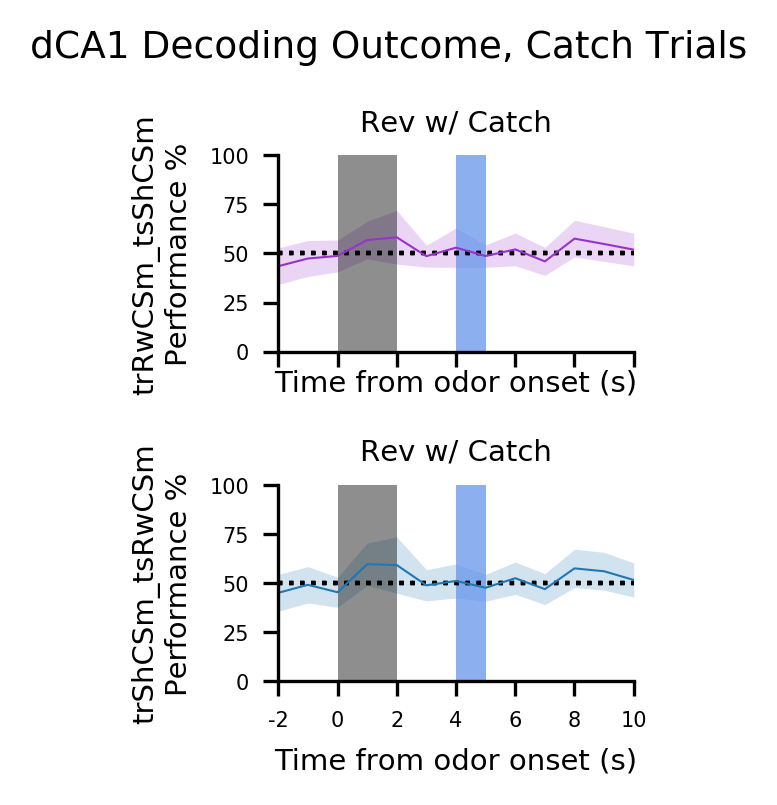

In [54]:
fig, ax = pl.subplots(2,1, figsize=(2, 2.5), sharex=True, sharey=True)

for c,label,col in zip(range(2),['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],('darkorchid','tab:blue','tab:red')):
        ax[c].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_tb_%s_nd_outcome_%s['catch']"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_tb_%s_nd_outcome_%s['catch']"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_tb_%s_nd_outcome_%s['catch']"%(t,label)))*100 for t in range(13)])
        ax[c].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(6):       
    for lab, c in zip(['trRwCSm_tsShCSm','trShCSm_tsRwCSm'],range(2)):
        ax[c].set_ylim(0, 100)
        ax[c].set_xlim(-2, 10)
        ax[c].set_xticks(np.arange(-2,11, 2))
        ax[c].set_xticklabels(np.arange(-2,11, 2))
        ax[c].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[c].set_xlabel('Time from odor onset (s)')
        ax[c].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[c].set_title('Rev w/ Catch', fontsize=7, color='k')

pl.suptitle('dCA1 Decoding Outcome, Catch Trials',fontsize=9,y=1.05)
fig.tight_layout(pad=2)


#fig.savefig('../img/%s_gmin_horizontal.pdf'%NOTEBOOK_NAME)

## now train on 1 session and test on another
##### mostly to see whether expectation signal is independent of preceding CS (which 4odor suggests is the case)

In [55]:
preVSpost_animals =        'dhpcg1','dhpc24','dhpcg20'
preVSpre_rev_animals =     'dhpcg1','dhpc24','dhpcg20'
preVSpost_rev_animals =             'dhpc24','dhpcg20'
postVSpost_rev_animals =   'dhpcg1','dhpc24','dhpcg20'
postVSpre_rev_animals =    'dhpcg1','dhpc24','dhpcg20'
pre_revVSpost_rev_animals= 'dhpcg1','dhpc24','dhpcg20'
postVScatch_animals =      'dhpcg1'         ,'dhpcg20'
post_revVScatch_animals=   'dhpcg1'         ,'dhpcg20'

In [56]:
comparisons = 'postVSpost_rev','postVScatch'

all_comparisons = 'postVSpost_rev__patterns__post',\
'postVSpost_rev__patterns__post_rev',\
'postVScatch__patterns__post',\
'postVScatch__patterns__catch'

In [57]:
#get cross-session patterns
for comp in comparisons:
    for dur in 1,:
        exec("%s__patterns__%s = dict(zip(%s_animals, [ut.load_variable('%s_patterns_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(comp,comp.split('VS')[0],comp,
                                                    comp,comp.split('VS')[0],dur,comp))
        exec("%s__patterns__%s = dict(zip(%s_animals, [ut.load_variable('%s_patterns_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(comp,comp.split('VS')[1],comp,
                                                    comp,comp.split('VS')[1],dur,comp))

In [58]:
for comp in all_comparisons:
    for t in range(13):
        exec("%s_tb_%s = {}"%(comp,t))
        for ani in eval('%s_animals'%comp.split('__')[0]):
            try:
                #print comp.split('-')[0],
                #print ani,
                #print t,
                exec("%s_tb_%s['%s'] = %s['%s'][%s]"%(comp,t,ani,comp,ani,t))
            except IOError as error:
                print 'ERROR'
            continue

In [14]:
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):

    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [60]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for label in non_catch_labels:
        exec('scores_across_tb_%s_%s = {}'%(t,label))
        for comp, vs in zip(comparisons,(all_comparisons[:2],all_comparisons[2:])):
            print comp,label,t,
            eval("scores_across_tb_%s_%s"%(t,label))[comp] = np.r_[[do_test_cross(eval('%s_tb_%s'%(vs[0],t)),
                  eval('labels_%s_%s'%(label,comp.split('VS')[0])),eval('%s_tb_%s'%(vs[1],t)),
                  eval('labels_%s_%s'%(label,comp.split('VS')[1])), n_cells=None) for i in range(n_loops)]]

postVSpost_rev rwVSsh 0 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch rwVSsh 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVSpost_rev rwVScsm 0 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch rwVScsm 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVSpost_rev shVScsm 0 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch shVScsm 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVSpost_rev rwVSsh 1 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch rwVSsh 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVSpost_rev rwVScsm 1 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch rwVScsm 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVSpost_rev shVScsm 1 281 281 281 281 281 281 281 281 281 281 281 281 281 281 281 postVScatch shVScsm 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 po

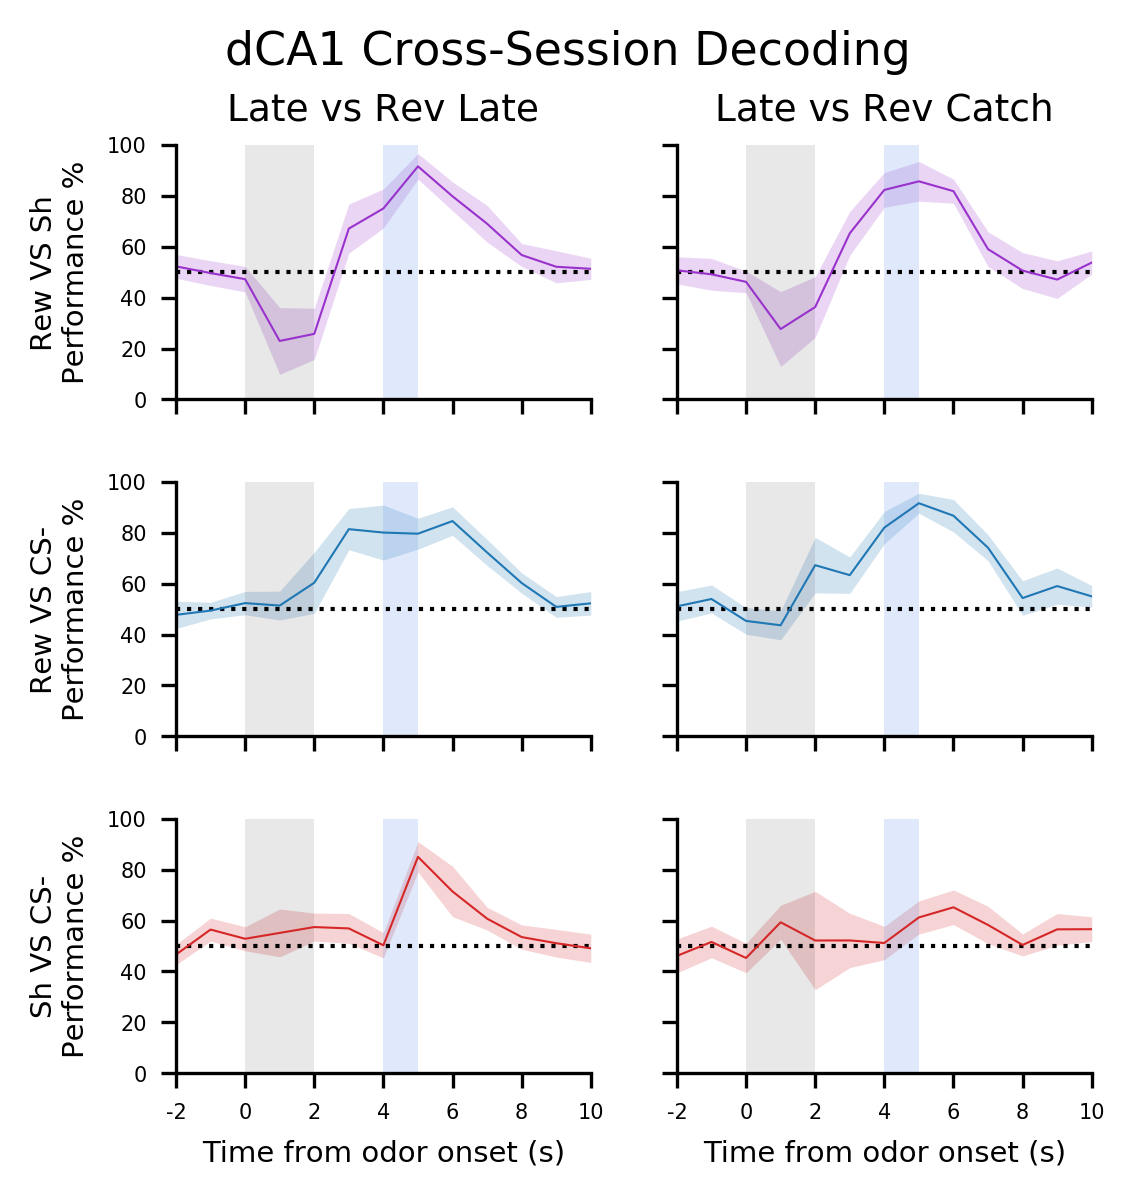

In [61]:
fig, ax = pl.subplots(3,2, figsize=(4,4), sharex=True, sharey=True)

for r,comp in zip(range(2),comparisons):
    for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c][r].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_across_tb_%s_%s[comp]"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_across_tb_%s_%s[comp]"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_across_tb_%s_%s[comp]"%(t,label)))*100 for t in range(13)])
        ax[c][r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for r in range(2):       
    for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c][r].set_ylim(0, 100)
        ax[c][r].set_xlim(-2, 10)
        ax[c][r].set_xticks(np.arange(-2,11, 2))
        ax[c][r].set_xticklabels(np.arange(-2,11, 2))
        ax[c][r].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2][r].set_xlabel('Time from odor onset (s)')
        ax[c][0].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c][r], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c][r], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0][0].set_title('Late vs Rev Late', fontsize=9, color = 'k')
ax[0][1].set_title('Late vs Rev Catch', fontsize=9, color = 'k')

pl.suptitle('dCA1 Cross-Session Decoding',fontsize=11,y=1.0)
fig.tight_layout(pad=3)


fig.savefig('../img/%s_Xsess_Late_vs.pdf'%NOTEBOOK_NAME)

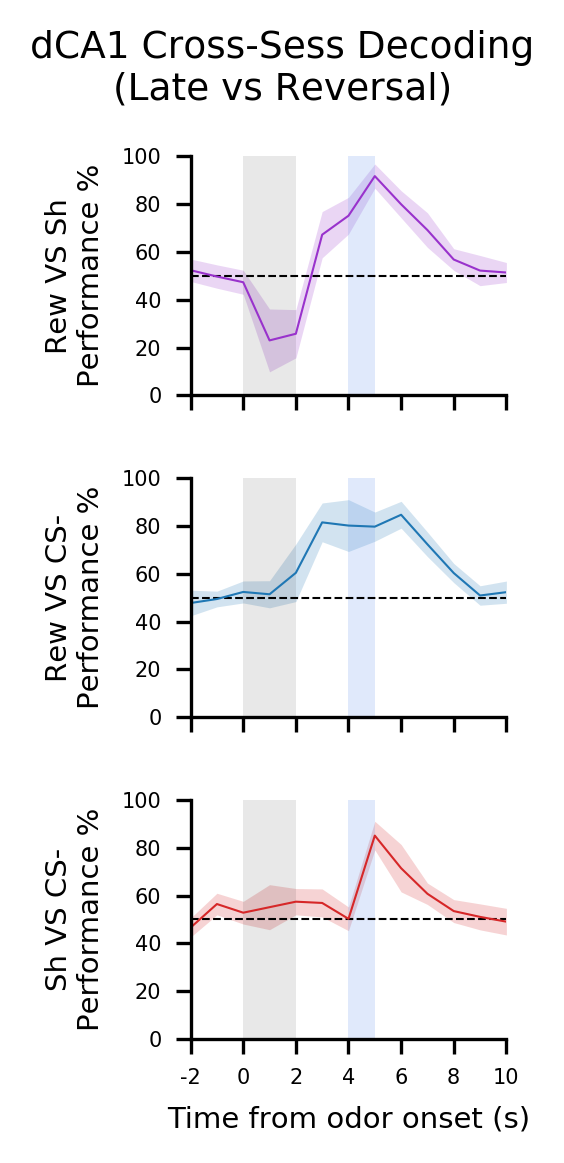

In [216]:
fig, ax = pl.subplots(3,1, figsize=(2,3.7), sharex=True, sharey=True)

for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_across_tb_%s_%s['postVSpost_rev']"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_across_tb_%s_%s['postVSpost_rev']"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_across_tb_%s_%s['postVSpost_rev']"%(t,label)))*100 for t in range(13)])
        ax[c].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c].set_ylim(0, 100)
        ax[c].set_xlim(-2, 10)
        ax[c].set_xticks(np.arange(-2,11, 2))
        ax[c].set_xticklabels(np.arange(-2,11, 2))
        ax[c].hlines(50, -2,10, color='k', lw=.5, linestyles='dashed')
        ax[2].set_xlabel('Time from odor onset (s)')
        ax[c].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')

pl.suptitle('dCA1 Cross-Sess Decoding\n(Late vs Reversal)',fontsize=9,y=1.05)
fig.tight_layout(pad=3)


fig.savefig('../figures/%s_Xsess_LateVSRev.pdf'%NOTEBOOK_NAME)

In [62]:
matched_catch_labels = 'rwndVSshnd','rwndVScsm','shndVScsm'

In [63]:
%%time
n_loops = 15
for t in range(13): # number of time bins
    for label, matched_label in zip(non_catch_labels,matched_catch_labels):
        exec('scores_across_tb_%s_%s_catch = {}'%(t,label))
        for comp, vs in zip(['postVScatch'],[all_comparisons[2:]]):
            print comp,label,t,
            eval("scores_across_tb_%s_%s_catch"%(t,label))[comp] = np.r_[[do_test_cross(eval('%s_tb_%s'%(vs[0],t)),
                  eval('labels_%s_%s'%(label,comp.split('VS')[0])),eval('%s_tb_%s'%(vs[1],t)),
                  eval('labels_%s_%s'%(matched_label,comp.split('VS')[1])), n_cells=None) for i in range(n_loops)]]

postVScatch rwVSsh 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVScsm 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch shVScsm 0 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVSsh 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVScsm 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch shVScsm 1 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVSsh 2 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVScsm 2 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch shVScsm 2 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVSsh 3 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVScsm 3 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch shVScsm 3 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 postVScatch rwVSsh 4

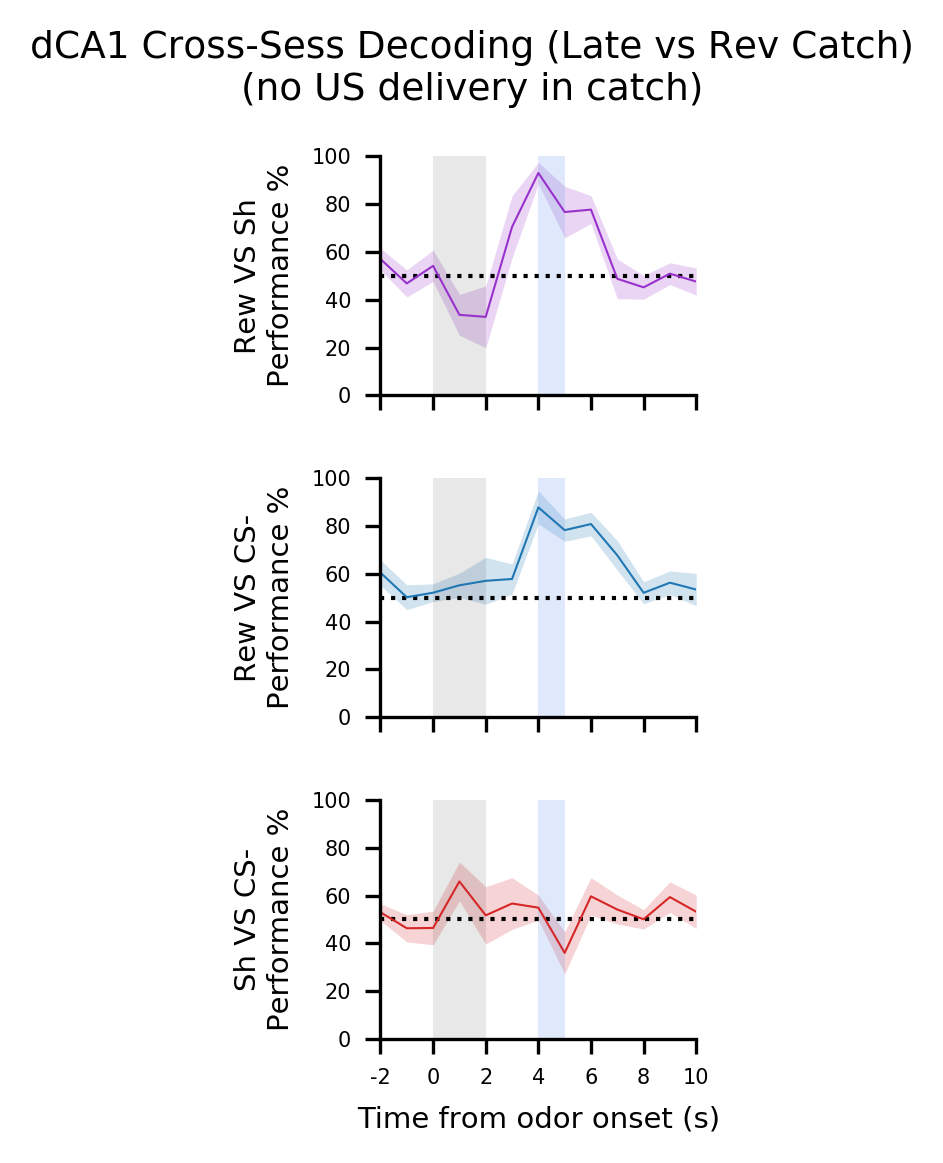

In [64]:
fig, ax = pl.subplots(3,1, figsize=(2,3.7), sharex=True, sharey=True)

for c,label,col in zip(range(3),non_catch_labels,('darkorchid','tab:blue','tab:red')):
        ax[c].plot([(t-2) for t in range(13)], [(np.mean(eval("scores_across_tb_%s_%s_catch['postVScatch']"%(t,label)))*100) for t in range(13)], color=col, ls='-',lw=.5 ,ms=1)
        m = np.array([(np.mean(eval("scores_across_tb_%s_%s_catch['postVScatch']"%(t,label)))*100) for t in range(13)])
        s = np.array([np.std(eval("scores_across_tb_%s_%s_catch['postVScatch']"%(t,label)))*100 for t in range(13)])
        ax[c].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=col,linewidth=0)

for lab, c in zip(['Rew VS Sh','Rew VS CS-','Sh VS CS-'],range(3)):
        ax[c].set_ylim(0, 100)
        ax[c].set_xlim(-2, 10)
        ax[c].set_xticks(np.arange(-2,11, 2))
        ax[c].set_xticklabels(np.arange(-2,11, 2))
        ax[c].hlines(50, -2,10, color='k', lw=1, linestyles='dotted')
        ax[2].set_xlabel('Time from odor onset (s)')
        ax[c].set_ylabel(lab+'\nPerformance %')
        pt.plot_period_bar(ax[c], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[c], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
        #ax[c][r].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')

pl.suptitle('dCA1 Cross-Sess Decoding (Late vs Rev Catch)\n(no US delivery in catch)',fontsize=9,y=1.05)
fig.tight_layout(pad=3)


fig.savefig('../img/%s_Xsess_LateVSCatch.pdf'%NOTEBOOK_NAME)

In [317]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'cax'. Skipping...
Could not store variable 'Tr'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'CS'. Skipping...
Could not store variable 'patches'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...


# if this is all good, delete old data for this nb and re-save